In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from functools import cache

In [29]:
class AntColonyOptimizer:

    def __init__(self, edge_list, ants, evaporation_rate, intensification, alpha=1.0, beta=0.0,
                 beta_evaporation_rate=0, mutation=0.1, tmax=100):
        self.edge_list = edge_list
        self.ants = ants
        self.evaporation_rate = evaporation_rate
        self.intensification = intensification
        self.alpha = alpha
        self.beta = beta
        self.beta_evaporation_rate = beta_evaporation_rate
        self.mutation = mutation
        self.tmax = tmax

        self.vmap, self.int_edge_list = self._map_to_int(edge_list)

        self.graph = nx.Graph()
        self.graph.add_edges_from(self.int_edge_list)

        self.adj_matrix = nx.adjacency_matrix(self.graph).todense()
        self.n = self.adj_matrix.shape[0]

        # self.pheromone_matrix = self.adj_matrix.A1.reshape(self.n, self.n).astype(float)
        self.pheromone_matrix = np.ones((self.n, self.n))
        self.pheromone_matrix[np.eye(self.n) == 1] = 0
        # self.heuristic_matrix = self.pheromone_matrix #  TODO add weights to heuristic matrix

        neighbors = []
        for i in range(self.n):
            neighbors.append(len([x for x in nx.neighbors(self.graph, i)]))

        self.heuristic_matrix = np.array(neighbors)
        self.heuristic_matrix = np.tile(self.heuristic_matrix, self.n)
        self.heuristic_matrix = self.heuristic_matrix.reshape(self.n, self.n)
        self.heuristic_matrix[np.eye(self.n) == 1] = 0

        self.prob_matrix = None
        self._update_probabilities()

        self.best_series = []
        self.best_solution = None
        self.best_score = self.n + 1

    def _map_to_int(self, edges):
        i = 0
        vmap = {}
        int_edge_list = []
        for e in edges:
            if e[0] not in vmap:
                vmap[e[0]] = i
                vmap[i] = e[0]
                i += 1
            if e[1] not in vmap:
                vmap[e[1]] = i
                vmap[i] = e[1]
                i += 1
            int_edge_list.append((vmap[e[0]], vmap[e[1]]))
        return vmap, int_edge_list

    def _update_probabilities(self):
        self.prob_matrix = (self.pheromone_matrix ** self.alpha) * (self.heuristic_matrix ** self.beta)

    def _chose_next_node(self, curr_node, available_nodes):
        numerator = self.prob_matrix[curr_node, available_nodes]
        denominator = np.sum(numerator)
        if (np.random.rand() < self.mutation) or (denominator == 0):
            return np.random.choice(range(len(available_nodes)))
        else:
            probabilities = numerator / denominator
            probabilities[probabilities <= 0] = 0.
            probabilities = probabilities / probabilities.sum()
            return np.random.choice(range(len(probabilities)), p=probabilities)

    # @cache
    def _is_valid_solution(self, solution):
        x = [edge for edge in self.int_edge_list if edge[0] in solution or edge[1] in solution]
        return len(x) == len(self.int_edge_list)

    def _evaluate(self, solutions):
        x_coords = None
        y_coords = None
        best_solution = None
        best_score = self.n + 1
        for s in solutions:
            if len(s) < best_score:
                best_score = len(s)
                best_solution = s
                x_coords = []
                y_coords = []
                for i in range(len(s) - 1):
                    x_coords.append(s[i])
                    y_coords.append(s[i + 1])

        return (x_coords, y_coords), best_solution, best_score

    def _evaporation(self):
        self.pheromone_matrix *= (1 - self.evaporation_rate)
        self.beta *= (1 - self.beta_evaporation_rate)

    def _intensify(self, coords):
        x = coords[0]
        y = coords[1]
        self.pheromone_matrix[x, y] += self.intensification

    def fit(self):
        for t in range(self.tmax):
            solutions = []
            for ant in range(self.ants):
                solution = []
                available_nodes = list(range(self.n))
                curr_node = available_nodes[np.random.randint(0, len(available_nodes))]

                while True:
                    solution.append(curr_node)
                    available_nodes.remove(curr_node)
                    if self._is_valid_solution(solution):
                        break
                    else:
                        curr_node_idx = self._chose_next_node(curr_node, available_nodes)
                        curr_node = available_nodes[curr_node_idx]

                solutions.append(solution)

            best_solution_coords, best_solution, best_score = self._evaluate(solutions)

            if best_score < self.best_score:
                self.best_score = best_score
                self.best_solution = best_solution

            self.best_series.append(best_score)

            self._evaporation()
            self._intensify(best_solution_coords)
            self._update_probabilities()

            print(f'Iteration {t + 1}/{self.tmax}: Best Score = {best_score}, Global Best Score = {self.best_score}')

        print(f'Best fit: Score = {self.best_score}, Solution = {[self.vmap[i] for i in self.best_solution]}')
        plt.figure(figsize=(18, 12))
        plt.plot(self.best_series)
        plt.show()

        color_map = []
        labels = {}
        for i in range(self.n):
            if i in self.best_solution:
                color_map.append('red')
            else:
                color_map.append('blue')
            labels[i] = self.vmap[i]

        plt.figure(figsize=(36,36))
        nx.draw(self.graph, node_color=color_map)
        plt.show()


In [3]:
edges = [("A", "C"), ("C", "B"), ("B", "K"), ("C", "L"),
         ("K", "D"), ("D", "F"), ("D", "M"), ("D", "E"),
         ("E", "L"), ("E", "I"), ("I", "F"), ("F", "G"),
         ("G", "H"), ("G", "N"), ("H", "J"), ("F", "J"),
         ("K", "F")]

aco = AntColonyOptimizer(edges, ants=10, evaporation_rate=0.2, intensification=0.4, alpha=1, beta=1, tmax=100)
# aco.fit()
# print('c')

C:\Users\Johann\AppData\Local\Temp\ipykernel_15828\2253452801.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.adj_matrix = nx.adjacency_matrix(self.graph).todense()


C:\Users\Johann\AppData\Local\Temp\ipykernel_15828\2253452801.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.adj_matrix = nx.adjacency_matrix(self.graph).todense()


Iteration 1/100: Best Score = 20, Global Best Score = 20
Iteration 2/100: Best Score = 21, Global Best Score = 20
Iteration 3/100: Best Score = 20, Global Best Score = 20
Iteration 4/100: Best Score = 21, Global Best Score = 20
Iteration 5/100: Best Score = 20, Global Best Score = 20
Iteration 6/100: Best Score = 20, Global Best Score = 20
Iteration 7/100: Best Score = 20, Global Best Score = 20
Iteration 8/100: Best Score = 21, Global Best Score = 20
Iteration 9/100: Best Score = 21, Global Best Score = 20
Iteration 10/100: Best Score = 20, Global Best Score = 20
Iteration 11/100: Best Score = 21, Global Best Score = 20
Iteration 12/100: Best Score = 20, Global Best Score = 20
Iteration 13/100: Best Score = 21, Global Best Score = 20
Iteration 14/100: Best Score = 21, Global Best Score = 20
Iteration 15/100: Best Score = 21, Global Best Score = 20
Iteration 16/100: Best Score = 21, Global Best Score = 20
Iteration 17/100: Best Score = 21, Global Best Score = 20
Iteration 18/100: Best 

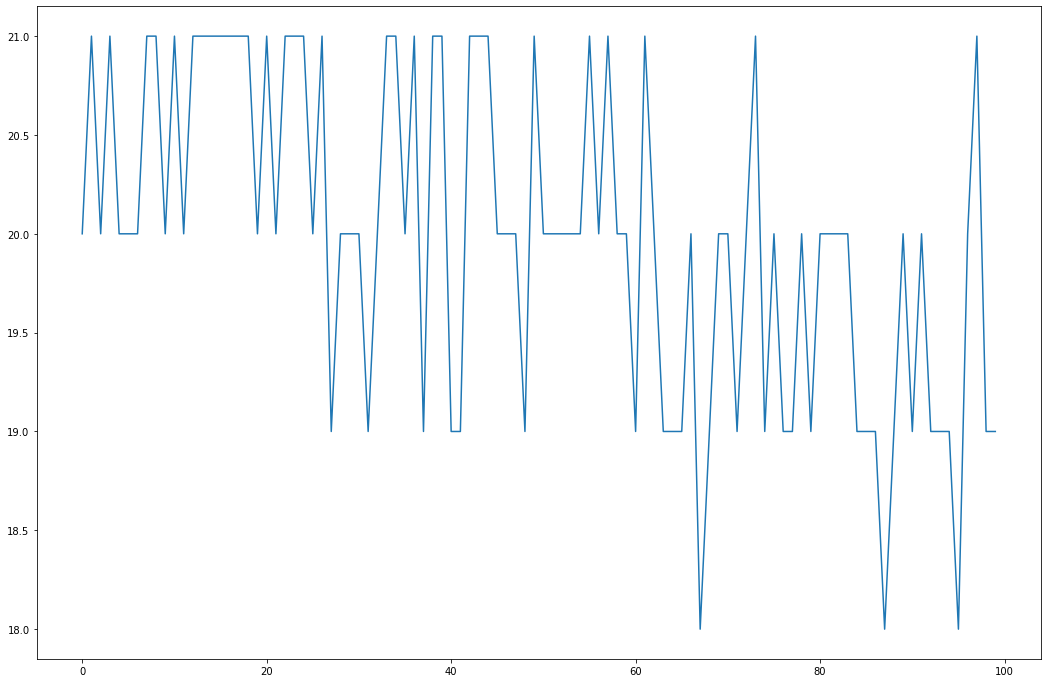

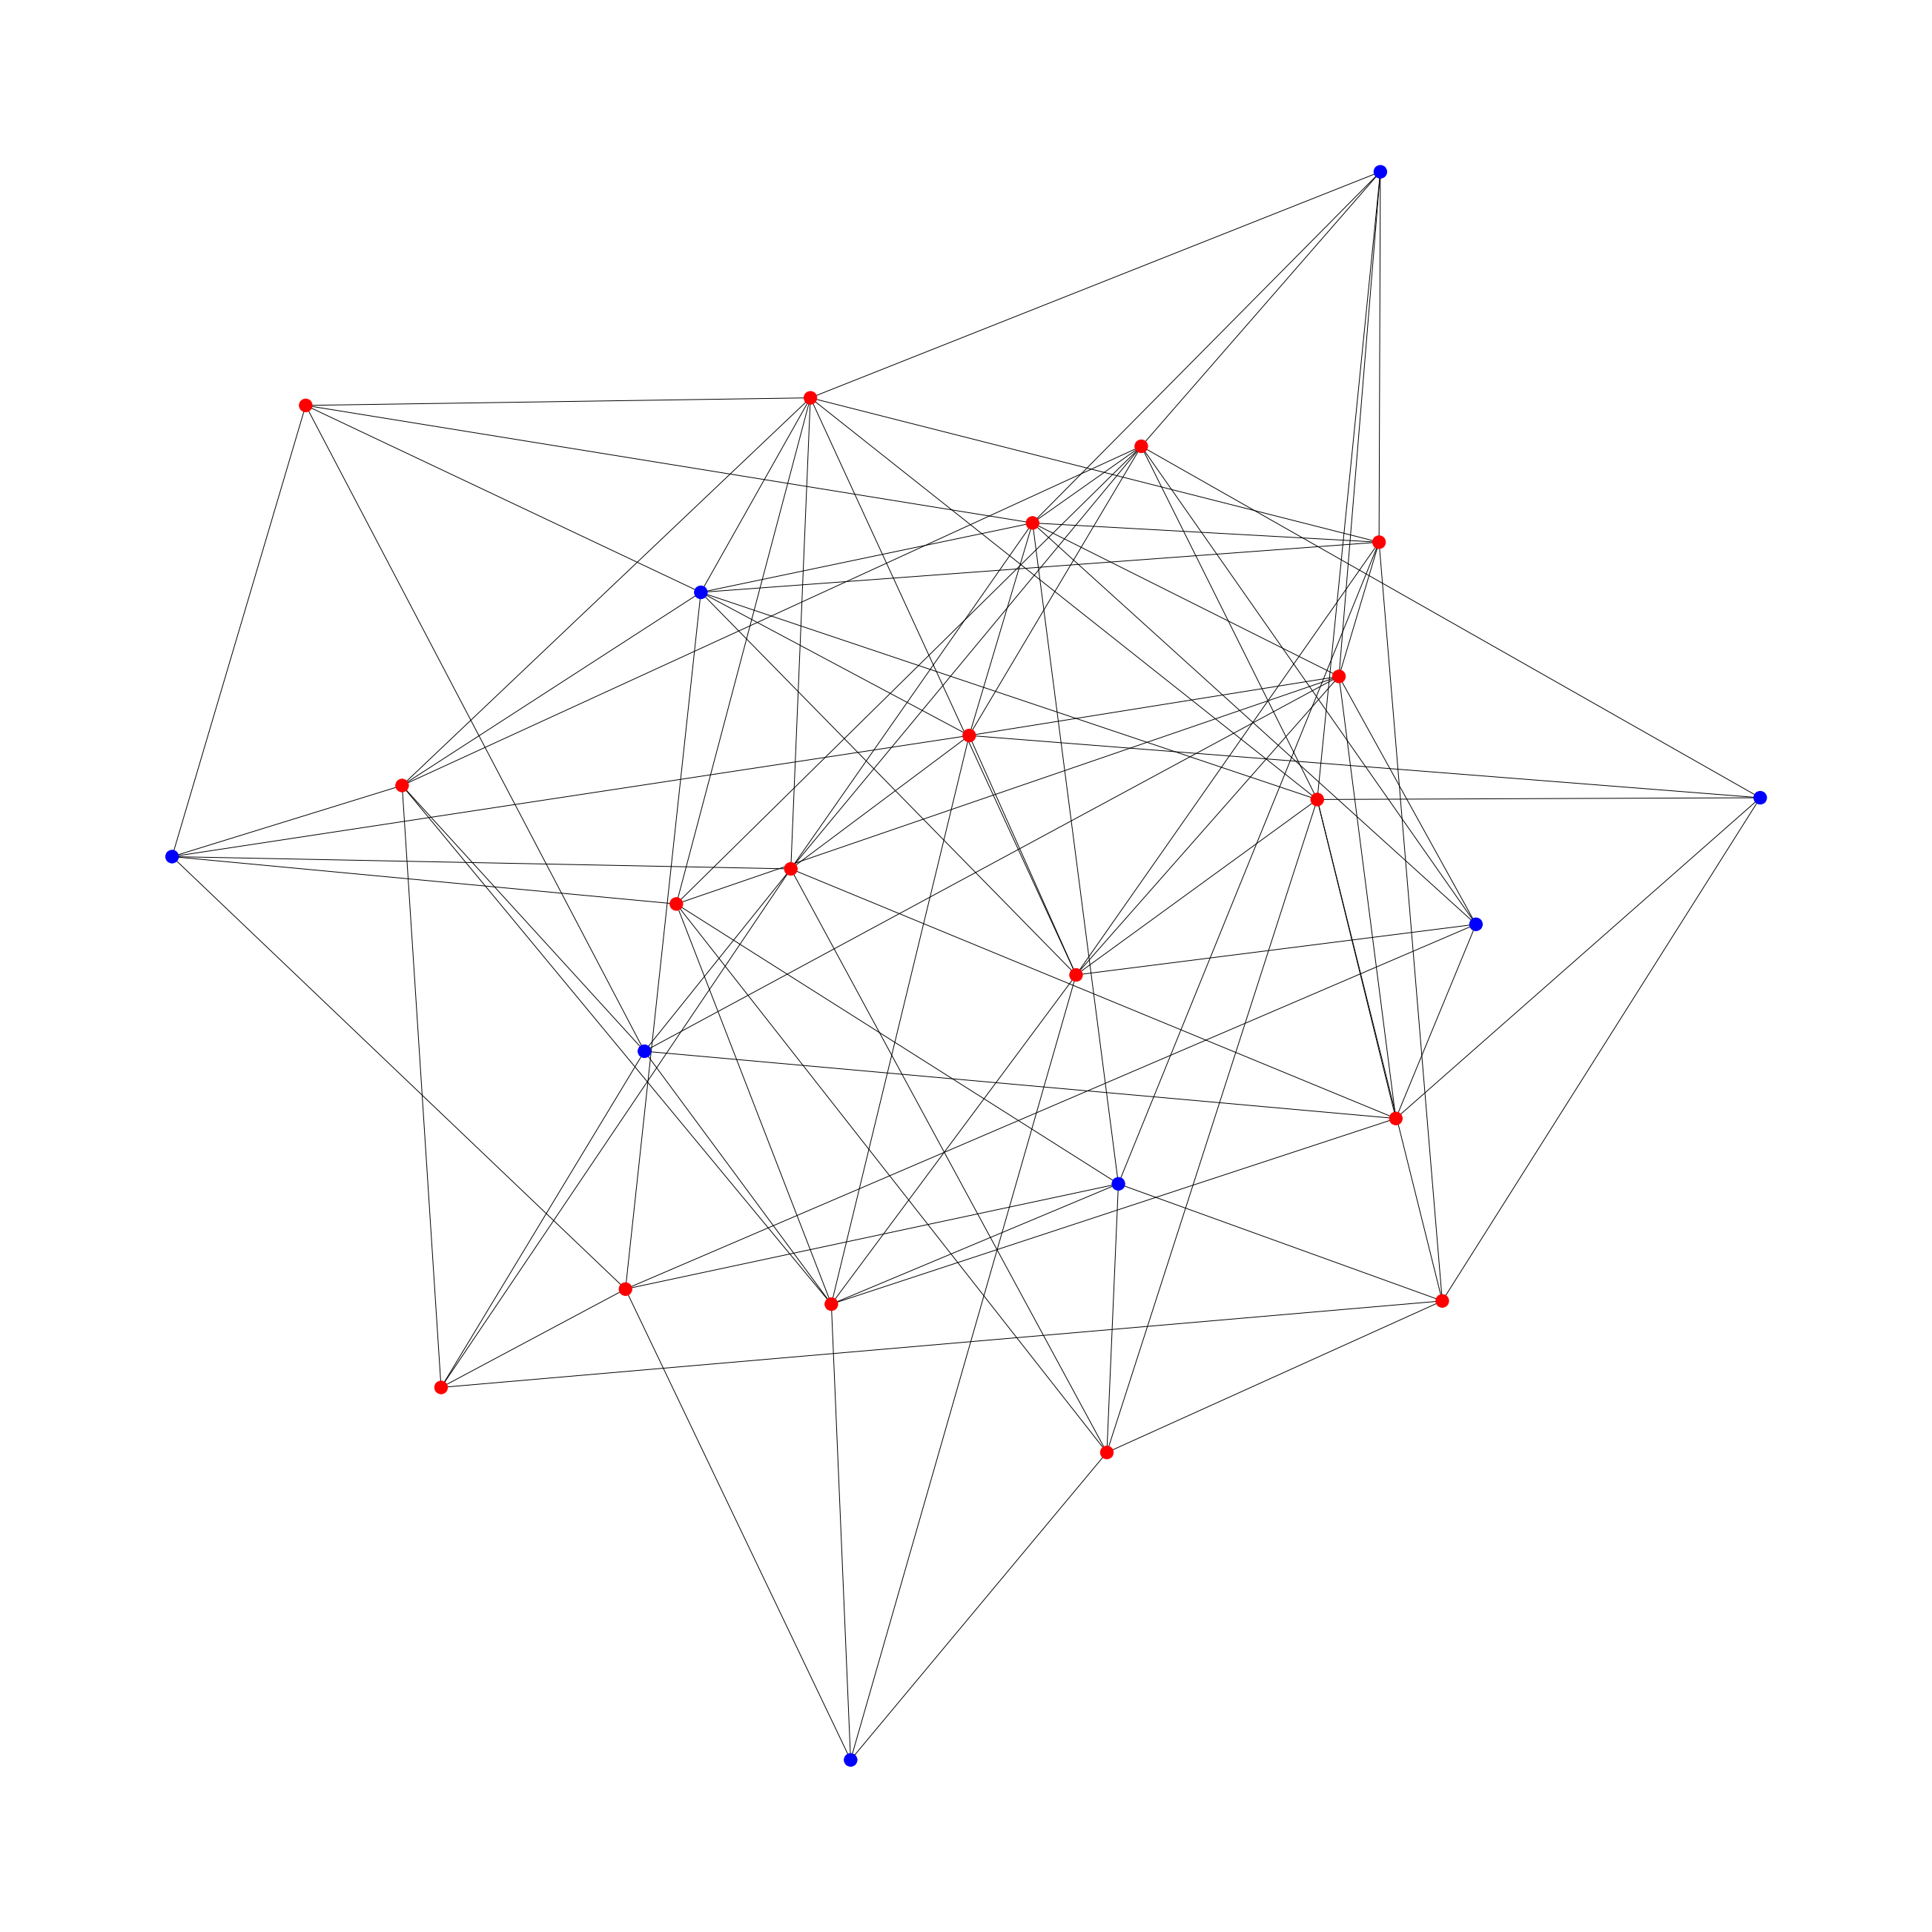

In [4]:
edges = [('A', 'W'), ('A', 'B'), ('A', 'E'), ('A', 'H'), ('A', 'M'),
         ('A', 'X'), ('B', 'G'), ('B', 'D'), ('B', 'K'), ('B', 'N'),
         ('C', 'Y'), ('C', 'G'), ('C', 'I'), ('C', 'J'), ('C', 'K'),
         ('C', 'M'), ('C', 'P'), ('C', 'R'), ('C', 'T'), ('D', 'Z'),
         ('D', 'G'), ('D', 'J'), ('D', 'K'), ('D', 'O'), ('D', 'Q'),
         ('E', 'K'), ('E', 'G'), ('E', 'I'), ('E', 'J'), ('E', 'U'),
         ('F', 'G'), ('F', 'H'), ('F', 'I'), ('F', 'N'), ('F', 'T'),
         ('F', 'X'), ('G', 'S'), ('G', 'Q'), ('G', 'U'), ('G', 'V'),
         ('H', 'Y'), ('H', 'Z'), ('I', 'X'), ('I', 'O'), ('I', 'S'),
         ('I', 'Z'), ('J', 'V'), ('J', 'M'), ('K', 'Z'), ('K', 'M'),
         ('K', 'S'), ('L', 'S'), ('L', 'N'), ('L', 'Q'), ('L', 'T'),
         ('L', 'U'), ('M', 'R'), ('M', 'T'), ('M', 'U'), ('M', 'V'),
         ('M', 'Y'), ('N', 'R'), ('N', 'T'), ('N', 'X'), ('O', 'Y'),
         ('O', 'P'), ('O', 'Q'), ('O', 'R'), ('O', 'U'), ('O', 'V'),
         ('O', 'W'), ('P', 'V'), ('P', 'R'), ('P', 'S'), ('P', 'T'),
         ('Q', 'W'), ('Q', 'T'), ('Q', 'Z'), ('R', 'X'), ('R', 'V'),
         ('R', 'Y'), ('S', 'W'), ('S', 'T'), ('S', 'U'), ('S', 'V'),
         ('T', 'Y'), ('U', 'V'), ('U', 'Y'), ('U', 'Z'), ('V', 'X'),
         ('V', 'W'), ('W', 'Y'), ('X', 'Z'), ('Y', 'Z')]

aco_1 = AntColonyOptimizer(edges, ants=100, evaporation_rate=0.1, intensification=0.3, alpha=0.4, beta=0.8, tmax=100)
aco_1.fit()

C:\Users\Johann\AppData\Local\Temp\ipykernel_15828\1698119182.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.adj_matrix = nx.adjacency_matrix(self.graph).todense()


Iteration 1/50: Best Score = 194, Global Best Score = 194
Iteration 2/50: Best Score = 191, Global Best Score = 191
Iteration 3/50: Best Score = 193, Global Best Score = 191
Iteration 4/50: Best Score = 192, Global Best Score = 191
Iteration 5/50: Best Score = 194, Global Best Score = 191
Iteration 6/50: Best Score = 193, Global Best Score = 191
Iteration 7/50: Best Score = 193, Global Best Score = 191
Iteration 8/50: Best Score = 193, Global Best Score = 191
Iteration 9/50: Best Score = 193, Global Best Score = 191
Iteration 10/50: Best Score = 193, Global Best Score = 191
Iteration 11/50: Best Score = 192, Global Best Score = 191
Iteration 12/50: Best Score = 193, Global Best Score = 191
Iteration 13/50: Best Score = 193, Global Best Score = 191
Iteration 14/50: Best Score = 191, Global Best Score = 191
Iteration 15/50: Best Score = 191, Global Best Score = 191
Iteration 16/50: Best Score = 193, Global Best Score = 191
Iteration 17/50: Best Score = 193, Global Best Score = 191
Iterat

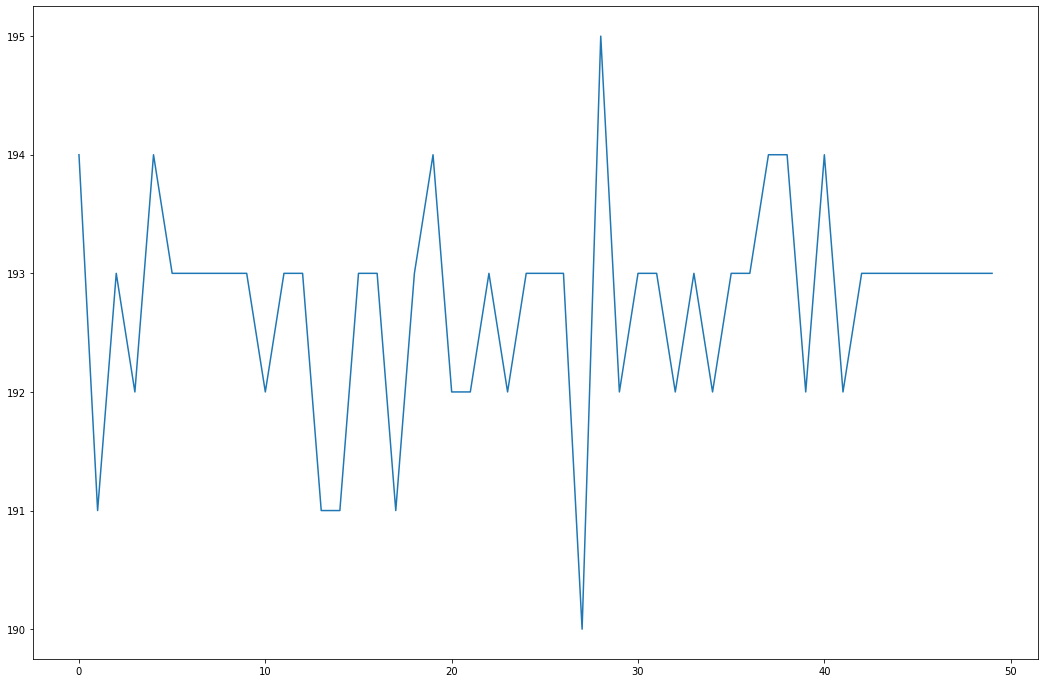

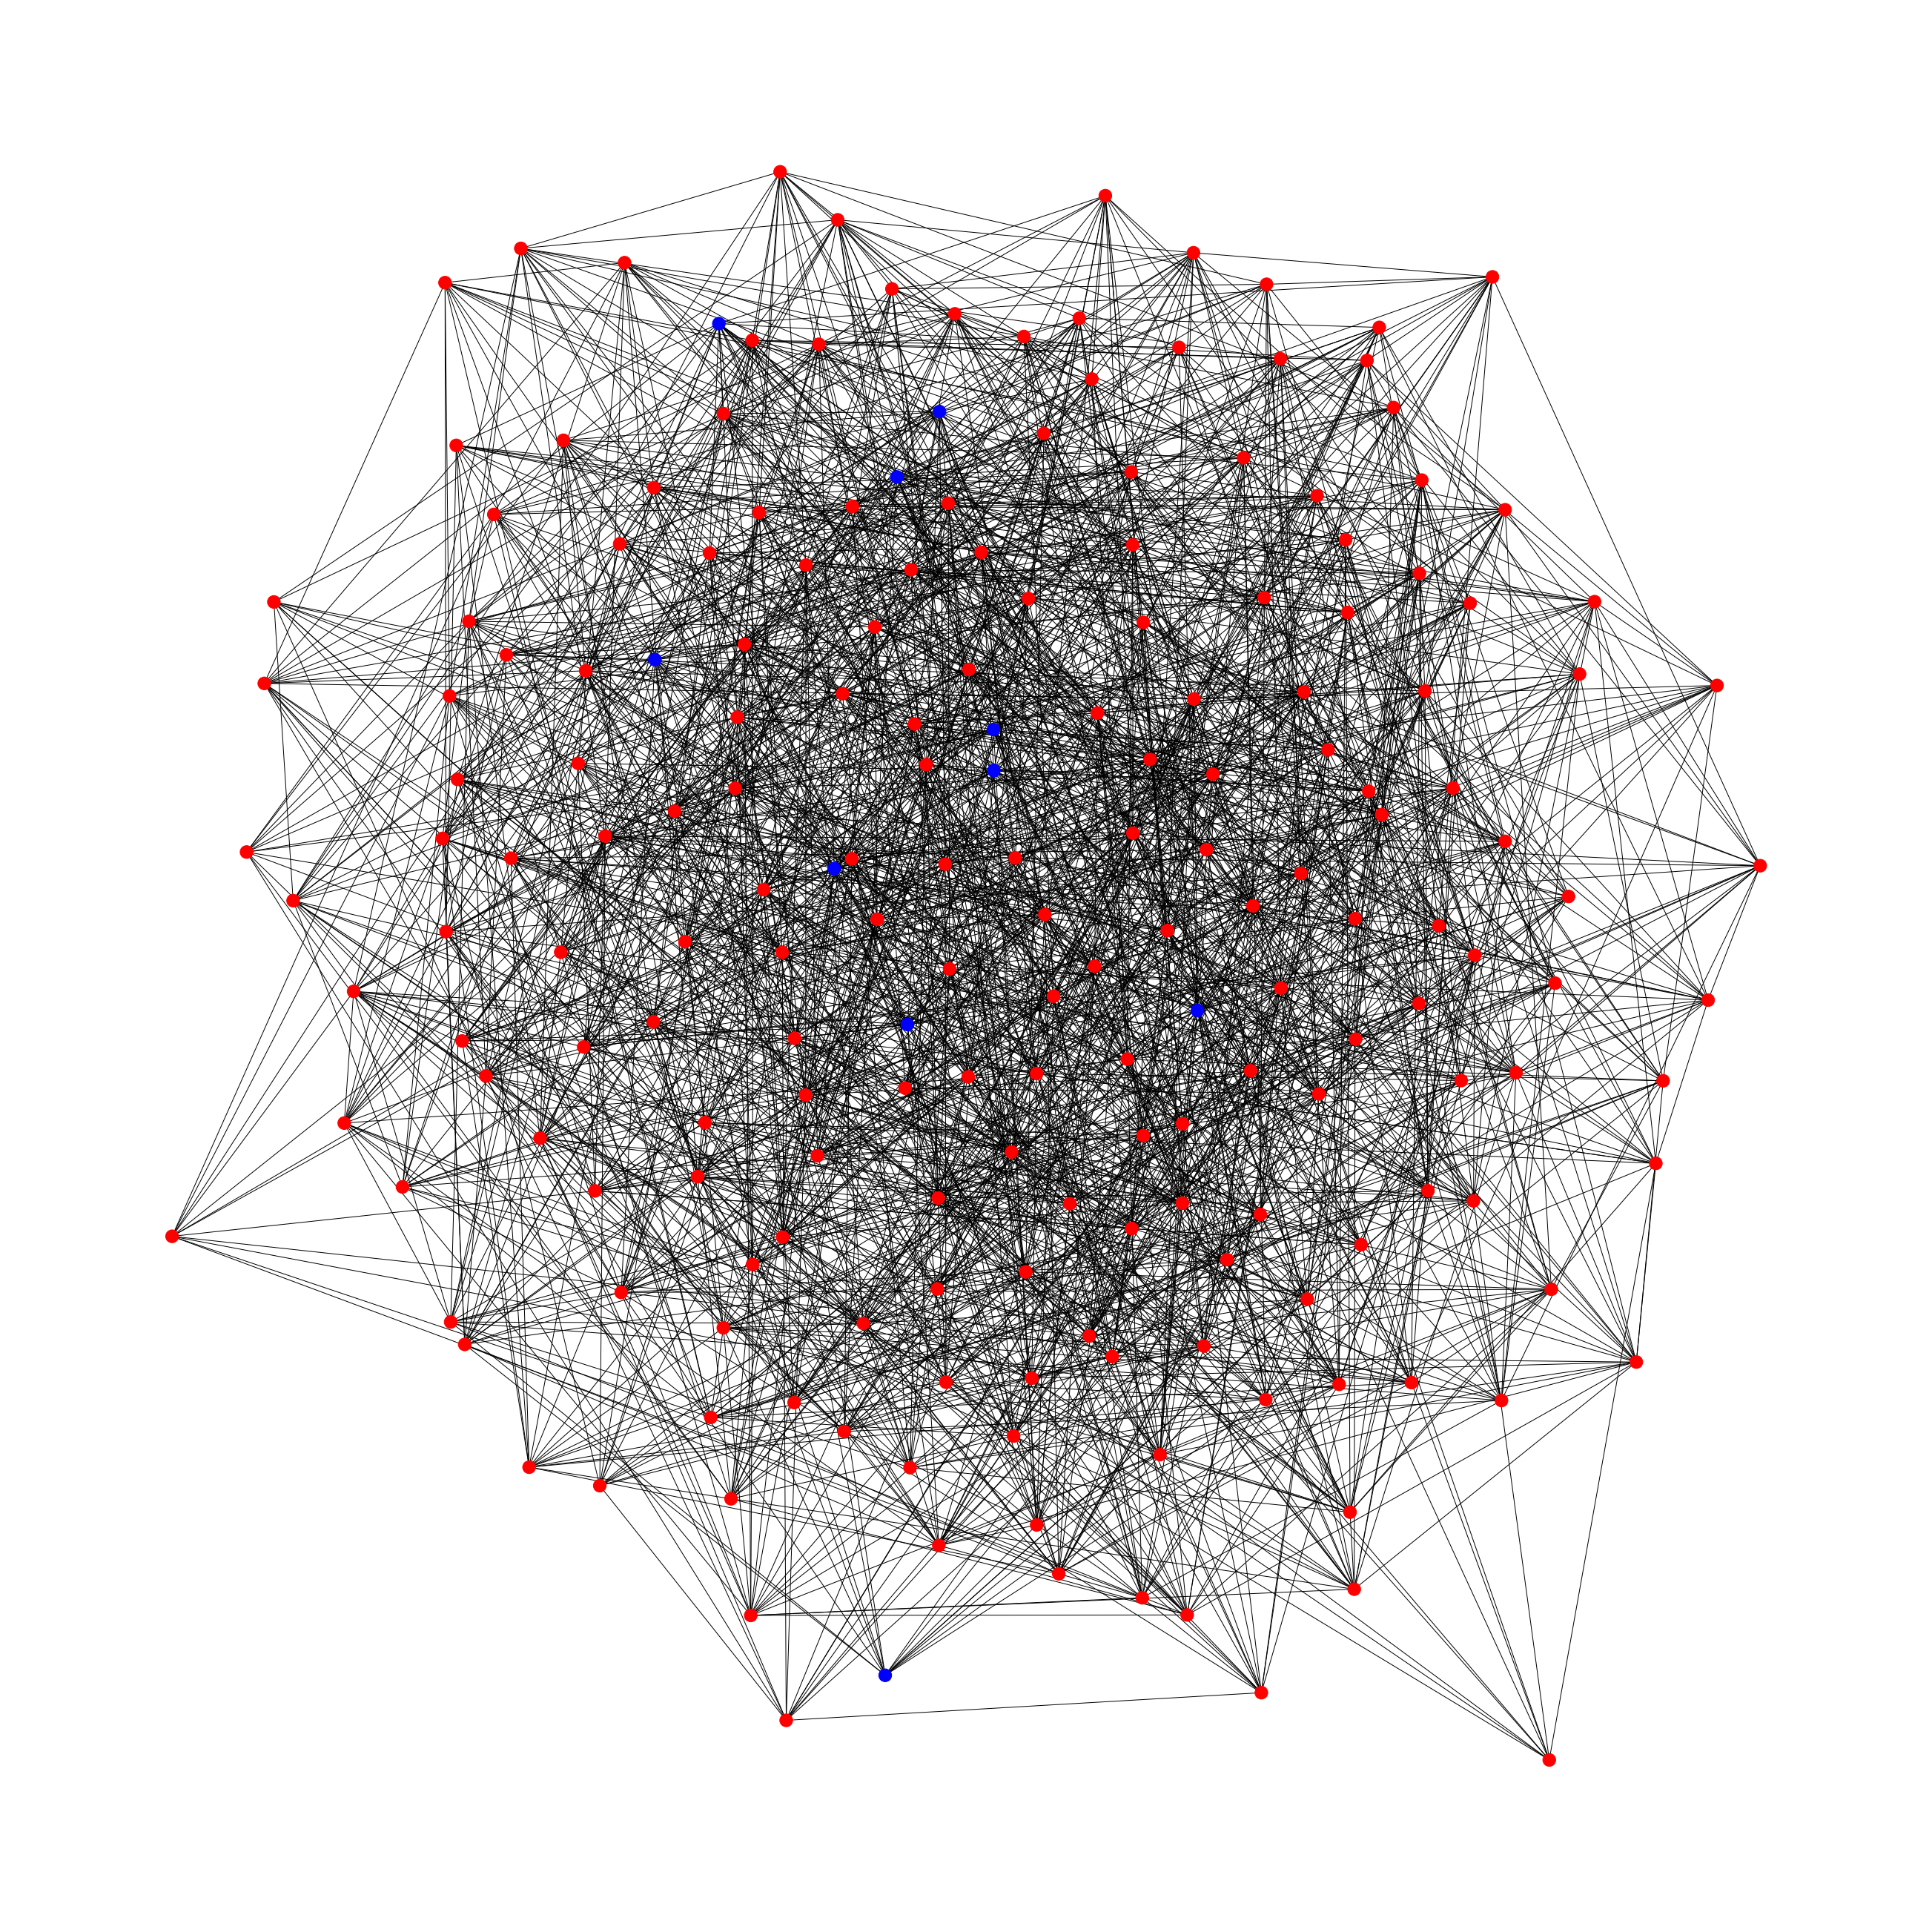

In [31]:
edges = [('e52ec25f-33e1-47e6-b9a7-83b3162aca91', 'fc3d169f-cd0f-42a9-9ea1-53d5c8f9733c'), ('e52ec25f-33e1-47e6-b9a7-83b3162aca91', 'a9f11e17-b450-47cf-8962-01da3080c912'), ('e52ec25f-33e1-47e6-b9a7-83b3162aca91', 'ae6291fb-911f-437d-be70-16a8a9c156da'), ('e52ec25f-33e1-47e6-b9a7-83b3162aca91', '7e1ec431-8ee0-4305-afeb-e24bab51e784'), ('e52ec25f-33e1-47e6-b9a7-83b3162aca91', '3b95899c-d27b-44b5-8fb0-b529396a6f85'), ('e52ec25f-33e1-47e6-b9a7-83b3162aca91', '1f3368ee-a5df-4c3e-adff-4418cb115786'), ('e52ec25f-33e1-47e6-b9a7-83b3162aca91', '7a68cc96-4414-4147-b023-7f1a3afd52ba'), ('e52ec25f-33e1-47e6-b9a7-83b3162aca91', 'd18d43f3-ae94-4145-928a-1a203c5e5eb8'), ('e52ec25f-33e1-47e6-b9a7-83b3162aca91', 'c1b7d29c-9e7b-496b-8987-ec315e4f1bb0'), ('e52ec25f-33e1-47e6-b9a7-83b3162aca91', '46a0a68e-e321-46df-8ab0-5866b63533c5'), ('e52ec25f-33e1-47e6-b9a7-83b3162aca91', '38b1c7db-02ab-4dee-8cbf-ab933560a37d'), ('e52ec25f-33e1-47e6-b9a7-83b3162aca91', 'a4f9cd25-d9e1-481f-af0d-54bad0d70a3f'), ('e52ec25f-33e1-47e6-b9a7-83b3162aca91', '7b8842ff-dbe9-4e74-858b-051d605ae7be'), ('e52ec25f-33e1-47e6-b9a7-83b3162aca91', '248f819c-f236-49c5-ba02-4e50a104ce1c'), ('e52ec25f-33e1-47e6-b9a7-83b3162aca91', '47a15769-cc40-4473-a46e-6d8c72732334'), ('e52ec25f-33e1-47e6-b9a7-83b3162aca91', '2fbfcee8-a430-4473-9d42-2ea9afb502cf'), ('e52ec25f-33e1-47e6-b9a7-83b3162aca91', 'c1258424-2284-4bea-892d-afcb9b988e45'), ('e52ec25f-33e1-47e6-b9a7-83b3162aca91', '9bd21a97-1f97-40d4-b329-d4f97010b89a'), ('e52ec25f-33e1-47e6-b9a7-83b3162aca91', 'e6ca8a13-cf86-4108-8b32-8d363322ef7e'), ('e52ec25f-33e1-47e6-b9a7-83b3162aca91', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('e52ec25f-33e1-47e6-b9a7-83b3162aca91', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('5d54c018-5342-40f3-8b4e-76be49c6e252', '9531c1ca-cbbe-4557-9fc6-9fc49f992b6e'), ('5d54c018-5342-40f3-8b4e-76be49c6e252', 'b11f78c8-ebb5-40c4-8348-7e6980e9d4fa'), ('5d54c018-5342-40f3-8b4e-76be49c6e252', '56f99de7-79fc-448e-8c0e-867e705507a1'), ('5d54c018-5342-40f3-8b4e-76be49c6e252', '1f3368ee-a5df-4c3e-adff-4418cb115786'), ('5d54c018-5342-40f3-8b4e-76be49c6e252', 'd2248cac-79c8-40c0-b24b-b3f9abab9210'), ('5d54c018-5342-40f3-8b4e-76be49c6e252', '994942fb-270f-4d34-866a-cf676f9d5e3e'), ('5d54c018-5342-40f3-8b4e-76be49c6e252', 'da5b6b71-a012-47b5-85f2-96d153c4c376'), ('5d54c018-5342-40f3-8b4e-76be49c6e252', '8a6519f6-a46b-4350-8842-7c15927daf83'), ('5d54c018-5342-40f3-8b4e-76be49c6e252', '6b5251b0-a241-4671-86bd-40c7fe7b1f83'), ('5d54c018-5342-40f3-8b4e-76be49c6e252', '04d72bf2-40d9-4979-9cc7-adf3f2e722fe'), ('5d54c018-5342-40f3-8b4e-76be49c6e252', 'f5750b1a-0613-4b45-9e14-05d291dbefeb'), ('5d54c018-5342-40f3-8b4e-76be49c6e252', 'b20a687c-f49f-4716-a163-4b0bb34507b9'), ('5d54c018-5342-40f3-8b4e-76be49c6e252', 'eece6073-a288-4e10-ab0b-8d16ed810e12'), ('5d54c018-5342-40f3-8b4e-76be49c6e252', 'e2ca7b07-9068-4284-a6a0-285b4c831e6e'), ('5d54c018-5342-40f3-8b4e-76be49c6e252', 'd8e64814-e685-4f8d-9332-ad4adf8489c7'), ('5d54c018-5342-40f3-8b4e-76be49c6e252', 'e9ed795e-3850-490e-ade4-21060d64cb65'), ('5d54c018-5342-40f3-8b4e-76be49c6e252', '924b7946-264d-4134-9072-1c4e64f9565b'), ('5d54c018-5342-40f3-8b4e-76be49c6e252', '0744b290-52eb-4570-8282-5198f1e7808f'), ('70f4b6f3-4420-4dad-aeb9-2a59f826c97a', '76f353cb-a726-4381-8433-75ff23ca0f24'), ('70f4b6f3-4420-4dad-aeb9-2a59f826c97a', 'b11f78c8-ebb5-40c4-8348-7e6980e9d4fa'), ('70f4b6f3-4420-4dad-aeb9-2a59f826c97a', '3eeb9eed-eee4-469c-8c36-c8219bd0e8ee'), ('70f4b6f3-4420-4dad-aeb9-2a59f826c97a', 'a129f694-3e56-4e4f-9680-9eb074aae93b'), ('70f4b6f3-4420-4dad-aeb9-2a59f826c97a', '0c8cb850-7675-418e-b656-5c4496d011b6'), ('70f4b6f3-4420-4dad-aeb9-2a59f826c97a', '280a96d5-88a2-4890-a4ec-c3bc00f7ad9b'), ('70f4b6f3-4420-4dad-aeb9-2a59f826c97a', 'd33fead6-783e-4c85-9ade-60f48a5180a9'), ('70f4b6f3-4420-4dad-aeb9-2a59f826c97a', '2da555b0-b3fe-460c-ad89-606f43afa11f'), ('70f4b6f3-4420-4dad-aeb9-2a59f826c97a', '34ca5b24-d930-4efe-9a06-cd8e36d6e867'), ('70f4b6f3-4420-4dad-aeb9-2a59f826c97a', 'a070cc50-0611-4fc4-a59d-f50628790a05'), ('70f4b6f3-4420-4dad-aeb9-2a59f826c97a', '6b5251b0-a241-4671-86bd-40c7fe7b1f83'), ('70f4b6f3-4420-4dad-aeb9-2a59f826c97a', 'ac4bad87-894e-4a49-9712-9399efc833ab'), ('70f4b6f3-4420-4dad-aeb9-2a59f826c97a', '680ba090-7160-47b5-a430-d1c5041dea02'), ('70f4b6f3-4420-4dad-aeb9-2a59f826c97a', '07a0760d-9493-45bb-b0b4-06b422155244'), ('70f4b6f3-4420-4dad-aeb9-2a59f826c97a', '2fbfcee8-a430-4473-9d42-2ea9afb502cf'), ('70f4b6f3-4420-4dad-aeb9-2a59f826c97a', '95450d10-f36d-4cf1-a634-f46f4b6218fe'), ('70f4b6f3-4420-4dad-aeb9-2a59f826c97a', 'c71ad7cc-feef-40f8-b543-542b595d92e0'), ('70f4b6f3-4420-4dad-aeb9-2a59f826c97a', '0744b290-52eb-4570-8282-5198f1e7808f'), ('9993747e-4b12-433d-a965-731c48bc8021', 'ee2d0378-5ca5-4b20-8123-0885ec8deb12'), ('9993747e-4b12-433d-a965-731c48bc8021', '2add7eb4-c6e7-4e2d-a105-464173c2c617'), ('9993747e-4b12-433d-a965-731c48bc8021', 'f8fe13af-a56a-4d27-bab2-9f05cf6f3ebb'), ('9993747e-4b12-433d-a965-731c48bc8021', 'a129f694-3e56-4e4f-9680-9eb074aae93b'), ('9993747e-4b12-433d-a965-731c48bc8021', '0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e'), ('9993747e-4b12-433d-a965-731c48bc8021', 'd4cd8f51-d321-454c-bf3d-cc1c2a1654c6'), ('9993747e-4b12-433d-a965-731c48bc8021', 'd12b45f7-ab1b-4966-9b8c-c312ba20baaa'), ('9993747e-4b12-433d-a965-731c48bc8021', 'c1b7d29c-9e7b-496b-8987-ec315e4f1bb0'), ('9993747e-4b12-433d-a965-731c48bc8021', 'c19e7863-60ef-4dca-9cc2-171195153627'), ('9993747e-4b12-433d-a965-731c48bc8021', 'dcfc2bab-30c0-4407-a42a-9890822cd6f3'), ('9993747e-4b12-433d-a965-731c48bc8021', '7ec37593-0425-4d38-b35e-a66a26c43eab'), ('9993747e-4b12-433d-a965-731c48bc8021', 'eae45e05-43ff-475d-9a44-d0a1f7c7844a'), ('9993747e-4b12-433d-a965-731c48bc8021', '04d72bf2-40d9-4979-9cc7-adf3f2e722fe'), ('9993747e-4b12-433d-a965-731c48bc8021', '231a7f3a-ec6a-4171-a415-cd9070042713'), ('9993747e-4b12-433d-a965-731c48bc8021', 'a4f9cd25-d9e1-481f-af0d-54bad0d70a3f'), ('9993747e-4b12-433d-a965-731c48bc8021', '34211ee6-381e-41af-9c06-09c7b1af7abd'), ('9993747e-4b12-433d-a965-731c48bc8021', '3a60e740-5ee4-450f-9242-8e40bac5310b'), ('9993747e-4b12-433d-a965-731c48bc8021', '07a0760d-9493-45bb-b0b4-06b422155244'), ('9993747e-4b12-433d-a965-731c48bc8021', 'b532cde7-8e17-4eae-b02b-926a1d0f86b1'), ('9993747e-4b12-433d-a965-731c48bc8021', 'db6f3c35-948d-4c2f-b687-72fe261aa29c'), ('9993747e-4b12-433d-a965-731c48bc8021', 'cacf9cbe-c7ea-40e0-a346-56283f90f9a8'), ('9993747e-4b12-433d-a965-731c48bc8021', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('9993747e-4b12-433d-a965-731c48bc8021', '9bd21a97-1f97-40d4-b329-d4f97010b89a'), ('2add7eb4-c6e7-4e2d-a105-464173c2c617', '0da237b0-bfec-406c-b06b-344cd5c62ddd'), ('2add7eb4-c6e7-4e2d-a105-464173c2c617', '7679e93e-3b5c-4595-903e-1dac94d31fd3'), ('2add7eb4-c6e7-4e2d-a105-464173c2c617', '52b27600-af61-4f83-aeba-b4ec09cba0f7'), ('2add7eb4-c6e7-4e2d-a105-464173c2c617', 'f5d465b6-0311-4465-b15d-4565c2f00d79'), ('2add7eb4-c6e7-4e2d-a105-464173c2c617', '0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e'), ('2add7eb4-c6e7-4e2d-a105-464173c2c617', '1f3368ee-a5df-4c3e-adff-4418cb115786'), ('2add7eb4-c6e7-4e2d-a105-464173c2c617', '2da555b0-b3fe-460c-ad89-606f43afa11f'), ('2add7eb4-c6e7-4e2d-a105-464173c2c617', 'd12b45f7-ab1b-4966-9b8c-c312ba20baaa'), ('2add7eb4-c6e7-4e2d-a105-464173c2c617', 'f8d22186-1ae4-4aa7-9661-bcab92bb890c'), ('2add7eb4-c6e7-4e2d-a105-464173c2c617', 'b5e4b614-0574-497a-9b2f-2c799bc11fbf'), ('2add7eb4-c6e7-4e2d-a105-464173c2c617', 'a945b050-6dc2-494b-b95f-4a264145a7f9'), ('2add7eb4-c6e7-4e2d-a105-464173c2c617', '3f9f432e-7a99-4867-942b-5ec98d908f2e'), ('2add7eb4-c6e7-4e2d-a105-464173c2c617', '61b8102c-182a-4a71-81e8-f42424e79eae'), ('2add7eb4-c6e7-4e2d-a105-464173c2c617', '50f1c1da-e19f-4f21-b981-5b4ece4fc6ae'), ('2add7eb4-c6e7-4e2d-a105-464173c2c617', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('2add7eb4-c6e7-4e2d-a105-464173c2c617', '7eedf322-4e43-4805-b27c-058987706dd4'), ('2add7eb4-c6e7-4e2d-a105-464173c2c617', '924b7946-264d-4134-9072-1c4e64f9565b'), ('2add7eb4-c6e7-4e2d-a105-464173c2c617', '3afadd34-60be-4bbf-b7fa-eee631db75b0'), ('2add7eb4-c6e7-4e2d-a105-464173c2c617', 'a443cf42-5aa5-4649-8810-19b4993efb9d'), ('2add7eb4-c6e7-4e2d-a105-464173c2c617', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('2add7eb4-c6e7-4e2d-a105-464173c2c617', '13cdd06a-738f-440d-b434-3adfabf13435'), ('2add7eb4-c6e7-4e2d-a105-464173c2c617', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('d71ccccb-6061-4447-93ee-52c160f352a4', '52df458d-d6e4-4ff0-ad9f-74c0197eb045'), ('d71ccccb-6061-4447-93ee-52c160f352a4', 'a9f11e17-b450-47cf-8962-01da3080c912'), ('d71ccccb-6061-4447-93ee-52c160f352a4', 'e41f9ce5-3521-4dbd-bc4c-e000e7e2b43e'), ('d71ccccb-6061-4447-93ee-52c160f352a4', 'e265676d-cdc4-4d3c-84a7-de35369d6cc0'), ('d71ccccb-6061-4447-93ee-52c160f352a4', '05ce4d21-69ba-4b79-9400-f6cc95c65fc5'), ('d71ccccb-6061-4447-93ee-52c160f352a4', '2da555b0-b3fe-460c-ad89-606f43afa11f'), ('d71ccccb-6061-4447-93ee-52c160f352a4', '34ca5b24-d930-4efe-9a06-cd8e36d6e867'), ('d71ccccb-6061-4447-93ee-52c160f352a4', '0da237b0-bfec-406c-b06b-344cd5c62ddd'), ('d71ccccb-6061-4447-93ee-52c160f352a4', '5d56c8df-d12f-48b5-8a2f-c87021f958db'), ('d71ccccb-6061-4447-93ee-52c160f352a4', 'a7e81703-438c-4417-85b9-b208201ba9fc'), ('d71ccccb-6061-4447-93ee-52c160f352a4', '6f9ff275-2df7-432a-9024-8d8164b5b83e'), ('d71ccccb-6061-4447-93ee-52c160f352a4', 'dec47ffb-9086-45e6-9f7f-7576be559ed7'), ('d71ccccb-6061-4447-93ee-52c160f352a4', '34211ee6-381e-41af-9c06-09c7b1af7abd'), ('d71ccccb-6061-4447-93ee-52c160f352a4', '7a9503a8-1bf7-456b-be5d-d756b112416e'), ('d71ccccb-6061-4447-93ee-52c160f352a4', 'aa60ec33-0eab-4d6d-a7af-3d0d150340b3'), ('d71ccccb-6061-4447-93ee-52c160f352a4', '353d608a-efae-4d6c-9832-bb306e41f797'), ('d71ccccb-6061-4447-93ee-52c160f352a4', '5ce312bc-0cf7-419e-8a58-7dde52f7aa2b'), ('d71ccccb-6061-4447-93ee-52c160f352a4', '38f3ef53-59dd-408f-949d-9822923caf5e'), ('d71ccccb-6061-4447-93ee-52c160f352a4', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('d71ccccb-6061-4447-93ee-52c160f352a4', 'fc3d169f-cd0f-42a9-9ea1-53d5c8f9733c'), ('d71ccccb-6061-4447-93ee-52c160f352a4', 'c71ad7cc-feef-40f8-b543-542b595d92e0'), ('d71ccccb-6061-4447-93ee-52c160f352a4', '515e605b-3aba-4798-9af8-14379787d4d9'), ('a9f11e17-b450-47cf-8962-01da3080c912', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('a9f11e17-b450-47cf-8962-01da3080c912', 'ee2d0378-5ca5-4b20-8123-0885ec8deb12'), ('a9f11e17-b450-47cf-8962-01da3080c912', '52af53ea-39c4-4d83-a42d-a0dce7caabb4'), ('a9f11e17-b450-47cf-8962-01da3080c912', '37bf61dd-5292-47e1-95f9-f494eab37b6d'), ('a9f11e17-b450-47cf-8962-01da3080c912', '0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e'), ('a9f11e17-b450-47cf-8962-01da3080c912', '3b95899c-d27b-44b5-8fb0-b529396a6f85'), ('a9f11e17-b450-47cf-8962-01da3080c912', 'd6f92ffd-3888-42d7-bd7e-27e31c571477'), ('a9f11e17-b450-47cf-8962-01da3080c912', '0da237b0-bfec-406c-b06b-344cd5c62ddd'), ('a9f11e17-b450-47cf-8962-01da3080c912', 'dcfc2bab-30c0-4407-a42a-9890822cd6f3'), ('a9f11e17-b450-47cf-8962-01da3080c912', 'f8d22186-1ae4-4aa7-9661-bcab92bb890c'), ('a9f11e17-b450-47cf-8962-01da3080c912', 'a945b050-6dc2-494b-b95f-4a264145a7f9'), ('a9f11e17-b450-47cf-8962-01da3080c912', '231a7f3a-ec6a-4171-a415-cd9070042713'), ('a9f11e17-b450-47cf-8962-01da3080c912', '3f9f432e-7a99-4867-942b-5ec98d908f2e'), ('a9f11e17-b450-47cf-8962-01da3080c912', '353d608a-efae-4d6c-9832-bb306e41f797'), ('a9f11e17-b450-47cf-8962-01da3080c912', 'e9917487-b18e-4cc6-8c11-959d625bfec1'), ('a9f11e17-b450-47cf-8962-01da3080c912', 'd3c074ec-9b10-4498-8e62-d5c2b9b6c701'), ('a9f11e17-b450-47cf-8962-01da3080c912', 'a01a9bb5-16fe-4883-b96f-d8e6228f5154'), ('a9f11e17-b450-47cf-8962-01da3080c912', 'cacf9cbe-c7ea-40e0-a346-56283f90f9a8'), ('a9f11e17-b450-47cf-8962-01da3080c912', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('a9f11e17-b450-47cf-8962-01da3080c912', 'e6ca8a13-cf86-4108-8b32-8d363322ef7e'), ('a9f11e17-b450-47cf-8962-01da3080c912', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('8f6fa14b-0d02-4e18-9204-c20fc535242b', '43d62019-c50c-4cc7-9576-ddc285e62c12'), ('8f6fa14b-0d02-4e18-9204-c20fc535242b', '4bf11be9-9bea-4958-a1e0-b90583be1318'), ('8f6fa14b-0d02-4e18-9204-c20fc535242b', '3eeb9eed-eee4-469c-8c36-c8219bd0e8ee'), ('8f6fa14b-0d02-4e18-9204-c20fc535242b', '748323b3-5943-4e0e-b9c0-c577110bbd35'), ('8f6fa14b-0d02-4e18-9204-c20fc535242b', '75362bdd-e3ab-4eb0-a559-f15bef116a7d'), ('8f6fa14b-0d02-4e18-9204-c20fc535242b', '066dabbe-6f51-43a5-9b9d-ad253d845bd1'), ('8f6fa14b-0d02-4e18-9204-c20fc535242b', '52b27600-af61-4f83-aeba-b4ec09cba0f7'), ('8f6fa14b-0d02-4e18-9204-c20fc535242b', '7e1ec431-8ee0-4305-afeb-e24bab51e784'), ('8f6fa14b-0d02-4e18-9204-c20fc535242b', 'f5d465b6-0311-4465-b15d-4565c2f00d79'), ('8f6fa14b-0d02-4e18-9204-c20fc535242b', '35b93d12-7d89-4050-a2da-e48746f65124'), ('8f6fa14b-0d02-4e18-9204-c20fc535242b', 'c1b7d29c-9e7b-496b-8987-ec315e4f1bb0'), ('8f6fa14b-0d02-4e18-9204-c20fc535242b', 'f8d22186-1ae4-4aa7-9661-bcab92bb890c'), ('8f6fa14b-0d02-4e18-9204-c20fc535242b', '6b5251b0-a241-4671-86bd-40c7fe7b1f83'), ('8f6fa14b-0d02-4e18-9204-c20fc535242b', '61b8102c-182a-4a71-81e8-f42424e79eae'), ('8f6fa14b-0d02-4e18-9204-c20fc535242b', '10a8c439-5f86-4ba6-a47a-6036cfb6093b'), ('8f6fa14b-0d02-4e18-9204-c20fc535242b', '2fbfcee8-a430-4473-9d42-2ea9afb502cf'), ('8f6fa14b-0d02-4e18-9204-c20fc535242b', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('8f6fa14b-0d02-4e18-9204-c20fc535242b', 'd5a3cc54-aaad-404a-833c-e624abacf8e0'), ('8f6fa14b-0d02-4e18-9204-c20fc535242b', '7397c5bf-0b76-4d98-9d73-67de31e753e0'), ('8f6fa14b-0d02-4e18-9204-c20fc535242b', '515e605b-3aba-4798-9af8-14379787d4d9'), ('8f6fa14b-0d02-4e18-9204-c20fc535242b', 'ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28'), ('b11f78c8-ebb5-40c4-8348-7e6980e9d4fa', 'fc3d169f-cd0f-42a9-9ea1-53d5c8f9733c'), ('b11f78c8-ebb5-40c4-8348-7e6980e9d4fa', '8c35f5b4-8d0a-4b28-b5c5-5dbb243c9822'), ('b11f78c8-ebb5-40c4-8348-7e6980e9d4fa', 'd18d43f3-ae94-4145-928a-1a203c5e5eb8'), ('b11f78c8-ebb5-40c4-8348-7e6980e9d4fa', '0e95fa8a-26ee-45ca-93f4-4811e38ff2b8'), ('b11f78c8-ebb5-40c4-8348-7e6980e9d4fa', '9531c1ca-cbbe-4557-9fc6-9fc49f992b6e'), ('b11f78c8-ebb5-40c4-8348-7e6980e9d4fa', '6d7b1f02-e22a-4828-94e1-875659ec1156'), ('b11f78c8-ebb5-40c4-8348-7e6980e9d4fa', 'f108be63-8fb6-436c-8057-a0192cfacc35'), ('b11f78c8-ebb5-40c4-8348-7e6980e9d4fa', 'ad1c0b2d-a824-4967-8fde-24c8deddd99d'), ('b11f78c8-ebb5-40c4-8348-7e6980e9d4fa', 'e9917487-b18e-4cc6-8c11-959d625bfec1'), ('b11f78c8-ebb5-40c4-8348-7e6980e9d4fa', 'a51bfa83-91d3-4194-ac60-2c64a500d304'), ('b11f78c8-ebb5-40c4-8348-7e6980e9d4fa', 'd5a3cc54-aaad-404a-833c-e624abacf8e0'), ('b11f78c8-ebb5-40c4-8348-7e6980e9d4fa', '157af6c5-4c06-4a31-b9c4-274b16965c6d'), ('b11f78c8-ebb5-40c4-8348-7e6980e9d4fa', 'efbca825-5e1a-42b8-8791-df22dded8ce5'), ('b11f78c8-ebb5-40c4-8348-7e6980e9d4fa', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('b11f78c8-ebb5-40c4-8348-7e6980e9d4fa', 'ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28'), ('8de365e7-eb1f-4a35-a2f3-9accfd8d4c71', 'b532cde7-8e17-4eae-b02b-926a1d0f86b1'), ('8de365e7-eb1f-4a35-a2f3-9accfd8d4c71', '76f353cb-a726-4381-8433-75ff23ca0f24'), ('8de365e7-eb1f-4a35-a2f3-9accfd8d4c71', '75362bdd-e3ab-4eb0-a559-f15bef116a7d'), ('8de365e7-eb1f-4a35-a2f3-9accfd8d4c71', '771952f0-ab8c-4ef7-b5c4-d67c4c99d23a'), ('8de365e7-eb1f-4a35-a2f3-9accfd8d4c71', 'a129f694-3e56-4e4f-9680-9eb074aae93b'), ('8de365e7-eb1f-4a35-a2f3-9accfd8d4c71', 'ec3551c8-183e-4ad8-aaec-2a0201522623'), ('8de365e7-eb1f-4a35-a2f3-9accfd8d4c71', 'd6408589-3709-4adf-a697-59adac8d5af7'), ('8de365e7-eb1f-4a35-a2f3-9accfd8d4c71', '9f1677c1-3a6f-48a0-898e-b3eb5b6480e0'), ('8de365e7-eb1f-4a35-a2f3-9accfd8d4c71', '0da237b0-bfec-406c-b06b-344cd5c62ddd'), ('8de365e7-eb1f-4a35-a2f3-9accfd8d4c71', '7ec37593-0425-4d38-b35e-a66a26c43eab'), ('8de365e7-eb1f-4a35-a2f3-9accfd8d4c71', '04d72bf2-40d9-4979-9cc7-adf3f2e722fe'), ('8de365e7-eb1f-4a35-a2f3-9accfd8d4c71', 'ee949467-1274-4e75-8e72-4e9e1d196a00'), ('8de365e7-eb1f-4a35-a2f3-9accfd8d4c71', '61b8102c-182a-4a71-81e8-f42424e79eae'), ('8de365e7-eb1f-4a35-a2f3-9accfd8d4c71', '47a15769-cc40-4473-a46e-6d8c72732334'), ('8de365e7-eb1f-4a35-a2f3-9accfd8d4c71', '07a0760d-9493-45bb-b0b4-06b422155244'), ('8de365e7-eb1f-4a35-a2f3-9accfd8d4c71', 'a9744826-ee7d-4fbe-8a78-1f96b5835821'), ('8de365e7-eb1f-4a35-a2f3-9accfd8d4c71', '93a3ef66-50b0-4df0-8427-10e3e4eeee04'), ('8de365e7-eb1f-4a35-a2f3-9accfd8d4c71', '0cc5b235-531d-4524-af06-b01b709c2779'), ('8de365e7-eb1f-4a35-a2f3-9accfd8d4c71', 'd8e64814-e685-4f8d-9332-ad4adf8489c7'), ('7679e93e-3b5c-4595-903e-1dac94d31fd3', '38f3ef53-59dd-408f-949d-9822923caf5e'), ('7679e93e-3b5c-4595-903e-1dac94d31fd3', '52b27600-af61-4f83-aeba-b4ec09cba0f7'), ('7679e93e-3b5c-4595-903e-1dac94d31fd3', '52af53ea-39c4-4d83-a42d-a0dce7caabb4'), ('7679e93e-3b5c-4595-903e-1dac94d31fd3', '56f99de7-79fc-448e-8c0e-867e705507a1'), ('7679e93e-3b5c-4595-903e-1dac94d31fd3', '29047ba9-37bc-4a25-b31e-aafa57093044'), ('7679e93e-3b5c-4595-903e-1dac94d31fd3', '4f13544d-84af-47cb-85c8-ea76ea72fee3'), ('7679e93e-3b5c-4595-903e-1dac94d31fd3', '5d56c8df-d12f-48b5-8a2f-c87021f958db'), ('7679e93e-3b5c-4595-903e-1dac94d31fd3', 'aab58533-9390-4266-8208-b401ba1d4337'), ('7679e93e-3b5c-4595-903e-1dac94d31fd3', '0d088a72-c626-4c48-b1db-25e4c3bd2318'), ('7679e93e-3b5c-4595-903e-1dac94d31fd3', 'a7e81703-438c-4417-85b9-b208201ba9fc'), ('7679e93e-3b5c-4595-903e-1dac94d31fd3', '7ec37593-0425-4d38-b35e-a66a26c43eab'), ('7679e93e-3b5c-4595-903e-1dac94d31fd3', 'aa60ec33-0eab-4d6d-a7af-3d0d150340b3'), ('7679e93e-3b5c-4595-903e-1dac94d31fd3', '52df458d-d6e4-4ff0-ad9f-74c0197eb045'), ('7679e93e-3b5c-4595-903e-1dac94d31fd3', '77444122-e23e-4453-8db1-d4a73b7d5622'), ('7679e93e-3b5c-4595-903e-1dac94d31fd3', '524cc917-4625-43fb-9a2b-72d821b0f9d1'), ('7679e93e-3b5c-4595-903e-1dac94d31fd3', 'a51bfa83-91d3-4194-ac60-2c64a500d304'), ('7679e93e-3b5c-4595-903e-1dac94d31fd3', 'ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28'), ('7679e93e-3b5c-4595-903e-1dac94d31fd3', '0744b290-52eb-4570-8282-5198f1e7808f'), ('4bf11be9-9bea-4958-a1e0-b90583be1318', 'c1b015a8-6f0f-4ba9-a1c4-c1d16b380999'), ('4bf11be9-9bea-4958-a1e0-b90583be1318', 'ec3551c8-183e-4ad8-aaec-2a0201522623'), ('4bf11be9-9bea-4958-a1e0-b90583be1318', '56f99de7-79fc-448e-8c0e-867e705507a1'), ('4bf11be9-9bea-4958-a1e0-b90583be1318', '1f3368ee-a5df-4c3e-adff-4418cb115786'), ('4bf11be9-9bea-4958-a1e0-b90583be1318', 'd4cd8f51-d321-454c-bf3d-cc1c2a1654c6'), ('4bf11be9-9bea-4958-a1e0-b90583be1318', '02921837-1a1e-4440-ab19-83c7e931faad'), ('4bf11be9-9bea-4958-a1e0-b90583be1318', '0e95fa8a-26ee-45ca-93f4-4811e38ff2b8'), ('4bf11be9-9bea-4958-a1e0-b90583be1318', '9e89f215-58b7-4961-9e83-c8970e1e2a7e'), ('4bf11be9-9bea-4958-a1e0-b90583be1318', 'da5b6b71-a012-47b5-85f2-96d153c4c376'), ('4bf11be9-9bea-4958-a1e0-b90583be1318', 'a7e81703-438c-4417-85b9-b208201ba9fc'), ('4bf11be9-9bea-4958-a1e0-b90583be1318', '7ec37593-0425-4d38-b35e-a66a26c43eab'), ('4bf11be9-9bea-4958-a1e0-b90583be1318', 'b5e4b614-0574-497a-9b2f-2c799bc11fbf'), ('4bf11be9-9bea-4958-a1e0-b90583be1318', 'dec47ffb-9086-45e6-9f7f-7576be559ed7'), ('4bf11be9-9bea-4958-a1e0-b90583be1318', '353d608a-efae-4d6c-9832-bb306e41f797'), ('4bf11be9-9bea-4958-a1e0-b90583be1318', 'e9917487-b18e-4cc6-8c11-959d625bfec1'), ('4bf11be9-9bea-4958-a1e0-b90583be1318', '248f819c-f236-49c5-ba02-4e50a104ce1c'), ('4bf11be9-9bea-4958-a1e0-b90583be1318', 'b532cde7-8e17-4eae-b02b-926a1d0f86b1'), ('4bf11be9-9bea-4958-a1e0-b90583be1318', 'a01a9bb5-16fe-4883-b96f-d8e6228f5154'), ('4bf11be9-9bea-4958-a1e0-b90583be1318', '63bdf9e6-cc5d-4d57-ae64-6b2ada58edb3'), ('ebdcaa10-1d5e-4d85-87f3-6255b8947ba4', 'ee949467-1274-4e75-8e72-4e9e1d196a00'), ('ebdcaa10-1d5e-4d85-87f3-6255b8947ba4', 'f8fe13af-a56a-4d27-bab2-9f05cf6f3ebb'), ('ebdcaa10-1d5e-4d85-87f3-6255b8947ba4', '75362bdd-e3ab-4eb0-a559-f15bef116a7d'), ('ebdcaa10-1d5e-4d85-87f3-6255b8947ba4', '066dabbe-6f51-43a5-9b9d-ad253d845bd1'), ('ebdcaa10-1d5e-4d85-87f3-6255b8947ba4', '0c8cb850-7675-418e-b656-5c4496d011b6'), ('ebdcaa10-1d5e-4d85-87f3-6255b8947ba4', '0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e'), ('ebdcaa10-1d5e-4d85-87f3-6255b8947ba4', '280a96d5-88a2-4890-a4ec-c3bc00f7ad9b'), ('ebdcaa10-1d5e-4d85-87f3-6255b8947ba4', 'd33fead6-783e-4c85-9ade-60f48a5180a9'), ('ebdcaa10-1d5e-4d85-87f3-6255b8947ba4', '8b7c4ebf-bfaf-448e-861e-0360fdae5491'), ('ebdcaa10-1d5e-4d85-87f3-6255b8947ba4', '9f1677c1-3a6f-48a0-898e-b3eb5b6480e0'), ('ebdcaa10-1d5e-4d85-87f3-6255b8947ba4', 'aab58533-9390-4266-8208-b401ba1d4337'), ('ebdcaa10-1d5e-4d85-87f3-6255b8947ba4', '0d088a72-c626-4c48-b1db-25e4c3bd2318'), ('ebdcaa10-1d5e-4d85-87f3-6255b8947ba4', '7ec37593-0425-4d38-b35e-a66a26c43eab'), ('ebdcaa10-1d5e-4d85-87f3-6255b8947ba4', '71a73c95-ea37-47a1-9d96-612a5a51d65d'), ('ebdcaa10-1d5e-4d85-87f3-6255b8947ba4', '7b8842ff-dbe9-4e74-858b-051d605ae7be'), ('ebdcaa10-1d5e-4d85-87f3-6255b8947ba4', '50f1c1da-e19f-4f21-b981-5b4ece4fc6ae'), ('ebdcaa10-1d5e-4d85-87f3-6255b8947ba4', 'b64d0bcc-2f0b-4604-a532-6dc0849104c9'), ('ebdcaa10-1d5e-4d85-87f3-6255b8947ba4', '2530723c-b756-4a96-9139-f78496980fa5'), ('ebdcaa10-1d5e-4d85-87f3-6255b8947ba4', '2fade634-fbe9-4dd2-990c-5d58b0b26709'), ('ebdcaa10-1d5e-4d85-87f3-6255b8947ba4', 'b532cde7-8e17-4eae-b02b-926a1d0f86b1'), ('ebdcaa10-1d5e-4d85-87f3-6255b8947ba4', 'c1258424-2284-4bea-892d-afcb9b988e45'), ('ebdcaa10-1d5e-4d85-87f3-6255b8947ba4', '7eedf322-4e43-4805-b27c-058987706dd4'), ('ebdcaa10-1d5e-4d85-87f3-6255b8947ba4', 'a01a9bb5-16fe-4883-b96f-d8e6228f5154'), ('ebdcaa10-1d5e-4d85-87f3-6255b8947ba4', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('ebdcaa10-1d5e-4d85-87f3-6255b8947ba4', '63bdf9e6-cc5d-4d57-ae64-6b2ada58edb3'), ('f8fe13af-a56a-4d27-bab2-9f05cf6f3ebb', '401ec7a0-087f-4c62-b0d9-9d1bd368f206'), ('f8fe13af-a56a-4d27-bab2-9f05cf6f3ebb', 'a129f694-3e56-4e4f-9680-9eb074aae93b'), ('f8fe13af-a56a-4d27-bab2-9f05cf6f3ebb', 'e41f9ce5-3521-4dbd-bc4c-e000e7e2b43e'), ('f8fe13af-a56a-4d27-bab2-9f05cf6f3ebb', 'f5d465b6-0311-4465-b15d-4565c2f00d79'), ('f8fe13af-a56a-4d27-bab2-9f05cf6f3ebb', '56f99de7-79fc-448e-8c0e-867e705507a1'), ('f8fe13af-a56a-4d27-bab2-9f05cf6f3ebb', '0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e'), ('f8fe13af-a56a-4d27-bab2-9f05cf6f3ebb', 'fb277910-19e6-42db-9f8c-56657bb1e4e7'), ('f8fe13af-a56a-4d27-bab2-9f05cf6f3ebb', 'd61cc04d-d0a4-473f-977a-e0a4c9d4a1a0'), ('f8fe13af-a56a-4d27-bab2-9f05cf6f3ebb', '9f1677c1-3a6f-48a0-898e-b3eb5b6480e0'), ('f8fe13af-a56a-4d27-bab2-9f05cf6f3ebb', 'c28e5068-d04b-4414-8eac-3c59f8bce46c'), ('f8fe13af-a56a-4d27-bab2-9f05cf6f3ebb', '5d56c8df-d12f-48b5-8a2f-c87021f958db'), ('f8fe13af-a56a-4d27-bab2-9f05cf6f3ebb', 'c1e5b88b-7850-414c-a58c-13efb1025038'), ('f8fe13af-a56a-4d27-bab2-9f05cf6f3ebb', '22a18c1b-8bbc-49af-8820-546bc9729820'), ('f8fe13af-a56a-4d27-bab2-9f05cf6f3ebb', 'a4f9cd25-d9e1-481f-af0d-54bad0d70a3f'), ('f8fe13af-a56a-4d27-bab2-9f05cf6f3ebb', '6c24edc1-c0ee-44d6-b9b8-a8c95a0026e6'), ('f8fe13af-a56a-4d27-bab2-9f05cf6f3ebb', 'aa32d799-507c-46ce-9df2-d883ee3ab26d'), ('f8fe13af-a56a-4d27-bab2-9f05cf6f3ebb', 'a51bfa83-91d3-4194-ac60-2c64a500d304'), ('f8fe13af-a56a-4d27-bab2-9f05cf6f3ebb', 'c1258424-2284-4bea-892d-afcb9b988e45'), ('f8fe13af-a56a-4d27-bab2-9f05cf6f3ebb', '7eedf322-4e43-4805-b27c-058987706dd4'), ('f8fe13af-a56a-4d27-bab2-9f05cf6f3ebb', 'efbca825-5e1a-42b8-8791-df22dded8ce5'), ('f8fe13af-a56a-4d27-bab2-9f05cf6f3ebb', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('b200bf77-8d91-4750-ade5-95a7c99ca16a', '47a15769-cc40-4473-a46e-6d8c72732334'), ('b200bf77-8d91-4750-ade5-95a7c99ca16a', '76f353cb-a726-4381-8433-75ff23ca0f24'), ('b200bf77-8d91-4750-ade5-95a7c99ca16a', 'a129f694-3e56-4e4f-9680-9eb074aae93b'), ('b200bf77-8d91-4750-ade5-95a7c99ca16a', 'd4cd8f51-d321-454c-bf3d-cc1c2a1654c6'), ('b200bf77-8d91-4750-ade5-95a7c99ca16a', '0e95fa8a-26ee-45ca-93f4-4811e38ff2b8'), ('b200bf77-8d91-4750-ade5-95a7c99ca16a', 'a070cc50-0611-4fc4-a59d-f50628790a05'), ('b200bf77-8d91-4750-ade5-95a7c99ca16a', 'dcfc2bab-30c0-4407-a42a-9890822cd6f3'), ('b200bf77-8d91-4750-ade5-95a7c99ca16a', '7ec37593-0425-4d38-b35e-a66a26c43eab'), ('b200bf77-8d91-4750-ade5-95a7c99ca16a', 'eae45e05-43ff-475d-9a44-d0a1f7c7844a'), ('b200bf77-8d91-4750-ade5-95a7c99ca16a', '34211ee6-381e-41af-9c06-09c7b1af7abd'), ('b200bf77-8d91-4750-ade5-95a7c99ca16a', 'ac4bad87-894e-4a49-9712-9399efc833ab'), ('b200bf77-8d91-4750-ade5-95a7c99ca16a', '6c24edc1-c0ee-44d6-b9b8-a8c95a0026e6'), ('b200bf77-8d91-4750-ade5-95a7c99ca16a', '9d5c524d-5b43-4c46-9fec-48d27689924a'), ('b200bf77-8d91-4750-ade5-95a7c99ca16a', '50f1c1da-e19f-4f21-b981-5b4ece4fc6ae'), ('b200bf77-8d91-4750-ade5-95a7c99ca16a', 'b64d0bcc-2f0b-4604-a532-6dc0849104c9'), ('b200bf77-8d91-4750-ade5-95a7c99ca16a', '95450d10-f36d-4cf1-a634-f46f4b6218fe'), ('b200bf77-8d91-4750-ade5-95a7c99ca16a', 'fc3d169f-cd0f-42a9-9ea1-53d5c8f9733c'), ('3eeb9eed-eee4-469c-8c36-c8219bd0e8ee', 'b0012d7d-fd0d-4b46-91c2-fb8e128b2956'), ('3eeb9eed-eee4-469c-8c36-c8219bd0e8ee', '76f353cb-a726-4381-8433-75ff23ca0f24'), ('3eeb9eed-eee4-469c-8c36-c8219bd0e8ee', '066dabbe-6f51-43a5-9b9d-ad253d845bd1'), ('3eeb9eed-eee4-469c-8c36-c8219bd0e8ee', '280a96d5-88a2-4890-a4ec-c3bc00f7ad9b'), ('3eeb9eed-eee4-469c-8c36-c8219bd0e8ee', '02921837-1a1e-4440-ab19-83c7e931faad'), ('3eeb9eed-eee4-469c-8c36-c8219bd0e8ee', 'eae45e05-43ff-475d-9a44-d0a1f7c7844a'), ('3eeb9eed-eee4-469c-8c36-c8219bd0e8ee', '71a73c95-ea37-47a1-9d96-612a5a51d65d'), ('3eeb9eed-eee4-469c-8c36-c8219bd0e8ee', '353d608a-efae-4d6c-9832-bb306e41f797'), ('3eeb9eed-eee4-469c-8c36-c8219bd0e8ee', 'e9917487-b18e-4cc6-8c11-959d625bfec1'), ('3eeb9eed-eee4-469c-8c36-c8219bd0e8ee', '2fade634-fbe9-4dd2-990c-5d58b0b26709'), ('748323b3-5943-4e0e-b9c0-c577110bbd35', 'f108be63-8fb6-436c-8057-a0192cfacc35'), ('748323b3-5943-4e0e-b9c0-c577110bbd35', '76f353cb-a726-4381-8433-75ff23ca0f24'), ('748323b3-5943-4e0e-b9c0-c577110bbd35', '7e1ec431-8ee0-4305-afeb-e24bab51e784'), ('748323b3-5943-4e0e-b9c0-c577110bbd35', '0c8cb850-7675-418e-b656-5c4496d011b6'), ('748323b3-5943-4e0e-b9c0-c577110bbd35', '0eee8920-5872-4a0d-a69c-e22736dcde18'), ('748323b3-5943-4e0e-b9c0-c577110bbd35', 'c1b015a8-6f0f-4ba9-a1c4-c1d16b380999'), ('748323b3-5943-4e0e-b9c0-c577110bbd35', '46a0a68e-e321-46df-8ab0-5866b63533c5'), ('748323b3-5943-4e0e-b9c0-c577110bbd35', 'dfa74bf0-9a17-41bb-9414-8054632a3154'), ('748323b3-5943-4e0e-b9c0-c577110bbd35', '6b5251b0-a241-4671-86bd-40c7fe7b1f83'), ('748323b3-5943-4e0e-b9c0-c577110bbd35', '231a7f3a-ec6a-4171-a415-cd9070042713'), ('748323b3-5943-4e0e-b9c0-c577110bbd35', '71a73c95-ea37-47a1-9d96-612a5a51d65d'), ('748323b3-5943-4e0e-b9c0-c577110bbd35', 'b20a687c-f49f-4716-a163-4b0bb34507b9'), ('748323b3-5943-4e0e-b9c0-c577110bbd35', '19bc0ae7-1081-468c-a887-c35bbea96a6d'), ('748323b3-5943-4e0e-b9c0-c577110bbd35', 'a51bfa83-91d3-4194-ac60-2c64a500d304'), ('748323b3-5943-4e0e-b9c0-c577110bbd35', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('748323b3-5943-4e0e-b9c0-c577110bbd35', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('76f353cb-a726-4381-8433-75ff23ca0f24', '78586fdd-5c55-425f-b436-1172702c8e62'), ('76f353cb-a726-4381-8433-75ff23ca0f24', '75362bdd-e3ab-4eb0-a559-f15bef116a7d'), ('76f353cb-a726-4381-8433-75ff23ca0f24', '52b27600-af61-4f83-aeba-b4ec09cba0f7'), ('76f353cb-a726-4381-8433-75ff23ca0f24', '8c35f5b4-8d0a-4b28-b5c5-5dbb243c9822'), ('76f353cb-a726-4381-8433-75ff23ca0f24', '9531c1ca-cbbe-4557-9fc6-9fc49f992b6e'), ('76f353cb-a726-4381-8433-75ff23ca0f24', 'dcfc2bab-30c0-4407-a42a-9890822cd6f3'), ('76f353cb-a726-4381-8433-75ff23ca0f24', '04d72bf2-40d9-4979-9cc7-adf3f2e722fe'), ('76f353cb-a726-4381-8433-75ff23ca0f24', '34211ee6-381e-41af-9c06-09c7b1af7abd'), ('76f353cb-a726-4381-8433-75ff23ca0f24', '9d5c524d-5b43-4c46-9fec-48d27689924a'), ('76f353cb-a726-4381-8433-75ff23ca0f24', '7b8842ff-dbe9-4e74-858b-051d605ae7be'), ('76f353cb-a726-4381-8433-75ff23ca0f24', '61b8102c-182a-4a71-81e8-f42424e79eae'), ('76f353cb-a726-4381-8433-75ff23ca0f24', '2530723c-b756-4a96-9139-f78496980fa5'), ('76f353cb-a726-4381-8433-75ff23ca0f24', 'e6ca8a13-cf86-4108-8b32-8d363322ef7e'), ('ee2d0378-5ca5-4b20-8123-0885ec8deb12', '8ded2cbc-96aa-4bc7-9717-ef3ef454ec4a'), ('ee2d0378-5ca5-4b20-8123-0885ec8deb12', 'a129f694-3e56-4e4f-9680-9eb074aae93b'), ('ee2d0378-5ca5-4b20-8123-0885ec8deb12', 'ec3551c8-183e-4ad8-aaec-2a0201522623'), ('ee2d0378-5ca5-4b20-8123-0885ec8deb12', '3b95899c-d27b-44b5-8fb0-b529396a6f85'), ('ee2d0378-5ca5-4b20-8123-0885ec8deb12', '34ca5b24-d930-4efe-9a06-cd8e36d6e867'), ('ee2d0378-5ca5-4b20-8123-0885ec8deb12', '2af908d9-c2ec-44a3-9289-16d604e6f591'), ('ee2d0378-5ca5-4b20-8123-0885ec8deb12', 'a7e81703-438c-4417-85b9-b208201ba9fc'), ('ee2d0378-5ca5-4b20-8123-0885ec8deb12', '231a7f3a-ec6a-4171-a415-cd9070042713'), ('ee2d0378-5ca5-4b20-8123-0885ec8deb12', 'a4f9cd25-d9e1-481f-af0d-54bad0d70a3f'), ('ee2d0378-5ca5-4b20-8123-0885ec8deb12', '34211ee6-381e-41af-9c06-09c7b1af7abd'), ('ee2d0378-5ca5-4b20-8123-0885ec8deb12', '07a0760d-9493-45bb-b0b4-06b422155244'), ('ee2d0378-5ca5-4b20-8123-0885ec8deb12', '2fade634-fbe9-4dd2-990c-5d58b0b26709'), ('ee2d0378-5ca5-4b20-8123-0885ec8deb12', 'd5a3cc54-aaad-404a-833c-e624abacf8e0'), ('ee2d0378-5ca5-4b20-8123-0885ec8deb12', 'e9ed795e-3850-490e-ade4-21060d64cb65'), ('ee2d0378-5ca5-4b20-8123-0885ec8deb12', 'ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28'), ('ee2d0378-5ca5-4b20-8123-0885ec8deb12', '13cdd06a-738f-440d-b434-3adfabf13435'), ('75362bdd-e3ab-4eb0-a559-f15bef116a7d', '95450d10-f36d-4cf1-a634-f46f4b6218fe'), ('75362bdd-e3ab-4eb0-a559-f15bef116a7d', '3b95899c-d27b-44b5-8fb0-b529396a6f85'), ('75362bdd-e3ab-4eb0-a559-f15bef116a7d', '8ded2cbc-96aa-4bc7-9717-ef3ef454ec4a'), ('75362bdd-e3ab-4eb0-a559-f15bef116a7d', 'd6408589-3709-4adf-a697-59adac8d5af7'), ('75362bdd-e3ab-4eb0-a559-f15bef116a7d', '05ce4d21-69ba-4b79-9400-f6cc95c65fc5'), ('75362bdd-e3ab-4eb0-a559-f15bef116a7d', '02921837-1a1e-4440-ab19-83c7e931faad'), ('75362bdd-e3ab-4eb0-a559-f15bef116a7d', '0e95fa8a-26ee-45ca-93f4-4811e38ff2b8'), ('75362bdd-e3ab-4eb0-a559-f15bef116a7d', 'b5e4b614-0574-497a-9b2f-2c799bc11fbf'), ('75362bdd-e3ab-4eb0-a559-f15bef116a7d', '6f9ff275-2df7-432a-9024-8d8164b5b83e'), ('75362bdd-e3ab-4eb0-a559-f15bef116a7d', 'aa60ec33-0eab-4d6d-a7af-3d0d150340b3'), ('75362bdd-e3ab-4eb0-a559-f15bef116a7d', 'e9917487-b18e-4cc6-8c11-959d625bfec1'), ('75362bdd-e3ab-4eb0-a559-f15bef116a7d', '2fade634-fbe9-4dd2-990c-5d58b0b26709'), ('75362bdd-e3ab-4eb0-a559-f15bef116a7d', 'b532cde7-8e17-4eae-b02b-926a1d0f86b1'), ('75362bdd-e3ab-4eb0-a559-f15bef116a7d', 'd3c074ec-9b10-4498-8e62-d5c2b9b6c701'), ('75362bdd-e3ab-4eb0-a559-f15bef116a7d', '157af6c5-4c06-4a31-b9c4-274b16965c6d'), ('75362bdd-e3ab-4eb0-a559-f15bef116a7d', '924b7946-264d-4134-9072-1c4e64f9565b'), ('75362bdd-e3ab-4eb0-a559-f15bef116a7d', '401ec7a0-087f-4c62-b0d9-9d1bd368f206'), ('75362bdd-e3ab-4eb0-a559-f15bef116a7d', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('75362bdd-e3ab-4eb0-a559-f15bef116a7d', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', 'c28e5068-d04b-4414-8eac-3c59f8bce46c'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', '0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', '0eee8920-5872-4a0d-a69c-e22736dcde18'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', '1f3368ee-a5df-4c3e-adff-4418cb115786'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', 'd4cd8f51-d321-454c-bf3d-cc1c2a1654c6'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', '2da555b0-b3fe-460c-ad89-606f43afa11f'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', '29047ba9-37bc-4a25-b31e-aafa57093044'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', 'd12b45f7-ab1b-4966-9b8c-c312ba20baaa'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', 'd18d43f3-ae94-4145-928a-1a203c5e5eb8'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', 'c1b7d29c-9e7b-496b-8987-ec315e4f1bb0'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', 'f8d22186-1ae4-4aa7-9661-bcab92bb890c'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', 'aa32d799-507c-46ce-9df2-d883ee3ab26d'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', '680ba090-7160-47b5-a430-d1c5041dea02'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', 'b20a687c-f49f-4716-a163-4b0bb34507b9'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', '7b8842ff-dbe9-4e74-858b-051d605ae7be'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', '3a60e740-5ee4-450f-9242-8e40bac5310b'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', '07a0760d-9493-45bb-b0b4-06b422155244'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', '77444122-e23e-4453-8db1-d4a73b7d5622'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', '5ce312bc-0cf7-419e-8a58-7dde52f7aa2b'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', 'f0679a31-b1ca-41b4-80f7-8ac91c9656bc'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', '38f3ef53-59dd-408f-949d-9822923caf5e'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', 'a51bfa83-91d3-4194-ac60-2c64a500d304'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', '95450d10-f36d-4cf1-a634-f46f4b6218fe'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', 'd8e64814-e685-4f8d-9332-ad4adf8489c7'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', 'e9ed795e-3850-490e-ade4-21060d64cb65'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', '401ec7a0-087f-4c62-b0d9-9d1bd368f206'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('771952f0-ab8c-4ef7-b5c4-d67c4c99d23a', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('066dabbe-6f51-43a5-9b9d-ad253d845bd1', '231a7f3a-ec6a-4171-a415-cd9070042713'), ('066dabbe-6f51-43a5-9b9d-ad253d845bd1', '35b93d12-7d89-4050-a2da-e48746f65124'), ('066dabbe-6f51-43a5-9b9d-ad253d845bd1', '05ce4d21-69ba-4b79-9400-f6cc95c65fc5'), ('066dabbe-6f51-43a5-9b9d-ad253d845bd1', '238818b1-4ca4-42c2-ba65-aa83f012380f'), ('066dabbe-6f51-43a5-9b9d-ad253d845bd1', 'c28e5068-d04b-4414-8eac-3c59f8bce46c'), ('066dabbe-6f51-43a5-9b9d-ad253d845bd1', 'dcfc2bab-30c0-4407-a42a-9890822cd6f3'), ('066dabbe-6f51-43a5-9b9d-ad253d845bd1', 'f8d22186-1ae4-4aa7-9661-bcab92bb890c'), ('066dabbe-6f51-43a5-9b9d-ad253d845bd1', 'a945b050-6dc2-494b-b95f-4a264145a7f9'), ('066dabbe-6f51-43a5-9b9d-ad253d845bd1', '6caedc5d-45b5-46ae-9152-26de611efa5e'), ('066dabbe-6f51-43a5-9b9d-ad253d845bd1', '61b8102c-182a-4a71-81e8-f42424e79eae'), ('066dabbe-6f51-43a5-9b9d-ad253d845bd1', '93a3ef66-50b0-4df0-8427-10e3e4eeee04'), ('066dabbe-6f51-43a5-9b9d-ad253d845bd1', 'd3c074ec-9b10-4498-8e62-d5c2b9b6c701'), ('066dabbe-6f51-43a5-9b9d-ad253d845bd1', 'bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b'), ('066dabbe-6f51-43a5-9b9d-ad253d845bd1', '21bc5fb1-8c59-4088-8973-fd0afe645255'), ('066dabbe-6f51-43a5-9b9d-ad253d845bd1', '3afadd34-60be-4bbf-b7fa-eee631db75b0'), ('066dabbe-6f51-43a5-9b9d-ad253d845bd1', '13cdd06a-738f-440d-b434-3adfabf13435'), ('52b27600-af61-4f83-aeba-b4ec09cba0f7', 'e6ca8a13-cf86-4108-8b32-8d363322ef7e'), ('52b27600-af61-4f83-aeba-b4ec09cba0f7', '46b92000-20e0-4ab9-b578-437a50865ac1'), ('52b27600-af61-4f83-aeba-b4ec09cba0f7', '8b7c4ebf-bfaf-448e-861e-0360fdae5491'), ('52b27600-af61-4f83-aeba-b4ec09cba0f7', '9f1677c1-3a6f-48a0-898e-b3eb5b6480e0'), ('52b27600-af61-4f83-aeba-b4ec09cba0f7', '02921837-1a1e-4440-ab19-83c7e931faad'), ('52b27600-af61-4f83-aeba-b4ec09cba0f7', 'da5b6b71-a012-47b5-85f2-96d153c4c376'), ('52b27600-af61-4f83-aeba-b4ec09cba0f7', 'aa60ec33-0eab-4d6d-a7af-3d0d150340b3'), ('52b27600-af61-4f83-aeba-b4ec09cba0f7', '248f819c-f236-49c5-ba02-4e50a104ce1c'), ('52b27600-af61-4f83-aeba-b4ec09cba0f7', '19bc0ae7-1081-468c-a887-c35bbea96a6d'), ('52b27600-af61-4f83-aeba-b4ec09cba0f7', 'd3c074ec-9b10-4498-8e62-d5c2b9b6c701'), ('52b27600-af61-4f83-aeba-b4ec09cba0f7', 'b0012d7d-fd0d-4b46-91c2-fb8e128b2956'), ('52b27600-af61-4f83-aeba-b4ec09cba0f7', '6b24b09d-4438-43f6-b57c-55dee508b013'), ('52b27600-af61-4f83-aeba-b4ec09cba0f7', '63bdf9e6-cc5d-4d57-ae64-6b2ada58edb3'), ('52b27600-af61-4f83-aeba-b4ec09cba0f7', '0744b290-52eb-4570-8282-5198f1e7808f'), ('52b27600-af61-4f83-aeba-b4ec09cba0f7', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('a129f694-3e56-4e4f-9680-9eb074aae93b', 'a3f746d3-c698-4043-9ddd-8c6eecb78260'), ('a129f694-3e56-4e4f-9680-9eb074aae93b', '37bf61dd-5292-47e1-95f9-f494eab37b6d'), ('a129f694-3e56-4e4f-9680-9eb074aae93b', '35b93d12-7d89-4050-a2da-e48746f65124'), ('a129f694-3e56-4e4f-9680-9eb074aae93b', 'd4cd8f51-d321-454c-bf3d-cc1c2a1654c6'), ('a129f694-3e56-4e4f-9680-9eb074aae93b', 'a7e81703-438c-4417-85b9-b208201ba9fc'), ('a129f694-3e56-4e4f-9680-9eb074aae93b', 'b5e4b614-0574-497a-9b2f-2c799bc11fbf'), ('a129f694-3e56-4e4f-9680-9eb074aae93b', '353d608a-efae-4d6c-9832-bb306e41f797'), ('a129f694-3e56-4e4f-9680-9eb074aae93b', '61b8102c-182a-4a71-81e8-f42424e79eae'), ('a129f694-3e56-4e4f-9680-9eb074aae93b', '19bc0ae7-1081-468c-a887-c35bbea96a6d'), ('a129f694-3e56-4e4f-9680-9eb074aae93b', 'fc3d169f-cd0f-42a9-9ea1-53d5c8f9733c'), ('a129f694-3e56-4e4f-9680-9eb074aae93b', 'd8e64814-e685-4f8d-9332-ad4adf8489c7'), ('a129f694-3e56-4e4f-9680-9eb074aae93b', 'c71ad7cc-feef-40f8-b543-542b595d92e0'), ('a129f694-3e56-4e4f-9680-9eb074aae93b', 'db6f3c35-948d-4c2f-b687-72fe261aa29c'), ('a129f694-3e56-4e4f-9680-9eb074aae93b', '63bdf9e6-cc5d-4d57-ae64-6b2ada58edb3'), ('46b92000-20e0-4ab9-b578-437a50865ac1', '52af53ea-39c4-4d83-a42d-a0dce7caabb4'), ('46b92000-20e0-4ab9-b578-437a50865ac1', '37bf61dd-5292-47e1-95f9-f494eab37b6d'), ('46b92000-20e0-4ab9-b578-437a50865ac1', '34ca5b24-d930-4efe-9a06-cd8e36d6e867'), ('46b92000-20e0-4ab9-b578-437a50865ac1', '994942fb-270f-4d34-866a-cf676f9d5e3e'), ('46b92000-20e0-4ab9-b578-437a50865ac1', '02921837-1a1e-4440-ab19-83c7e931faad'), ('46b92000-20e0-4ab9-b578-437a50865ac1', 'd18d43f3-ae94-4145-928a-1a203c5e5eb8'), ('46b92000-20e0-4ab9-b578-437a50865ac1', '8a6519f6-a46b-4350-8842-7c15927daf83'), ('46b92000-20e0-4ab9-b578-437a50865ac1', 'ad1c0b2d-a824-4967-8fde-24c8deddd99d'), ('46b92000-20e0-4ab9-b578-437a50865ac1', '3f9f432e-7a99-4867-942b-5ec98d908f2e'), ('46b92000-20e0-4ab9-b578-437a50865ac1', '5ce312bc-0cf7-419e-8a58-7dde52f7aa2b'), ('46b92000-20e0-4ab9-b578-437a50865ac1', '2fbfcee8-a430-4473-9d42-2ea9afb502cf'), ('46b92000-20e0-4ab9-b578-437a50865ac1', 'b532cde7-8e17-4eae-b02b-926a1d0f86b1'), ('46b92000-20e0-4ab9-b578-437a50865ac1', 'd8e64814-e685-4f8d-9332-ad4adf8489c7'), ('46b92000-20e0-4ab9-b578-437a50865ac1', '21bc5fb1-8c59-4088-8973-fd0afe645255'), ('46b92000-20e0-4ab9-b578-437a50865ac1', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('ec3551c8-183e-4ad8-aaec-2a0201522623', '7397c5bf-0b76-4d98-9d73-67de31e753e0'), ('ec3551c8-183e-4ad8-aaec-2a0201522623', 'd2248cac-79c8-40c0-b24b-b3f9abab9210'), ('ec3551c8-183e-4ad8-aaec-2a0201522623', '8b7c4ebf-bfaf-448e-861e-0360fdae5491'), ('ec3551c8-183e-4ad8-aaec-2a0201522623', '9f1677c1-3a6f-48a0-898e-b3eb5b6480e0'), ('ec3551c8-183e-4ad8-aaec-2a0201522623', '3ceef01d-a25b-4175-91af-1ebff57b7df1'), ('ec3551c8-183e-4ad8-aaec-2a0201522623', '4f13544d-84af-47cb-85c8-ea76ea72fee3'), ('ec3551c8-183e-4ad8-aaec-2a0201522623', 'a070cc50-0611-4fc4-a59d-f50628790a05'), ('ec3551c8-183e-4ad8-aaec-2a0201522623', '5d56c8df-d12f-48b5-8a2f-c87021f958db'), ('ec3551c8-183e-4ad8-aaec-2a0201522623', '0d088a72-c626-4c48-b1db-25e4c3bd2318'), ('ec3551c8-183e-4ad8-aaec-2a0201522623', '8a6519f6-a46b-4350-8842-7c15927daf83'), ('ec3551c8-183e-4ad8-aaec-2a0201522623', 'eae45e05-43ff-475d-9a44-d0a1f7c7844a'), ('ec3551c8-183e-4ad8-aaec-2a0201522623', '92c3a927-f426-411a-ba51-c628dcf172c7'), ('ec3551c8-183e-4ad8-aaec-2a0201522623', 'ac4bad87-894e-4a49-9712-9399efc833ab'), ('ec3551c8-183e-4ad8-aaec-2a0201522623', '47a15769-cc40-4473-a46e-6d8c72732334'), ('ec3551c8-183e-4ad8-aaec-2a0201522623', '78ee13d3-39eb-4de8-a401-ef3dba91ccae'), ('ec3551c8-183e-4ad8-aaec-2a0201522623', '73d00d1b-0bb6-4fba-9162-ae14c7415645'), ('ec3551c8-183e-4ad8-aaec-2a0201522623', '38f3ef53-59dd-408f-949d-9822923caf5e'), ('ec3551c8-183e-4ad8-aaec-2a0201522623', 'a3f746d3-c698-4043-9ddd-8c6eecb78260'), ('ec3551c8-183e-4ad8-aaec-2a0201522623', 'e9ed795e-3850-490e-ade4-21060d64cb65'), ('ec3551c8-183e-4ad8-aaec-2a0201522623', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('ec3551c8-183e-4ad8-aaec-2a0201522623', 'b7e29055-76b9-4a05-a0f6-86100f78f96f'), ('e41f9ce5-3521-4dbd-bc4c-e000e7e2b43e', '6d7b1f02-e22a-4828-94e1-875659ec1156'), ('e41f9ce5-3521-4dbd-bc4c-e000e7e2b43e', '9e89f215-58b7-4961-9e83-c8970e1e2a7e'), ('e41f9ce5-3521-4dbd-bc4c-e000e7e2b43e', '46a0a68e-e321-46df-8ab0-5866b63533c5'), ('e41f9ce5-3521-4dbd-bc4c-e000e7e2b43e', '04d72bf2-40d9-4979-9cc7-adf3f2e722fe'), ('e41f9ce5-3521-4dbd-bc4c-e000e7e2b43e', 'ee949467-1274-4e75-8e72-4e9e1d196a00'), ('e41f9ce5-3521-4dbd-bc4c-e000e7e2b43e', 'aa60ec33-0eab-4d6d-a7af-3d0d150340b3'), ('e41f9ce5-3521-4dbd-bc4c-e000e7e2b43e', '248f819c-f236-49c5-ba02-4e50a104ce1c'), ('e41f9ce5-3521-4dbd-bc4c-e000e7e2b43e', 'eece6073-a288-4e10-ab0b-8d16ed810e12'), ('e41f9ce5-3521-4dbd-bc4c-e000e7e2b43e', '7eedf322-4e43-4805-b27c-058987706dd4'), ('e41f9ce5-3521-4dbd-bc4c-e000e7e2b43e', 'bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b'), ('e41f9ce5-3521-4dbd-bc4c-e000e7e2b43e', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('e41f9ce5-3521-4dbd-bc4c-e000e7e2b43e', 'b7e29055-76b9-4a05-a0f6-86100f78f96f'), ('e41f9ce5-3521-4dbd-bc4c-e000e7e2b43e', 'f48b1318-6c0d-484d-b580-9f93e61f37de'), ('ae6291fb-911f-437d-be70-16a8a9c156da', 'a7e81703-438c-4417-85b9-b208201ba9fc'), ('ae6291fb-911f-437d-be70-16a8a9c156da', 'd61cc04d-d0a4-473f-977a-e0a4c9d4a1a0'), ('ae6291fb-911f-437d-be70-16a8a9c156da', '7a68cc96-4414-4147-b023-7f1a3afd52ba'), ('ae6291fb-911f-437d-be70-16a8a9c156da', '5cb3435e-117e-4485-8121-669ab18100dc'), ('ae6291fb-911f-437d-be70-16a8a9c156da', '7ec37593-0425-4d38-b35e-a66a26c43eab'), ('ae6291fb-911f-437d-be70-16a8a9c156da', '38b1c7db-02ab-4dee-8cbf-ab933560a37d'), ('ae6291fb-911f-437d-be70-16a8a9c156da', '23d02961-7b28-4d58-8f9b-6fed2970090d'), ('ae6291fb-911f-437d-be70-16a8a9c156da', '78ee13d3-39eb-4de8-a401-ef3dba91ccae'), ('ae6291fb-911f-437d-be70-16a8a9c156da', '5ce312bc-0cf7-419e-8a58-7dde52f7aa2b'), ('ae6291fb-911f-437d-be70-16a8a9c156da', '2530723c-b756-4a96-9139-f78496980fa5'), ('ae6291fb-911f-437d-be70-16a8a9c156da', 'c1258424-2284-4bea-892d-afcb9b988e45'), ('ae6291fb-911f-437d-be70-16a8a9c156da', 'd5a3cc54-aaad-404a-833c-e624abacf8e0'), ('ae6291fb-911f-437d-be70-16a8a9c156da', '7eedf322-4e43-4805-b27c-058987706dd4'), ('ae6291fb-911f-437d-be70-16a8a9c156da', '21bc5fb1-8c59-4088-8973-fd0afe645255'), ('ae6291fb-911f-437d-be70-16a8a9c156da', 'db6f3c35-948d-4c2f-b687-72fe261aa29c'), ('ae6291fb-911f-437d-be70-16a8a9c156da', 'efbca825-5e1a-42b8-8791-df22dded8ce5'), ('ae6291fb-911f-437d-be70-16a8a9c156da', 'cacf9cbe-c7ea-40e0-a346-56283f90f9a8'), ('7e1ec431-8ee0-4305-afeb-e24bab51e784', '7a68cc96-4414-4147-b023-7f1a3afd52ba'), ('7e1ec431-8ee0-4305-afeb-e24bab51e784', '0c8cb850-7675-418e-b656-5c4496d011b6'), ('7e1ec431-8ee0-4305-afeb-e24bab51e784', '3b95899c-d27b-44b5-8fb0-b529396a6f85'), ('7e1ec431-8ee0-4305-afeb-e24bab51e784', 'e265676d-cdc4-4d3c-84a7-de35369d6cc0'), ('7e1ec431-8ee0-4305-afeb-e24bab51e784', 'c1b015a8-6f0f-4ba9-a1c4-c1d16b380999'), ('7e1ec431-8ee0-4305-afeb-e24bab51e784', '29047ba9-37bc-4a25-b31e-aafa57093044'), ('7e1ec431-8ee0-4305-afeb-e24bab51e784', '2af908d9-c2ec-44a3-9289-16d604e6f591'), ('7e1ec431-8ee0-4305-afeb-e24bab51e784', 'd18d43f3-ae94-4145-928a-1a203c5e5eb8'), ('7e1ec431-8ee0-4305-afeb-e24bab51e784', '302ae797-ab2e-4f38-80ab-f80ad5e4de37'), ('7e1ec431-8ee0-4305-afeb-e24bab51e784', 'da5b6b71-a012-47b5-85f2-96d153c4c376'), ('7e1ec431-8ee0-4305-afeb-e24bab51e784', '38b1c7db-02ab-4dee-8cbf-ab933560a37d'), ('7e1ec431-8ee0-4305-afeb-e24bab51e784', 'a945b050-6dc2-494b-b95f-4a264145a7f9'), ('7e1ec431-8ee0-4305-afeb-e24bab51e784', 'aa60ec33-0eab-4d6d-a7af-3d0d150340b3'), ('7e1ec431-8ee0-4305-afeb-e24bab51e784', '353d608a-efae-4d6c-9832-bb306e41f797'), ('7e1ec431-8ee0-4305-afeb-e24bab51e784', '23d02961-7b28-4d58-8f9b-6fed2970090d'), ('7e1ec431-8ee0-4305-afeb-e24bab51e784', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('7e1ec431-8ee0-4305-afeb-e24bab51e784', '7eedf322-4e43-4805-b27c-058987706dd4'), ('7e1ec431-8ee0-4305-afeb-e24bab51e784', 'cba2d026-eac5-4139-bada-949e2b9d7ee4'), ('7e1ec431-8ee0-4305-afeb-e24bab51e784', '157af6c5-4c06-4a31-b9c4-274b16965c6d'), ('7e1ec431-8ee0-4305-afeb-e24bab51e784', 'a443cf42-5aa5-4649-8810-19b4993efb9d'), ('7e1ec431-8ee0-4305-afeb-e24bab51e784', 'a01a9bb5-16fe-4883-b96f-d8e6228f5154'), ('7e1ec431-8ee0-4305-afeb-e24bab51e784', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('7e1ec431-8ee0-4305-afeb-e24bab51e784', '13cdd06a-738f-440d-b434-3adfabf13435'), ('7e1ec431-8ee0-4305-afeb-e24bab51e784', '0744b290-52eb-4570-8282-5198f1e7808f'), ('7e1ec431-8ee0-4305-afeb-e24bab51e784', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('52af53ea-39c4-4d83-a42d-a0dce7caabb4', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('52af53ea-39c4-4d83-a42d-a0dce7caabb4', '3ddca30c-61a8-427b-bcc9-bfb874d4d59f'), ('52af53ea-39c4-4d83-a42d-a0dce7caabb4', 'd4cd8f51-d321-454c-bf3d-cc1c2a1654c6'), ('52af53ea-39c4-4d83-a42d-a0dce7caabb4', 'd6f92ffd-3888-42d7-bd7e-27e31c571477'), ('52af53ea-39c4-4d83-a42d-a0dce7caabb4', 'd18d43f3-ae94-4145-928a-1a203c5e5eb8'), ('52af53ea-39c4-4d83-a42d-a0dce7caabb4', '92c3a927-f426-411a-ba51-c628dcf172c7'), ('52af53ea-39c4-4d83-a42d-a0dce7caabb4', 'a945b050-6dc2-494b-b95f-4a264145a7f9'), ('52af53ea-39c4-4d83-a42d-a0dce7caabb4', '04d72bf2-40d9-4979-9cc7-adf3f2e722fe'), ('52af53ea-39c4-4d83-a42d-a0dce7caabb4', 'e9917487-b18e-4cc6-8c11-959d625bfec1'), ('52af53ea-39c4-4d83-a42d-a0dce7caabb4', '2530723c-b756-4a96-9139-f78496980fa5'), ('52af53ea-39c4-4d83-a42d-a0dce7caabb4', '93a3ef66-50b0-4df0-8427-10e3e4eeee04'), ('52af53ea-39c4-4d83-a42d-a0dce7caabb4', 'c1258424-2284-4bea-892d-afcb9b988e45'), ('52af53ea-39c4-4d83-a42d-a0dce7caabb4', 'd8e64814-e685-4f8d-9332-ad4adf8489c7'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', '38f3ef53-59dd-408f-949d-9822923caf5e'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', '8ded2cbc-96aa-4bc7-9717-ef3ef454ec4a'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', '2af908d9-c2ec-44a3-9289-16d604e6f591'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', '8b7c4ebf-bfaf-448e-861e-0360fdae5491'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', '02921837-1a1e-4440-ab19-83c7e931faad'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', 'c1b7d29c-9e7b-496b-8987-ec315e4f1bb0'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', '238818b1-4ca4-42c2-ba65-aa83f012380f'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', '46a0a68e-e321-46df-8ab0-5866b63533c5'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', '0d088a72-c626-4c48-b1db-25e4c3bd2318'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', '7ec37593-0425-4d38-b35e-a66a26c43eab'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', 'b5e4b614-0574-497a-9b2f-2c799bc11fbf'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', 'f5750b1a-0613-4b45-9e14-05d291dbefeb'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', 'ee949467-1274-4e75-8e72-4e9e1d196a00'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', '248f819c-f236-49c5-ba02-4e50a104ce1c'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', 'd62283af-8867-4c5f-93fd-a97ee2ddc2c8'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', '78ee13d3-39eb-4de8-a401-ef3dba91ccae'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', 'f0679a31-b1ca-41b4-80f7-8ac91c9656bc'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', '2530723c-b756-4a96-9139-f78496980fa5'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', 'eece6073-a288-4e10-ab0b-8d16ed810e12'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', '0cc5b235-531d-4524-af06-b01b709c2779'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', 'a51bfa83-91d3-4194-ac60-2c64a500d304'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', '6b24b09d-4438-43f6-b57c-55dee508b013'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', 'efbca825-5e1a-42b8-8791-df22dded8ce5'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', 'b7e29055-76b9-4a05-a0f6-86100f78f96f'), ('64377525-ad6b-4377-b1af-7fa34b0c7ff8', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('f5d465b6-0311-4465-b15d-4565c2f00d79', '0744b290-52eb-4570-8282-5198f1e7808f'), ('f5d465b6-0311-4465-b15d-4565c2f00d79', '56f99de7-79fc-448e-8c0e-867e705507a1'), ('f5d465b6-0311-4465-b15d-4565c2f00d79', '0c8cb850-7675-418e-b656-5c4496d011b6'), ('f5d465b6-0311-4465-b15d-4565c2f00d79', '994942fb-270f-4d34-866a-cf676f9d5e3e'), ('f5d465b6-0311-4465-b15d-4565c2f00d79', 'b5e4b614-0574-497a-9b2f-2c799bc11fbf'), ('f5d465b6-0311-4465-b15d-4565c2f00d79', 'f4818f4e-3b77-4c7e-a094-d54e78356ccc'), ('f5d465b6-0311-4465-b15d-4565c2f00d79', '231a7f3a-ec6a-4171-a415-cd9070042713'), ('f5d465b6-0311-4465-b15d-4565c2f00d79', 'ac4bad87-894e-4a49-9712-9399efc833ab'), ('f5d465b6-0311-4465-b15d-4565c2f00d79', '7a9503a8-1bf7-456b-be5d-d756b112416e'), ('f5d465b6-0311-4465-b15d-4565c2f00d79', '680ba090-7160-47b5-a430-d1c5041dea02'), ('f5d465b6-0311-4465-b15d-4565c2f00d79', '3a60e740-5ee4-450f-9242-8e40bac5310b'), ('f5d465b6-0311-4465-b15d-4565c2f00d79', '5ce312bc-0cf7-419e-8a58-7dde52f7aa2b'), ('f5d465b6-0311-4465-b15d-4565c2f00d79', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('f5d465b6-0311-4465-b15d-4565c2f00d79', 'bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b'), ('f5d465b6-0311-4465-b15d-4565c2f00d79', '3afadd34-60be-4bbf-b7fa-eee631db75b0'), ('37bf61dd-5292-47e1-95f9-f494eab37b6d', 'f8d22186-1ae4-4aa7-9661-bcab92bb890c'), ('37bf61dd-5292-47e1-95f9-f494eab37b6d', '05ce4d21-69ba-4b79-9400-f6cc95c65fc5'), ('37bf61dd-5292-47e1-95f9-f494eab37b6d', '2da555b0-b3fe-460c-ad89-606f43afa11f'), ('37bf61dd-5292-47e1-95f9-f494eab37b6d', '302ae797-ab2e-4f38-80ab-f80ad5e4de37'), ('37bf61dd-5292-47e1-95f9-f494eab37b6d', 'c19e7863-60ef-4dca-9cc2-171195153627'), ('37bf61dd-5292-47e1-95f9-f494eab37b6d', 'ad1c0b2d-a824-4967-8fde-24c8deddd99d'), ('37bf61dd-5292-47e1-95f9-f494eab37b6d', 'eae45e05-43ff-475d-9a44-d0a1f7c7844a'), ('37bf61dd-5292-47e1-95f9-f494eab37b6d', '6b5251b0-a241-4671-86bd-40c7fe7b1f83'), ('37bf61dd-5292-47e1-95f9-f494eab37b6d', '92c3a927-f426-411a-ba51-c628dcf172c7'), ('37bf61dd-5292-47e1-95f9-f494eab37b6d', '07a0760d-9493-45bb-b0b4-06b422155244'), ('37bf61dd-5292-47e1-95f9-f494eab37b6d', '50f1c1da-e19f-4f21-b981-5b4ece4fc6ae'), ('37bf61dd-5292-47e1-95f9-f494eab37b6d', 'f0679a31-b1ca-41b4-80f7-8ac91c9656bc'), ('37bf61dd-5292-47e1-95f9-f494eab37b6d', '19bc0ae7-1081-468c-a887-c35bbea96a6d'), ('37bf61dd-5292-47e1-95f9-f494eab37b6d', 'd3c074ec-9b10-4498-8e62-d5c2b9b6c701'), ('37bf61dd-5292-47e1-95f9-f494eab37b6d', 'a01a9bb5-16fe-4883-b96f-d8e6228f5154'), ('37bf61dd-5292-47e1-95f9-f494eab37b6d', '515e605b-3aba-4798-9af8-14379787d4d9'), ('37bf61dd-5292-47e1-95f9-f494eab37b6d', 'e6ca8a13-cf86-4108-8b32-8d363322ef7e'), ('56f99de7-79fc-448e-8c0e-867e705507a1', 'f10fa100-206a-42fc-9c32-95fcd6444c4e'), ('56f99de7-79fc-448e-8c0e-867e705507a1', '3ddca30c-61a8-427b-bcc9-bfb874d4d59f'), ('56f99de7-79fc-448e-8c0e-867e705507a1', '1f3368ee-a5df-4c3e-adff-4418cb115786'), ('56f99de7-79fc-448e-8c0e-867e705507a1', '05ce4d21-69ba-4b79-9400-f6cc95c65fc5'), ('56f99de7-79fc-448e-8c0e-867e705507a1', '8b7c4ebf-bfaf-448e-861e-0360fdae5491'), ('56f99de7-79fc-448e-8c0e-867e705507a1', '6d7b1f02-e22a-4828-94e1-875659ec1156'), ('56f99de7-79fc-448e-8c0e-867e705507a1', '46a0a68e-e321-46df-8ab0-5866b63533c5'), ('56f99de7-79fc-448e-8c0e-867e705507a1', '5cb3435e-117e-4485-8121-669ab18100dc'), ('56f99de7-79fc-448e-8c0e-867e705507a1', 'eae45e05-43ff-475d-9a44-d0a1f7c7844a'), ('56f99de7-79fc-448e-8c0e-867e705507a1', 'e4265acd-8d32-4179-86c5-22d77e77ecc6'), ('56f99de7-79fc-448e-8c0e-867e705507a1', '6b5251b0-a241-4671-86bd-40c7fe7b1f83'), ('56f99de7-79fc-448e-8c0e-867e705507a1', '216024a4-b0e8-4409-a2f0-5cfadb7103b3'), ('56f99de7-79fc-448e-8c0e-867e705507a1', 'f5750b1a-0613-4b45-9e14-05d291dbefeb'), ('56f99de7-79fc-448e-8c0e-867e705507a1', 'ee949467-1274-4e75-8e72-4e9e1d196a00'), ('56f99de7-79fc-448e-8c0e-867e705507a1', '7a9503a8-1bf7-456b-be5d-d756b112416e'), ('56f99de7-79fc-448e-8c0e-867e705507a1', 'b20a687c-f49f-4716-a163-4b0bb34507b9'), ('56f99de7-79fc-448e-8c0e-867e705507a1', 'd62283af-8867-4c5f-93fd-a97ee2ddc2c8'), ('56f99de7-79fc-448e-8c0e-867e705507a1', '2fbfcee8-a430-4473-9d42-2ea9afb502cf'), ('56f99de7-79fc-448e-8c0e-867e705507a1', 'a9744826-ee7d-4fbe-8a78-1f96b5835821'), ('56f99de7-79fc-448e-8c0e-867e705507a1', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('56f99de7-79fc-448e-8c0e-867e705507a1', '95450d10-f36d-4cf1-a634-f46f4b6218fe'), ('56f99de7-79fc-448e-8c0e-867e705507a1', 'cba2d026-eac5-4139-bada-949e2b9d7ee4'), ('0c8cb850-7675-418e-b656-5c4496d011b6', 'ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28'), ('0c8cb850-7675-418e-b656-5c4496d011b6', '35b93d12-7d89-4050-a2da-e48746f65124'), ('0c8cb850-7675-418e-b656-5c4496d011b6', '34ca5b24-d930-4efe-9a06-cd8e36d6e867'), ('0c8cb850-7675-418e-b656-5c4496d011b6', '3ceef01d-a25b-4175-91af-1ebff57b7df1'), ('0c8cb850-7675-418e-b656-5c4496d011b6', '5d56c8df-d12f-48b5-8a2f-c87021f958db'), ('0c8cb850-7675-418e-b656-5c4496d011b6', 'da5b6b71-a012-47b5-85f2-96d153c4c376'), ('0c8cb850-7675-418e-b656-5c4496d011b6', 'a7e81703-438c-4417-85b9-b208201ba9fc'), ('0c8cb850-7675-418e-b656-5c4496d011b6', '6b5251b0-a241-4671-86bd-40c7fe7b1f83'), ('0c8cb850-7675-418e-b656-5c4496d011b6', '38b1c7db-02ab-4dee-8cbf-ab933560a37d'), ('0c8cb850-7675-418e-b656-5c4496d011b6', 'a945b050-6dc2-494b-b95f-4a264145a7f9'), ('0c8cb850-7675-418e-b656-5c4496d011b6', 'ac4bad87-894e-4a49-9712-9399efc833ab'), ('0c8cb850-7675-418e-b656-5c4496d011b6', '4c6c1296-1d72-406f-83d4-3fb8a0598292'), ('0c8cb850-7675-418e-b656-5c4496d011b6', 'b20a687c-f49f-4716-a163-4b0bb34507b9'), ('0c8cb850-7675-418e-b656-5c4496d011b6', 'a51bfa83-91d3-4194-ac60-2c64a500d304'), ('0c8cb850-7675-418e-b656-5c4496d011b6', 'cba2d026-eac5-4139-bada-949e2b9d7ee4'), ('0c8cb850-7675-418e-b656-5c4496d011b6', '157af6c5-4c06-4a31-b9c4-274b16965c6d'), ('0c8cb850-7675-418e-b656-5c4496d011b6', '6b24b09d-4438-43f6-b57c-55dee508b013'), ('0c8cb850-7675-418e-b656-5c4496d011b6', 'a01a9bb5-16fe-4883-b96f-d8e6228f5154'), ('0c8cb850-7675-418e-b656-5c4496d011b6', 'cacf9cbe-c7ea-40e0-a346-56283f90f9a8'), ('0c8cb850-7675-418e-b656-5c4496d011b6', 'e6ca8a13-cf86-4108-8b32-8d363322ef7e'), ('0c8cb850-7675-418e-b656-5c4496d011b6', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('0c8cb850-7675-418e-b656-5c4496d011b6', 'f48b1318-6c0d-484d-b580-9f93e61f37de'), ('0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e', '02921837-1a1e-4440-ab19-83c7e931faad'), ('0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e', '280a96d5-88a2-4890-a4ec-c3bc00f7ad9b'), ('0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e', 'fb277910-19e6-42db-9f8c-56657bb1e4e7'), ('0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e', '2af908d9-c2ec-44a3-9289-16d604e6f591'), ('0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e', '7a68cc96-4414-4147-b023-7f1a3afd52ba'), ('0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e', '238818b1-4ca4-42c2-ba65-aa83f012380f'), ('0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e', 'aab58533-9390-4266-8208-b401ba1d4337'), ('0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e', 'dfa74bf0-9a17-41bb-9414-8054632a3154'), ('0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e', '92c3a927-f426-411a-ba51-c628dcf172c7'), ('0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e', 'c1e5b88b-7850-414c-a58c-13efb1025038'), ('0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e', 'f4818f4e-3b77-4c7e-a094-d54e78356ccc'), ('0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e', 'a945b050-6dc2-494b-b95f-4a264145a7f9'), ('0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e', 'dec47ffb-9086-45e6-9f7f-7576be559ed7'), ('0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e', '34211ee6-381e-41af-9c06-09c7b1af7abd'), ('0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e', '4c6c1296-1d72-406f-83d4-3fb8a0598292'), ('0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e', '23d02961-7b28-4d58-8f9b-6fed2970090d'), ('0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e', '52df458d-d6e4-4ff0-ad9f-74c0197eb045'), ('0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e', '78ee13d3-39eb-4de8-a401-ef3dba91ccae'), ('0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e', 'd3c074ec-9b10-4498-8e62-d5c2b9b6c701'), ('0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e', '3afadd34-60be-4bbf-b7fa-eee631db75b0'), ('0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('0430eb5f-ad7d-4a38-8d04-fb7ba823cf1e', '13cdd06a-738f-440d-b434-3adfabf13435'), ('280a96d5-88a2-4890-a4ec-c3bc00f7ad9b', 'ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28'), ('280a96d5-88a2-4890-a4ec-c3bc00f7ad9b', 'e265676d-cdc4-4d3c-84a7-de35369d6cc0'), ('280a96d5-88a2-4890-a4ec-c3bc00f7ad9b', 'd2248cac-79c8-40c0-b24b-b3f9abab9210'), ('280a96d5-88a2-4890-a4ec-c3bc00f7ad9b', '34ca5b24-d930-4efe-9a06-cd8e36d6e867'), ('280a96d5-88a2-4890-a4ec-c3bc00f7ad9b', '2af908d9-c2ec-44a3-9289-16d604e6f591'), ('280a96d5-88a2-4890-a4ec-c3bc00f7ad9b', '302ae797-ab2e-4f38-80ab-f80ad5e4de37'), ('280a96d5-88a2-4890-a4ec-c3bc00f7ad9b', '238818b1-4ca4-42c2-ba65-aa83f012380f'), ('280a96d5-88a2-4890-a4ec-c3bc00f7ad9b', '9531c1ca-cbbe-4557-9fc6-9fc49f992b6e'), ('280a96d5-88a2-4890-a4ec-c3bc00f7ad9b', 'a7e81703-438c-4417-85b9-b208201ba9fc'), ('280a96d5-88a2-4890-a4ec-c3bc00f7ad9b', '9d5c524d-5b43-4c46-9fec-48d27689924a'), ('280a96d5-88a2-4890-a4ec-c3bc00f7ad9b', 'aa60ec33-0eab-4d6d-a7af-3d0d150340b3'), ('280a96d5-88a2-4890-a4ec-c3bc00f7ad9b', 'b20a687c-f49f-4716-a163-4b0bb34507b9'), ('280a96d5-88a2-4890-a4ec-c3bc00f7ad9b', '77444122-e23e-4453-8db1-d4a73b7d5622'), ('280a96d5-88a2-4890-a4ec-c3bc00f7ad9b', 'b64d0bcc-2f0b-4604-a532-6dc0849104c9'), ('280a96d5-88a2-4890-a4ec-c3bc00f7ad9b', '93a3ef66-50b0-4df0-8427-10e3e4eeee04'), ('280a96d5-88a2-4890-a4ec-c3bc00f7ad9b', 'fc3d169f-cd0f-42a9-9ea1-53d5c8f9733c'), ('280a96d5-88a2-4890-a4ec-c3bc00f7ad9b', 'e2ca7b07-9068-4284-a6a0-285b4c831e6e'), ('3b95899c-d27b-44b5-8fb0-b529396a6f85', '52df458d-d6e4-4ff0-ad9f-74c0197eb045'), ('3b95899c-d27b-44b5-8fb0-b529396a6f85', '4f13544d-84af-47cb-85c8-ea76ea72fee3'), ('3b95899c-d27b-44b5-8fb0-b529396a6f85', '5d56c8df-d12f-48b5-8a2f-c87021f958db'), ('3b95899c-d27b-44b5-8fb0-b529396a6f85', 'f108be63-8fb6-436c-8057-a0192cfacc35'), ('3b95899c-d27b-44b5-8fb0-b529396a6f85', 'da5b6b71-a012-47b5-85f2-96d153c4c376'), ('3b95899c-d27b-44b5-8fb0-b529396a6f85', 'ad1c0b2d-a824-4967-8fde-24c8deddd99d'), ('3b95899c-d27b-44b5-8fb0-b529396a6f85', '7a9503a8-1bf7-456b-be5d-d756b112416e'), ('3b95899c-d27b-44b5-8fb0-b529396a6f85', '38f3ef53-59dd-408f-949d-9822923caf5e'), ('3b95899c-d27b-44b5-8fb0-b529396a6f85', 'e2ca7b07-9068-4284-a6a0-285b4c831e6e'), ('fb277910-19e6-42db-9f8c-56657bb1e4e7', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('fb277910-19e6-42db-9f8c-56657bb1e4e7', '35b93d12-7d89-4050-a2da-e48746f65124'), ('fb277910-19e6-42db-9f8c-56657bb1e4e7', '1f3368ee-a5df-4c3e-adff-4418cb115786'), ('fb277910-19e6-42db-9f8c-56657bb1e4e7', '34ca5b24-d930-4efe-9a06-cd8e36d6e867'), ('fb277910-19e6-42db-9f8c-56657bb1e4e7', '7a68cc96-4414-4147-b023-7f1a3afd52ba'), ('fb277910-19e6-42db-9f8c-56657bb1e4e7', '92c3a927-f426-411a-ba51-c628dcf172c7'), ('fb277910-19e6-42db-9f8c-56657bb1e4e7', '34211ee6-381e-41af-9c06-09c7b1af7abd'), ('fb277910-19e6-42db-9f8c-56657bb1e4e7', 'e9917487-b18e-4cc6-8c11-959d625bfec1'), ('fb277910-19e6-42db-9f8c-56657bb1e4e7', '73d00d1b-0bb6-4fba-9162-ae14c7415645'), ('fb277910-19e6-42db-9f8c-56657bb1e4e7', 'f0679a31-b1ca-41b4-80f7-8ac91c9656bc'), ('fb277910-19e6-42db-9f8c-56657bb1e4e7', '38f3ef53-59dd-408f-949d-9822923caf5e'), ('fb277910-19e6-42db-9f8c-56657bb1e4e7', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('fb277910-19e6-42db-9f8c-56657bb1e4e7', '3afadd34-60be-4bbf-b7fa-eee631db75b0'), ('fb277910-19e6-42db-9f8c-56657bb1e4e7', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('fb277910-19e6-42db-9f8c-56657bb1e4e7', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('8ded2cbc-96aa-4bc7-9717-ef3ef454ec4a', 'dcfc2bab-30c0-4407-a42a-9890822cd6f3'), ('8ded2cbc-96aa-4bc7-9717-ef3ef454ec4a', 'd33fead6-783e-4c85-9ade-60f48a5180a9'), ('8ded2cbc-96aa-4bc7-9717-ef3ef454ec4a', '2da555b0-b3fe-460c-ad89-606f43afa11f'), ('8ded2cbc-96aa-4bc7-9717-ef3ef454ec4a', '0e95fa8a-26ee-45ca-93f4-4811e38ff2b8'), ('8ded2cbc-96aa-4bc7-9717-ef3ef454ec4a', '302ae797-ab2e-4f38-80ab-f80ad5e4de37'), ('8ded2cbc-96aa-4bc7-9717-ef3ef454ec4a', 'c19e7863-60ef-4dca-9cc2-171195153627'), ('8ded2cbc-96aa-4bc7-9717-ef3ef454ec4a', 'f4818f4e-3b77-4c7e-a094-d54e78356ccc'), ('8ded2cbc-96aa-4bc7-9717-ef3ef454ec4a', 'b20a687c-f49f-4716-a163-4b0bb34507b9'), ('8ded2cbc-96aa-4bc7-9717-ef3ef454ec4a', '2fbfcee8-a430-4473-9d42-2ea9afb502cf'), ('8ded2cbc-96aa-4bc7-9717-ef3ef454ec4a', 'b532cde7-8e17-4eae-b02b-926a1d0f86b1'), ('8ded2cbc-96aa-4bc7-9717-ef3ef454ec4a', '95450d10-f36d-4cf1-a634-f46f4b6218fe'), ('8ded2cbc-96aa-4bc7-9717-ef3ef454ec4a', '7eedf322-4e43-4805-b27c-058987706dd4'), ('8ded2cbc-96aa-4bc7-9717-ef3ef454ec4a', 'e2ca7b07-9068-4284-a6a0-285b4c831e6e'), ('8ded2cbc-96aa-4bc7-9717-ef3ef454ec4a', 'a443cf42-5aa5-4649-8810-19b4993efb9d'), ('8ded2cbc-96aa-4bc7-9717-ef3ef454ec4a', '515e605b-3aba-4798-9af8-14379787d4d9'), ('3ddca30c-61a8-427b-bcc9-bfb874d4d59f', '19bc0ae7-1081-468c-a887-c35bbea96a6d'), ('3ddca30c-61a8-427b-bcc9-bfb874d4d59f', '2da555b0-b3fe-460c-ad89-606f43afa11f'), ('3ddca30c-61a8-427b-bcc9-bfb874d4d59f', '2af908d9-c2ec-44a3-9289-16d604e6f591'), ('3ddca30c-61a8-427b-bcc9-bfb874d4d59f', '5d56c8df-d12f-48b5-8a2f-c87021f958db'), ('3ddca30c-61a8-427b-bcc9-bfb874d4d59f', '7b8842ff-dbe9-4e74-858b-051d605ae7be'), ('3ddca30c-61a8-427b-bcc9-bfb874d4d59f', '61b8102c-182a-4a71-81e8-f42424e79eae'), ('3ddca30c-61a8-427b-bcc9-bfb874d4d59f', 'd62283af-8867-4c5f-93fd-a97ee2ddc2c8'), ('3ddca30c-61a8-427b-bcc9-bfb874d4d59f', '93a3ef66-50b0-4df0-8427-10e3e4eeee04'), ('3ddca30c-61a8-427b-bcc9-bfb874d4d59f', '0cc5b235-531d-4524-af06-b01b709c2779'), ('3ddca30c-61a8-427b-bcc9-bfb874d4d59f', '38f3ef53-59dd-408f-949d-9822923caf5e'), ('3ddca30c-61a8-427b-bcc9-bfb874d4d59f', '7eedf322-4e43-4805-b27c-058987706dd4'), ('3ddca30c-61a8-427b-bcc9-bfb874d4d59f', 'bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b'), ('3ddca30c-61a8-427b-bcc9-bfb874d4d59f', '924b7946-264d-4134-9072-1c4e64f9565b'), ('3ddca30c-61a8-427b-bcc9-bfb874d4d59f', 'cacf9cbe-c7ea-40e0-a346-56283f90f9a8'), ('3ddca30c-61a8-427b-bcc9-bfb874d4d59f', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('d6408589-3709-4adf-a697-59adac8d5af7', 'fc3d169f-cd0f-42a9-9ea1-53d5c8f9733c'), ('d6408589-3709-4adf-a697-59adac8d5af7', '35b93d12-7d89-4050-a2da-e48746f65124'), ('d6408589-3709-4adf-a697-59adac8d5af7', '8b7c4ebf-bfaf-448e-861e-0360fdae5491'), ('d6408589-3709-4adf-a697-59adac8d5af7', 'd18d43f3-ae94-4145-928a-1a203c5e5eb8'), ('d6408589-3709-4adf-a697-59adac8d5af7', '302ae797-ab2e-4f38-80ab-f80ad5e4de37'), ('d6408589-3709-4adf-a697-59adac8d5af7', '6d7b1f02-e22a-4828-94e1-875659ec1156'), ('d6408589-3709-4adf-a697-59adac8d5af7', '46a0a68e-e321-46df-8ab0-5866b63533c5'), ('d6408589-3709-4adf-a697-59adac8d5af7', '7ec37593-0425-4d38-b35e-a66a26c43eab'), ('d6408589-3709-4adf-a697-59adac8d5af7', '6b5251b0-a241-4671-86bd-40c7fe7b1f83'), ('d6408589-3709-4adf-a697-59adac8d5af7', '38b1c7db-02ab-4dee-8cbf-ab933560a37d'), ('d6408589-3709-4adf-a697-59adac8d5af7', 'b5e4b614-0574-497a-9b2f-2c799bc11fbf'), ('d6408589-3709-4adf-a697-59adac8d5af7', '52df458d-d6e4-4ff0-ad9f-74c0197eb045'), ('d6408589-3709-4adf-a697-59adac8d5af7', 'b64d0bcc-2f0b-4604-a532-6dc0849104c9'), ('d6408589-3709-4adf-a697-59adac8d5af7', '524cc917-4625-43fb-9a2b-72d821b0f9d1'), ('d6408589-3709-4adf-a697-59adac8d5af7', '78586fdd-5c55-425f-b436-1172702c8e62'), ('d6408589-3709-4adf-a697-59adac8d5af7', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('d61cc04d-d0a4-473f-977a-e0a4c9d4a1a0', 'ad1c0b2d-a824-4967-8fde-24c8deddd99d'), ('d61cc04d-d0a4-473f-977a-e0a4c9d4a1a0', '8c35f5b4-8d0a-4b28-b5c5-5dbb243c9822'), ('d61cc04d-d0a4-473f-977a-e0a4c9d4a1a0', '302ae797-ab2e-4f38-80ab-f80ad5e4de37'), ('d61cc04d-d0a4-473f-977a-e0a4c9d4a1a0', 'c19e7863-60ef-4dca-9cc2-171195153627'), ('d61cc04d-d0a4-473f-977a-e0a4c9d4a1a0', '7ec37593-0425-4d38-b35e-a66a26c43eab'), ('d61cc04d-d0a4-473f-977a-e0a4c9d4a1a0', '6f9ff275-2df7-432a-9024-8d8164b5b83e'), ('d61cc04d-d0a4-473f-977a-e0a4c9d4a1a0', '04d72bf2-40d9-4979-9cc7-adf3f2e722fe'), ('d61cc04d-d0a4-473f-977a-e0a4c9d4a1a0', '34211ee6-381e-41af-9c06-09c7b1af7abd'), ('d61cc04d-d0a4-473f-977a-e0a4c9d4a1a0', '6c24edc1-c0ee-44d6-b9b8-a8c95a0026e6'), ('d61cc04d-d0a4-473f-977a-e0a4c9d4a1a0', '3f9f432e-7a99-4867-942b-5ec98d908f2e'), ('d61cc04d-d0a4-473f-977a-e0a4c9d4a1a0', '7a9503a8-1bf7-456b-be5d-d756b112416e'), ('d61cc04d-d0a4-473f-977a-e0a4c9d4a1a0', 'aa32d799-507c-46ce-9df2-d883ee3ab26d'), ('d61cc04d-d0a4-473f-977a-e0a4c9d4a1a0', '4c6c1296-1d72-406f-83d4-3fb8a0598292'), ('d61cc04d-d0a4-473f-977a-e0a4c9d4a1a0', 'e9917487-b18e-4cc6-8c11-959d625bfec1'), ('d61cc04d-d0a4-473f-977a-e0a4c9d4a1a0', '7b8842ff-dbe9-4e74-858b-051d605ae7be'), ('d61cc04d-d0a4-473f-977a-e0a4c9d4a1a0', '77444122-e23e-4453-8db1-d4a73b7d5622'), ('d61cc04d-d0a4-473f-977a-e0a4c9d4a1a0', '2530723c-b756-4a96-9139-f78496980fa5'), ('d61cc04d-d0a4-473f-977a-e0a4c9d4a1a0', 'd3c074ec-9b10-4498-8e62-d5c2b9b6c701'), ('d61cc04d-d0a4-473f-977a-e0a4c9d4a1a0', 'e6ca8a13-cf86-4108-8b32-8d363322ef7e'), ('d61cc04d-d0a4-473f-977a-e0a4c9d4a1a0', 'b7e29055-76b9-4a05-a0f6-86100f78f96f'), ('d33fead6-783e-4c85-9ade-60f48a5180a9', '6f9ff275-2df7-432a-9024-8d8164b5b83e'), ('d33fead6-783e-4c85-9ade-60f48a5180a9', '34ca5b24-d930-4efe-9a06-cd8e36d6e867'), ('d33fead6-783e-4c85-9ade-60f48a5180a9', '4f13544d-84af-47cb-85c8-ea76ea72fee3'), ('d33fead6-783e-4c85-9ade-60f48a5180a9', 'f108be63-8fb6-436c-8057-a0192cfacc35'), ('d33fead6-783e-4c85-9ade-60f48a5180a9', '22a18c1b-8bbc-49af-8820-546bc9729820'), ('d33fead6-783e-4c85-9ade-60f48a5180a9', 'b5e4b614-0574-497a-9b2f-2c799bc11fbf'), ('d33fead6-783e-4c85-9ade-60f48a5180a9', 'ac4bad87-894e-4a49-9712-9399efc833ab'), ('d33fead6-783e-4c85-9ade-60f48a5180a9', 'aa32d799-507c-46ce-9df2-d883ee3ab26d'), ('d33fead6-783e-4c85-9ade-60f48a5180a9', 'f0679a31-b1ca-41b4-80f7-8ac91c9656bc'), ('d33fead6-783e-4c85-9ade-60f48a5180a9', '13cdd06a-738f-440d-b434-3adfabf13435'), ('35b93d12-7d89-4050-a2da-e48746f65124', '2530723c-b756-4a96-9139-f78496980fa5'), ('35b93d12-7d89-4050-a2da-e48746f65124', '1f3368ee-a5df-4c3e-adff-4418cb115786'), ('35b93d12-7d89-4050-a2da-e48746f65124', 'd6f92ffd-3888-42d7-bd7e-27e31c571477'), ('35b93d12-7d89-4050-a2da-e48746f65124', '994942fb-270f-4d34-866a-cf676f9d5e3e'), ('35b93d12-7d89-4050-a2da-e48746f65124', '0da237b0-bfec-406c-b06b-344cd5c62ddd'), ('35b93d12-7d89-4050-a2da-e48746f65124', 'dfa74bf0-9a17-41bb-9414-8054632a3154'), ('35b93d12-7d89-4050-a2da-e48746f65124', 'dcfc2bab-30c0-4407-a42a-9890822cd6f3'), ('35b93d12-7d89-4050-a2da-e48746f65124', '04d72bf2-40d9-4979-9cc7-adf3f2e722fe'), ('35b93d12-7d89-4050-a2da-e48746f65124', 'dec47ffb-9086-45e6-9f7f-7576be559ed7'), ('35b93d12-7d89-4050-a2da-e48746f65124', '353d608a-efae-4d6c-9832-bb306e41f797'), ('35b93d12-7d89-4050-a2da-e48746f65124', '61b8102c-182a-4a71-81e8-f42424e79eae'), ('35b93d12-7d89-4050-a2da-e48746f65124', '52df458d-d6e4-4ff0-ad9f-74c0197eb045'), ('35b93d12-7d89-4050-a2da-e48746f65124', '2fbfcee8-a430-4473-9d42-2ea9afb502cf'), ('35b93d12-7d89-4050-a2da-e48746f65124', 'a9744826-ee7d-4fbe-8a78-1f96b5835821'), ('35b93d12-7d89-4050-a2da-e48746f65124', 'fc3d169f-cd0f-42a9-9ea1-53d5c8f9733c'), ('35b93d12-7d89-4050-a2da-e48746f65124', 'e2ca7b07-9068-4284-a6a0-285b4c831e6e'), ('35b93d12-7d89-4050-a2da-e48746f65124', '21bc5fb1-8c59-4088-8973-fd0afe645255'), ('35b93d12-7d89-4050-a2da-e48746f65124', 'c71ad7cc-feef-40f8-b543-542b595d92e0'), ('35b93d12-7d89-4050-a2da-e48746f65124', 'efbca825-5e1a-42b8-8791-df22dded8ce5'), ('35b93d12-7d89-4050-a2da-e48746f65124', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('0eee8920-5872-4a0d-a69c-e22736dcde18', '924b7946-264d-4134-9072-1c4e64f9565b'), ('0eee8920-5872-4a0d-a69c-e22736dcde18', 'f4818f4e-3b77-4c7e-a094-d54e78356ccc'), ('0eee8920-5872-4a0d-a69c-e22736dcde18', '7b8842ff-dbe9-4e74-858b-051d605ae7be'), ('0eee8920-5872-4a0d-a69c-e22736dcde18', 'efbca825-5e1a-42b8-8791-df22dded8ce5'), ('0eee8920-5872-4a0d-a69c-e22736dcde18', '9bd21a97-1f97-40d4-b329-d4f97010b89a'), ('0eee8920-5872-4a0d-a69c-e22736dcde18', '63bdf9e6-cc5d-4d57-ae64-6b2ada58edb3'), ('0eee8920-5872-4a0d-a69c-e22736dcde18', 'e6ca8a13-cf86-4108-8b32-8d363322ef7e'), ('0eee8920-5872-4a0d-a69c-e22736dcde18', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('e265676d-cdc4-4d3c-84a7-de35369d6cc0', '13cdd06a-738f-440d-b434-3adfabf13435'), ('e265676d-cdc4-4d3c-84a7-de35369d6cc0', '05ce4d21-69ba-4b79-9400-f6cc95c65fc5'), ('e265676d-cdc4-4d3c-84a7-de35369d6cc0', '9f1677c1-3a6f-48a0-898e-b3eb5b6480e0'), ('e265676d-cdc4-4d3c-84a7-de35369d6cc0', '9e89f215-58b7-4961-9e83-c8970e1e2a7e'), ('e265676d-cdc4-4d3c-84a7-de35369d6cc0', 'a7e81703-438c-4417-85b9-b208201ba9fc'), ('e265676d-cdc4-4d3c-84a7-de35369d6cc0', '92c3a927-f426-411a-ba51-c628dcf172c7'), ('e265676d-cdc4-4d3c-84a7-de35369d6cc0', 'a4f9cd25-d9e1-481f-af0d-54bad0d70a3f'), ('e265676d-cdc4-4d3c-84a7-de35369d6cc0', '7a9503a8-1bf7-456b-be5d-d756b112416e'), ('e265676d-cdc4-4d3c-84a7-de35369d6cc0', '248f819c-f236-49c5-ba02-4e50a104ce1c'), ('e265676d-cdc4-4d3c-84a7-de35369d6cc0', '52df458d-d6e4-4ff0-ad9f-74c0197eb045'), ('e265676d-cdc4-4d3c-84a7-de35369d6cc0', '07a0760d-9493-45bb-b0b4-06b422155244'), ('e265676d-cdc4-4d3c-84a7-de35369d6cc0', 'd5a3cc54-aaad-404a-833c-e624abacf8e0'), ('e265676d-cdc4-4d3c-84a7-de35369d6cc0', 'cba2d026-eac5-4139-bada-949e2b9d7ee4'), ('e265676d-cdc4-4d3c-84a7-de35369d6cc0', 'b0012d7d-fd0d-4b46-91c2-fb8e128b2956'), ('e265676d-cdc4-4d3c-84a7-de35369d6cc0', '3afadd34-60be-4bbf-b7fa-eee631db75b0'), ('e265676d-cdc4-4d3c-84a7-de35369d6cc0', 'efbca825-5e1a-42b8-8791-df22dded8ce5'), ('8c35f5b4-8d0a-4b28-b5c5-5dbb243c9822', 'd5a3cc54-aaad-404a-833c-e624abacf8e0'), ('8c35f5b4-8d0a-4b28-b5c5-5dbb243c9822', '3ceef01d-a25b-4175-91af-1ebff57b7df1'), ('8c35f5b4-8d0a-4b28-b5c5-5dbb243c9822', '4f13544d-84af-47cb-85c8-ea76ea72fee3'), ('8c35f5b4-8d0a-4b28-b5c5-5dbb243c9822', 'dcfc2bab-30c0-4407-a42a-9890822cd6f3'), ('8c35f5b4-8d0a-4b28-b5c5-5dbb243c9822', 'e4265acd-8d32-4179-86c5-22d77e77ecc6'), ('8c35f5b4-8d0a-4b28-b5c5-5dbb243c9822', '6b5251b0-a241-4671-86bd-40c7fe7b1f83'), ('8c35f5b4-8d0a-4b28-b5c5-5dbb243c9822', '216024a4-b0e8-4409-a2f0-5cfadb7103b3'), ('8c35f5b4-8d0a-4b28-b5c5-5dbb243c9822', '353d608a-efae-4d6c-9832-bb306e41f797'), ('8c35f5b4-8d0a-4b28-b5c5-5dbb243c9822', '680ba090-7160-47b5-a430-d1c5041dea02'), ('8c35f5b4-8d0a-4b28-b5c5-5dbb243c9822', 'e9917487-b18e-4cc6-8c11-959d625bfec1'), ('8c35f5b4-8d0a-4b28-b5c5-5dbb243c9822', '248f819c-f236-49c5-ba02-4e50a104ce1c'), ('8c35f5b4-8d0a-4b28-b5c5-5dbb243c9822', '7eedf322-4e43-4805-b27c-058987706dd4'), ('8c35f5b4-8d0a-4b28-b5c5-5dbb243c9822', 'bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b'), ('8c35f5b4-8d0a-4b28-b5c5-5dbb243c9822', 'd8e64814-e685-4f8d-9332-ad4adf8489c7'), ('8c35f5b4-8d0a-4b28-b5c5-5dbb243c9822', 'a443cf42-5aa5-4649-8810-19b4993efb9d'), ('8c35f5b4-8d0a-4b28-b5c5-5dbb243c9822', 'cacf9cbe-c7ea-40e0-a346-56283f90f9a8'), ('8c35f5b4-8d0a-4b28-b5c5-5dbb243c9822', 'ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28'), ('8c35f5b4-8d0a-4b28-b5c5-5dbb243c9822', 'f48b1318-6c0d-484d-b580-9f93e61f37de'), ('1f3368ee-a5df-4c3e-adff-4418cb115786', '19bc0ae7-1081-468c-a887-c35bbea96a6d'), ('1f3368ee-a5df-4c3e-adff-4418cb115786', '8b7c4ebf-bfaf-448e-861e-0360fdae5491'), ('1f3368ee-a5df-4c3e-adff-4418cb115786', '9f1677c1-3a6f-48a0-898e-b3eb5b6480e0'), ('1f3368ee-a5df-4c3e-adff-4418cb115786', '7a68cc96-4414-4147-b023-7f1a3afd52ba'), ('1f3368ee-a5df-4c3e-adff-4418cb115786', '0da237b0-bfec-406c-b06b-344cd5c62ddd'), ('1f3368ee-a5df-4c3e-adff-4418cb115786', '6d7b1f02-e22a-4828-94e1-875659ec1156'), ('1f3368ee-a5df-4c3e-adff-4418cb115786', 'f8d22186-1ae4-4aa7-9661-bcab92bb890c'), ('1f3368ee-a5df-4c3e-adff-4418cb115786', '5cb3435e-117e-4485-8121-669ab18100dc'), ('1f3368ee-a5df-4c3e-adff-4418cb115786', 'ad1c0b2d-a824-4967-8fde-24c8deddd99d'), ('1f3368ee-a5df-4c3e-adff-4418cb115786', '231a7f3a-ec6a-4171-a415-cd9070042713'), ('1f3368ee-a5df-4c3e-adff-4418cb115786', '47a15769-cc40-4473-a46e-6d8c72732334'), ('1f3368ee-a5df-4c3e-adff-4418cb115786', '3a60e740-5ee4-450f-9242-8e40bac5310b'), ('1f3368ee-a5df-4c3e-adff-4418cb115786', '07a0760d-9493-45bb-b0b4-06b422155244'), ('1f3368ee-a5df-4c3e-adff-4418cb115786', 'a9744826-ee7d-4fbe-8a78-1f96b5835821'), ('1f3368ee-a5df-4c3e-adff-4418cb115786', '0cc5b235-531d-4524-af06-b01b709c2779'), ('1f3368ee-a5df-4c3e-adff-4418cb115786', 'd5a3cc54-aaad-404a-833c-e624abacf8e0'), ('1f3368ee-a5df-4c3e-adff-4418cb115786', 'a3f746d3-c698-4043-9ddd-8c6eecb78260'), ('1f3368ee-a5df-4c3e-adff-4418cb115786', 'db6f3c35-948d-4c2f-b687-72fe261aa29c'), ('1f3368ee-a5df-4c3e-adff-4418cb115786', 'f48b1318-6c0d-484d-b580-9f93e61f37de'), ('1f3368ee-a5df-4c3e-adff-4418cb115786', '0744b290-52eb-4570-8282-5198f1e7808f'), ('1f3368ee-a5df-4c3e-adff-4418cb115786', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('c1b015a8-6f0f-4ba9-a1c4-c1d16b380999', '7b8842ff-dbe9-4e74-858b-051d605ae7be'), ('c1b015a8-6f0f-4ba9-a1c4-c1d16b380999', '2da555b0-b3fe-460c-ad89-606f43afa11f'), ('c1b015a8-6f0f-4ba9-a1c4-c1d16b380999', '0da237b0-bfec-406c-b06b-344cd5c62ddd'), ('c1b015a8-6f0f-4ba9-a1c4-c1d16b380999', 'a070cc50-0611-4fc4-a59d-f50628790a05'), ('c1b015a8-6f0f-4ba9-a1c4-c1d16b380999', 'c1e5b88b-7850-414c-a58c-13efb1025038'), ('c1b015a8-6f0f-4ba9-a1c4-c1d16b380999', 'a4f9cd25-d9e1-481f-af0d-54bad0d70a3f'), ('c1b015a8-6f0f-4ba9-a1c4-c1d16b380999', '78ee13d3-39eb-4de8-a401-ef3dba91ccae'), ('c1b015a8-6f0f-4ba9-a1c4-c1d16b380999', 'a9744826-ee7d-4fbe-8a78-1f96b5835821'), ('c1b015a8-6f0f-4ba9-a1c4-c1d16b380999', 'eece6073-a288-4e10-ab0b-8d16ed810e12'), ('c1b015a8-6f0f-4ba9-a1c4-c1d16b380999', 'e2ca7b07-9068-4284-a6a0-285b4c831e6e'), ('c1b015a8-6f0f-4ba9-a1c4-c1d16b380999', 'a01a9bb5-16fe-4883-b96f-d8e6228f5154'), ('c1b015a8-6f0f-4ba9-a1c4-c1d16b380999', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('c1b015a8-6f0f-4ba9-a1c4-c1d16b380999', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('c1b015a8-6f0f-4ba9-a1c4-c1d16b380999', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('c1b015a8-6f0f-4ba9-a1c4-c1d16b380999', '13cdd06a-738f-440d-b434-3adfabf13435'), ('c1b015a8-6f0f-4ba9-a1c4-c1d16b380999', '0744b290-52eb-4570-8282-5198f1e7808f'), ('05ce4d21-69ba-4b79-9400-f6cc95c65fc5', '157af6c5-4c06-4a31-b9c4-274b16965c6d'), ('05ce4d21-69ba-4b79-9400-f6cc95c65fc5', '4f13544d-84af-47cb-85c8-ea76ea72fee3'), ('05ce4d21-69ba-4b79-9400-f6cc95c65fc5', 'ad1c0b2d-a824-4967-8fde-24c8deddd99d'), ('05ce4d21-69ba-4b79-9400-f6cc95c65fc5', 'e4265acd-8d32-4179-86c5-22d77e77ecc6'), ('05ce4d21-69ba-4b79-9400-f6cc95c65fc5', 'a945b050-6dc2-494b-b95f-4a264145a7f9'), ('05ce4d21-69ba-4b79-9400-f6cc95c65fc5', '6c24edc1-c0ee-44d6-b9b8-a8c95a0026e6'), ('05ce4d21-69ba-4b79-9400-f6cc95c65fc5', 'aa60ec33-0eab-4d6d-a7af-3d0d150340b3'), ('05ce4d21-69ba-4b79-9400-f6cc95c65fc5', '23d02961-7b28-4d58-8f9b-6fed2970090d'), ('05ce4d21-69ba-4b79-9400-f6cc95c65fc5', '47a15769-cc40-4473-a46e-6d8c72732334'), ('05ce4d21-69ba-4b79-9400-f6cc95c65fc5', '78ee13d3-39eb-4de8-a401-ef3dba91ccae'), ('05ce4d21-69ba-4b79-9400-f6cc95c65fc5', '50f1c1da-e19f-4f21-b981-5b4ece4fc6ae'), ('05ce4d21-69ba-4b79-9400-f6cc95c65fc5', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('d4cd8f51-d321-454c-bf3d-cc1c2a1654c6', 'dfa74bf0-9a17-41bb-9414-8054632a3154'), ('d4cd8f51-d321-454c-bf3d-cc1c2a1654c6', '0da237b0-bfec-406c-b06b-344cd5c62ddd'), ('d4cd8f51-d321-454c-bf3d-cc1c2a1654c6', '0e95fa8a-26ee-45ca-93f4-4811e38ff2b8'), ('d4cd8f51-d321-454c-bf3d-cc1c2a1654c6', 'a070cc50-0611-4fc4-a59d-f50628790a05'), ('d4cd8f51-d321-454c-bf3d-cc1c2a1654c6', 'dcfc2bab-30c0-4407-a42a-9890822cd6f3'), ('d4cd8f51-d321-454c-bf3d-cc1c2a1654c6', 'eae45e05-43ff-475d-9a44-d0a1f7c7844a'), ('d4cd8f51-d321-454c-bf3d-cc1c2a1654c6', 'f4818f4e-3b77-4c7e-a094-d54e78356ccc'), ('d4cd8f51-d321-454c-bf3d-cc1c2a1654c6', '04d72bf2-40d9-4979-9cc7-adf3f2e722fe'), ('d4cd8f51-d321-454c-bf3d-cc1c2a1654c6', 'dec47ffb-9086-45e6-9f7f-7576be559ed7'), ('d4cd8f51-d321-454c-bf3d-cc1c2a1654c6', '6c24edc1-c0ee-44d6-b9b8-a8c95a0026e6'), ('d4cd8f51-d321-454c-bf3d-cc1c2a1654c6', '7b8842ff-dbe9-4e74-858b-051d605ae7be'), ('d4cd8f51-d321-454c-bf3d-cc1c2a1654c6', '73d00d1b-0bb6-4fba-9162-ae14c7415645'), ('d4cd8f51-d321-454c-bf3d-cc1c2a1654c6', 'b0012d7d-fd0d-4b46-91c2-fb8e128b2956'), ('d4cd8f51-d321-454c-bf3d-cc1c2a1654c6', '401ec7a0-087f-4c62-b0d9-9d1bd368f206'), ('d4cd8f51-d321-454c-bf3d-cc1c2a1654c6', 'b7e29055-76b9-4a05-a0f6-86100f78f96f'), ('2da555b0-b3fe-460c-ad89-606f43afa11f', '6b24b09d-4438-43f6-b57c-55dee508b013'), ('2da555b0-b3fe-460c-ad89-606f43afa11f', '02921837-1a1e-4440-ab19-83c7e931faad'), ('2da555b0-b3fe-460c-ad89-606f43afa11f', '3ceef01d-a25b-4175-91af-1ebff57b7df1'), ('2da555b0-b3fe-460c-ad89-606f43afa11f', 'd12b45f7-ab1b-4966-9b8c-c312ba20baaa'), ('2da555b0-b3fe-460c-ad89-606f43afa11f', '5d56c8df-d12f-48b5-8a2f-c87021f958db'), ('2da555b0-b3fe-460c-ad89-606f43afa11f', '46a0a68e-e321-46df-8ab0-5866b63533c5'), ('2da555b0-b3fe-460c-ad89-606f43afa11f', 'f8d22186-1ae4-4aa7-9661-bcab92bb890c'), ('2da555b0-b3fe-460c-ad89-606f43afa11f', 'a7e81703-438c-4417-85b9-b208201ba9fc'), ('2da555b0-b3fe-460c-ad89-606f43afa11f', 'ad1c0b2d-a824-4967-8fde-24c8deddd99d'), ('2da555b0-b3fe-460c-ad89-606f43afa11f', 'eae45e05-43ff-475d-9a44-d0a1f7c7844a'), ('2da555b0-b3fe-460c-ad89-606f43afa11f', '6b5251b0-a241-4671-86bd-40c7fe7b1f83'), ('2da555b0-b3fe-460c-ad89-606f43afa11f', '4c6c1296-1d72-406f-83d4-3fb8a0598292'), ('2da555b0-b3fe-460c-ad89-606f43afa11f', '47a15769-cc40-4473-a46e-6d8c72732334'), ('2da555b0-b3fe-460c-ad89-606f43afa11f', '73d00d1b-0bb6-4fba-9162-ae14c7415645'), ('2da555b0-b3fe-460c-ad89-606f43afa11f', 'a9744826-ee7d-4fbe-8a78-1f96b5835821'), ('2da555b0-b3fe-460c-ad89-606f43afa11f', '2fade634-fbe9-4dd2-990c-5d58b0b26709'), ('2da555b0-b3fe-460c-ad89-606f43afa11f', '19bc0ae7-1081-468c-a887-c35bbea96a6d'), ('2da555b0-b3fe-460c-ad89-606f43afa11f', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('2da555b0-b3fe-460c-ad89-606f43afa11f', 'bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b'), ('2da555b0-b3fe-460c-ad89-606f43afa11f', '7397c5bf-0b76-4d98-9d73-67de31e753e0'), ('2da555b0-b3fe-460c-ad89-606f43afa11f', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('2da555b0-b3fe-460c-ad89-606f43afa11f', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('2da555b0-b3fe-460c-ad89-606f43afa11f', '13cdd06a-738f-440d-b434-3adfabf13435'), ('2da555b0-b3fe-460c-ad89-606f43afa11f', '0744b290-52eb-4570-8282-5198f1e7808f'), ('d2248cac-79c8-40c0-b24b-b3f9abab9210', 'e2ca7b07-9068-4284-a6a0-285b4c831e6e'), ('d2248cac-79c8-40c0-b24b-b3f9abab9210', '2af908d9-c2ec-44a3-9289-16d604e6f591'), ('d2248cac-79c8-40c0-b24b-b3f9abab9210', '3ceef01d-a25b-4175-91af-1ebff57b7df1'), ('d2248cac-79c8-40c0-b24b-b3f9abab9210', 'c1b7d29c-9e7b-496b-8987-ec315e4f1bb0'), ('d2248cac-79c8-40c0-b24b-b3f9abab9210', '238818b1-4ca4-42c2-ba65-aa83f012380f'), ('d2248cac-79c8-40c0-b24b-b3f9abab9210', '46a0a68e-e321-46df-8ab0-5866b63533c5'), ('d2248cac-79c8-40c0-b24b-b3f9abab9210', 'da5b6b71-a012-47b5-85f2-96d153c4c376'), ('d2248cac-79c8-40c0-b24b-b3f9abab9210', '6c24edc1-c0ee-44d6-b9b8-a8c95a0026e6'), ('d2248cac-79c8-40c0-b24b-b3f9abab9210', '52df458d-d6e4-4ff0-ad9f-74c0197eb045'), ('d2248cac-79c8-40c0-b24b-b3f9abab9210', '78ee13d3-39eb-4de8-a401-ef3dba91ccae'), ('d2248cac-79c8-40c0-b24b-b3f9abab9210', '19bc0ae7-1081-468c-a887-c35bbea96a6d'), ('d2248cac-79c8-40c0-b24b-b3f9abab9210', '93a3ef66-50b0-4df0-8427-10e3e4eeee04'), ('d2248cac-79c8-40c0-b24b-b3f9abab9210', 'fc3d169f-cd0f-42a9-9ea1-53d5c8f9733c'), ('d2248cac-79c8-40c0-b24b-b3f9abab9210', 'd5a3cc54-aaad-404a-833c-e624abacf8e0'), ('d2248cac-79c8-40c0-b24b-b3f9abab9210', '157af6c5-4c06-4a31-b9c4-274b16965c6d'), ('d2248cac-79c8-40c0-b24b-b3f9abab9210', '43d62019-c50c-4cc7-9576-ddc285e62c12'), ('d2248cac-79c8-40c0-b24b-b3f9abab9210', '78586fdd-5c55-425f-b436-1172702c8e62'), ('34ca5b24-d930-4efe-9a06-cd8e36d6e867', 'c19e7863-60ef-4dca-9cc2-171195153627'), ('34ca5b24-d930-4efe-9a06-cd8e36d6e867', '29047ba9-37bc-4a25-b31e-aafa57093044'), ('34ca5b24-d930-4efe-9a06-cd8e36d6e867', '2af908d9-c2ec-44a3-9289-16d604e6f591'), ('34ca5b24-d930-4efe-9a06-cd8e36d6e867', '8b7c4ebf-bfaf-448e-861e-0360fdae5491'), ('34ca5b24-d930-4efe-9a06-cd8e36d6e867', '0da237b0-bfec-406c-b06b-344cd5c62ddd'), ('34ca5b24-d930-4efe-9a06-cd8e36d6e867', 'd18d43f3-ae94-4145-928a-1a203c5e5eb8'), ('34ca5b24-d930-4efe-9a06-cd8e36d6e867', '302ae797-ab2e-4f38-80ab-f80ad5e4de37'), ('34ca5b24-d930-4efe-9a06-cd8e36d6e867', '9e89f215-58b7-4961-9e83-c8970e1e2a7e'), ('34ca5b24-d930-4efe-9a06-cd8e36d6e867', '38b1c7db-02ab-4dee-8cbf-ab933560a37d'), ('34ca5b24-d930-4efe-9a06-cd8e36d6e867', '6c24edc1-c0ee-44d6-b9b8-a8c95a0026e6'), ('34ca5b24-d930-4efe-9a06-cd8e36d6e867', 'b20a687c-f49f-4716-a163-4b0bb34507b9'), ('34ca5b24-d930-4efe-9a06-cd8e36d6e867', 'd62283af-8867-4c5f-93fd-a97ee2ddc2c8'), ('34ca5b24-d930-4efe-9a06-cd8e36d6e867', '73d00d1b-0bb6-4fba-9162-ae14c7415645'), ('34ca5b24-d930-4efe-9a06-cd8e36d6e867', '157af6c5-4c06-4a31-b9c4-274b16965c6d'), ('34ca5b24-d930-4efe-9a06-cd8e36d6e867', 'a443cf42-5aa5-4649-8810-19b4993efb9d'), ('34ca5b24-d930-4efe-9a06-cd8e36d6e867', 'db6f3c35-948d-4c2f-b687-72fe261aa29c'), ('29047ba9-37bc-4a25-b31e-aafa57093044', '924b7946-264d-4134-9072-1c4e64f9565b'), ('29047ba9-37bc-4a25-b31e-aafa57093044', '3ceef01d-a25b-4175-91af-1ebff57b7df1'), ('29047ba9-37bc-4a25-b31e-aafa57093044', 'f108be63-8fb6-436c-8057-a0192cfacc35'), ('29047ba9-37bc-4a25-b31e-aafa57093044', 'aab58533-9390-4266-8208-b401ba1d4337'), ('29047ba9-37bc-4a25-b31e-aafa57093044', 'da5b6b71-a012-47b5-85f2-96d153c4c376'), ('29047ba9-37bc-4a25-b31e-aafa57093044', 'ad1c0b2d-a824-4967-8fde-24c8deddd99d'), ('29047ba9-37bc-4a25-b31e-aafa57093044', '04d72bf2-40d9-4979-9cc7-adf3f2e722fe'), ('29047ba9-37bc-4a25-b31e-aafa57093044', 'b20a687c-f49f-4716-a163-4b0bb34507b9'), ('29047ba9-37bc-4a25-b31e-aafa57093044', '10a8c439-5f86-4ba6-a47a-6036cfb6093b'), ('29047ba9-37bc-4a25-b31e-aafa57093044', 'f0679a31-b1ca-41b4-80f7-8ac91c9656bc'), ('29047ba9-37bc-4a25-b31e-aafa57093044', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('29047ba9-37bc-4a25-b31e-aafa57093044', 'f10fa100-206a-42fc-9c32-95fcd6444c4e'), ('29047ba9-37bc-4a25-b31e-aafa57093044', '63bdf9e6-cc5d-4d57-ae64-6b2ada58edb3'), ('29047ba9-37bc-4a25-b31e-aafa57093044', 'f48b1318-6c0d-484d-b580-9f93e61f37de'), ('29047ba9-37bc-4a25-b31e-aafa57093044', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('2af908d9-c2ec-44a3-9289-16d604e6f591', '994942fb-270f-4d34-866a-cf676f9d5e3e'), ('2af908d9-c2ec-44a3-9289-16d604e6f591', '8b7c4ebf-bfaf-448e-861e-0360fdae5491'), ('2af908d9-c2ec-44a3-9289-16d604e6f591', 'c1b7d29c-9e7b-496b-8987-ec315e4f1bb0'), ('2af908d9-c2ec-44a3-9289-16d604e6f591', 'dfa74bf0-9a17-41bb-9414-8054632a3154'), ('2af908d9-c2ec-44a3-9289-16d604e6f591', 'dcfc2bab-30c0-4407-a42a-9890822cd6f3'), ('2af908d9-c2ec-44a3-9289-16d604e6f591', '5cb3435e-117e-4485-8121-669ab18100dc'), ('2af908d9-c2ec-44a3-9289-16d604e6f591', 'ad1c0b2d-a824-4967-8fde-24c8deddd99d'), ('2af908d9-c2ec-44a3-9289-16d604e6f591', '6b5251b0-a241-4671-86bd-40c7fe7b1f83'), ('2af908d9-c2ec-44a3-9289-16d604e6f591', '231a7f3a-ec6a-4171-a415-cd9070042713'), ('2af908d9-c2ec-44a3-9289-16d604e6f591', 'dec47ffb-9086-45e6-9f7f-7576be559ed7'), ('2af908d9-c2ec-44a3-9289-16d604e6f591', 'ac4bad87-894e-4a49-9712-9399efc833ab'), ('2af908d9-c2ec-44a3-9289-16d604e6f591', '10a8c439-5f86-4ba6-a47a-6036cfb6093b'), ('2af908d9-c2ec-44a3-9289-16d604e6f591', '07a0760d-9493-45bb-b0b4-06b422155244'), ('2af908d9-c2ec-44a3-9289-16d604e6f591', '2fade634-fbe9-4dd2-990c-5d58b0b26709'), ('2af908d9-c2ec-44a3-9289-16d604e6f591', 'eece6073-a288-4e10-ab0b-8d16ed810e12'), ('2af908d9-c2ec-44a3-9289-16d604e6f591', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('2af908d9-c2ec-44a3-9289-16d604e6f591', '7eedf322-4e43-4805-b27c-058987706dd4'), ('2af908d9-c2ec-44a3-9289-16d604e6f591', 'a3f746d3-c698-4043-9ddd-8c6eecb78260'), ('2af908d9-c2ec-44a3-9289-16d604e6f591', '6b24b09d-4438-43f6-b57c-55dee508b013'), ('2af908d9-c2ec-44a3-9289-16d604e6f591', '78586fdd-5c55-425f-b436-1172702c8e62'), ('8b7c4ebf-bfaf-448e-861e-0360fdae5491', '9531c1ca-cbbe-4557-9fc6-9fc49f992b6e'), ('8b7c4ebf-bfaf-448e-861e-0360fdae5491', '9f1677c1-3a6f-48a0-898e-b3eb5b6480e0'), ('8b7c4ebf-bfaf-448e-861e-0360fdae5491', '9e89f215-58b7-4961-9e83-c8970e1e2a7e'), ('8b7c4ebf-bfaf-448e-861e-0360fdae5491', 'f108be63-8fb6-436c-8057-a0192cfacc35'), ('8b7c4ebf-bfaf-448e-861e-0360fdae5491', '0d088a72-c626-4c48-b1db-25e4c3bd2318'), ('8b7c4ebf-bfaf-448e-861e-0360fdae5491', 'f8d22186-1ae4-4aa7-9661-bcab92bb890c'), ('8b7c4ebf-bfaf-448e-861e-0360fdae5491', 'da5b6b71-a012-47b5-85f2-96d153c4c376'), ('8b7c4ebf-bfaf-448e-861e-0360fdae5491', 'f4818f4e-3b77-4c7e-a094-d54e78356ccc'), ('8b7c4ebf-bfaf-448e-861e-0360fdae5491', 'f5750b1a-0613-4b45-9e14-05d291dbefeb'), ('8b7c4ebf-bfaf-448e-861e-0360fdae5491', 'dec47ffb-9086-45e6-9f7f-7576be559ed7'), ('8b7c4ebf-bfaf-448e-861e-0360fdae5491', '6c24edc1-c0ee-44d6-b9b8-a8c95a0026e6'), ('8b7c4ebf-bfaf-448e-861e-0360fdae5491', '248f819c-f236-49c5-ba02-4e50a104ce1c'), ('8b7c4ebf-bfaf-448e-861e-0360fdae5491', 'a9744826-ee7d-4fbe-8a78-1f96b5835821'), ('8b7c4ebf-bfaf-448e-861e-0360fdae5491', '95450d10-f36d-4cf1-a634-f46f4b6218fe'), ('8b7c4ebf-bfaf-448e-861e-0360fdae5491', '157af6c5-4c06-4a31-b9c4-274b16965c6d'), ('8b7c4ebf-bfaf-448e-861e-0360fdae5491', '515e605b-3aba-4798-9af8-14379787d4d9'), ('8b7c4ebf-bfaf-448e-861e-0360fdae5491', 'ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28'), ('8b7c4ebf-bfaf-448e-861e-0360fdae5491', 'b7e29055-76b9-4a05-a0f6-86100f78f96f'), ('d6f92ffd-3888-42d7-bd7e-27e31c571477', '8a6519f6-a46b-4350-8842-7c15927daf83'), ('d6f92ffd-3888-42d7-bd7e-27e31c571477', '9f1677c1-3a6f-48a0-898e-b3eb5b6480e0'), ('d6f92ffd-3888-42d7-bd7e-27e31c571477', 'a070cc50-0611-4fc4-a59d-f50628790a05'), ('d6f92ffd-3888-42d7-bd7e-27e31c571477', '5d56c8df-d12f-48b5-8a2f-c87021f958db'), ('d6f92ffd-3888-42d7-bd7e-27e31c571477', 'e4265acd-8d32-4179-86c5-22d77e77ecc6'), ('d6f92ffd-3888-42d7-bd7e-27e31c571477', '92c3a927-f426-411a-ba51-c628dcf172c7'), ('d6f92ffd-3888-42d7-bd7e-27e31c571477', '34211ee6-381e-41af-9c06-09c7b1af7abd'), ('d6f92ffd-3888-42d7-bd7e-27e31c571477', 'aa32d799-507c-46ce-9df2-d883ee3ab26d'), ('d6f92ffd-3888-42d7-bd7e-27e31c571477', '9d5c524d-5b43-4c46-9fec-48d27689924a'), ('d6f92ffd-3888-42d7-bd7e-27e31c571477', '353d608a-efae-4d6c-9832-bb306e41f797'), ('d6f92ffd-3888-42d7-bd7e-27e31c571477', 'e9917487-b18e-4cc6-8c11-959d625bfec1'), ('d6f92ffd-3888-42d7-bd7e-27e31c571477', 'a9744826-ee7d-4fbe-8a78-1f96b5835821'), ('d6f92ffd-3888-42d7-bd7e-27e31c571477', '157af6c5-4c06-4a31-b9c4-274b16965c6d'), ('d6f92ffd-3888-42d7-bd7e-27e31c571477', '6b24b09d-4438-43f6-b57c-55dee508b013'), ('d6f92ffd-3888-42d7-bd7e-27e31c571477', 'a443cf42-5aa5-4649-8810-19b4993efb9d'), ('d6f92ffd-3888-42d7-bd7e-27e31c571477', 'efbca825-5e1a-42b8-8791-df22dded8ce5'), ('d6f92ffd-3888-42d7-bd7e-27e31c571477', 'f10fa100-206a-42fc-9c32-95fcd6444c4e'), ('d6f92ffd-3888-42d7-bd7e-27e31c571477', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('d6f92ffd-3888-42d7-bd7e-27e31c571477', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('9f1677c1-3a6f-48a0-898e-b3eb5b6480e0', 'bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b'), ('9f1677c1-3a6f-48a0-898e-b3eb5b6480e0', '6d7b1f02-e22a-4828-94e1-875659ec1156'), ('9f1677c1-3a6f-48a0-898e-b3eb5b6480e0', '0d088a72-c626-4c48-b1db-25e4c3bd2318'), ('9f1677c1-3a6f-48a0-898e-b3eb5b6480e0', '8a6519f6-a46b-4350-8842-7c15927daf83'), ('9f1677c1-3a6f-48a0-898e-b3eb5b6480e0', 'ad1c0b2d-a824-4967-8fde-24c8deddd99d'), ('9f1677c1-3a6f-48a0-898e-b3eb5b6480e0', '92c3a927-f426-411a-ba51-c628dcf172c7'), ('9f1677c1-3a6f-48a0-898e-b3eb5b6480e0', 'f4818f4e-3b77-4c7e-a094-d54e78356ccc'), ('9f1677c1-3a6f-48a0-898e-b3eb5b6480e0', '10a8c439-5f86-4ba6-a47a-6036cfb6093b'), ('9f1677c1-3a6f-48a0-898e-b3eb5b6480e0', '50f1c1da-e19f-4f21-b981-5b4ece4fc6ae'), ('9f1677c1-3a6f-48a0-898e-b3eb5b6480e0', '2fade634-fbe9-4dd2-990c-5d58b0b26709'), ('9f1677c1-3a6f-48a0-898e-b3eb5b6480e0', 'a51bfa83-91d3-4194-ac60-2c64a500d304'), ('9f1677c1-3a6f-48a0-898e-b3eb5b6480e0', 'e9ed795e-3850-490e-ade4-21060d64cb65'), ('9f1677c1-3a6f-48a0-898e-b3eb5b6480e0', 'efbca825-5e1a-42b8-8791-df22dded8ce5'), ('9f1677c1-3a6f-48a0-898e-b3eb5b6480e0', '401ec7a0-087f-4c62-b0d9-9d1bd368f206'), ('9f1677c1-3a6f-48a0-898e-b3eb5b6480e0', '515e605b-3aba-4798-9af8-14379787d4d9'), ('9f1677c1-3a6f-48a0-898e-b3eb5b6480e0', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('994942fb-270f-4d34-866a-cf676f9d5e3e', '3afadd34-60be-4bbf-b7fa-eee631db75b0'), ('994942fb-270f-4d34-866a-cf676f9d5e3e', '5d56c8df-d12f-48b5-8a2f-c87021f958db'), ('994942fb-270f-4d34-866a-cf676f9d5e3e', 'f4818f4e-3b77-4c7e-a094-d54e78356ccc'), ('994942fb-270f-4d34-866a-cf676f9d5e3e', 'dec47ffb-9086-45e6-9f7f-7576be559ed7'), ('994942fb-270f-4d34-866a-cf676f9d5e3e', '3a60e740-5ee4-450f-9242-8e40bac5310b'), ('994942fb-270f-4d34-866a-cf676f9d5e3e', 'b532cde7-8e17-4eae-b02b-926a1d0f86b1'), ('994942fb-270f-4d34-866a-cf676f9d5e3e', '95450d10-f36d-4cf1-a634-f46f4b6218fe'), ('994942fb-270f-4d34-866a-cf676f9d5e3e', 'c71ad7cc-feef-40f8-b543-542b595d92e0'), ('994942fb-270f-4d34-866a-cf676f9d5e3e', '78586fdd-5c55-425f-b436-1172702c8e62'), ('994942fb-270f-4d34-866a-cf676f9d5e3e', '515e605b-3aba-4798-9af8-14379787d4d9'), ('994942fb-270f-4d34-866a-cf676f9d5e3e', '13cdd06a-738f-440d-b434-3adfabf13435'), ('994942fb-270f-4d34-866a-cf676f9d5e3e', 'f48b1318-6c0d-484d-b580-9f93e61f37de'), ('02921837-1a1e-4440-ab19-83c7e931faad', '8a6519f6-a46b-4350-8842-7c15927daf83'), ('02921837-1a1e-4440-ab19-83c7e931faad', '5d56c8df-d12f-48b5-8a2f-c87021f958db'), ('02921837-1a1e-4440-ab19-83c7e931faad', '9e89f215-58b7-4961-9e83-c8970e1e2a7e'), ('02921837-1a1e-4440-ab19-83c7e931faad', 'c19e7863-60ef-4dca-9cc2-171195153627'), ('02921837-1a1e-4440-ab19-83c7e931faad', '0d088a72-c626-4c48-b1db-25e4c3bd2318'), ('02921837-1a1e-4440-ab19-83c7e931faad', 'eae45e05-43ff-475d-9a44-d0a1f7c7844a'), ('02921837-1a1e-4440-ab19-83c7e931faad', 'e4265acd-8d32-4179-86c5-22d77e77ecc6'), ('02921837-1a1e-4440-ab19-83c7e931faad', 'f5750b1a-0613-4b45-9e14-05d291dbefeb'), ('02921837-1a1e-4440-ab19-83c7e931faad', 'aa32d799-507c-46ce-9df2-d883ee3ab26d'), ('02921837-1a1e-4440-ab19-83c7e931faad', 'd62283af-8867-4c5f-93fd-a97ee2ddc2c8'), ('02921837-1a1e-4440-ab19-83c7e931faad', '2530723c-b756-4a96-9139-f78496980fa5'), ('02921837-1a1e-4440-ab19-83c7e931faad', '2fbfcee8-a430-4473-9d42-2ea9afb502cf'), ('02921837-1a1e-4440-ab19-83c7e931faad', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('02921837-1a1e-4440-ab19-83c7e931faad', 'f48b1318-6c0d-484d-b580-9f93e61f37de'), ('02921837-1a1e-4440-ab19-83c7e931faad', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('3ceef01d-a25b-4175-91af-1ebff57b7df1', 'd8e64814-e685-4f8d-9332-ad4adf8489c7'), ('3ceef01d-a25b-4175-91af-1ebff57b7df1', '0da237b0-bfec-406c-b06b-344cd5c62ddd'), ('3ceef01d-a25b-4175-91af-1ebff57b7df1', 'd18d43f3-ae94-4145-928a-1a203c5e5eb8'), ('3ceef01d-a25b-4175-91af-1ebff57b7df1', 'c1b7d29c-9e7b-496b-8987-ec315e4f1bb0'), ('3ceef01d-a25b-4175-91af-1ebff57b7df1', '302ae797-ab2e-4f38-80ab-f80ad5e4de37'), ('3ceef01d-a25b-4175-91af-1ebff57b7df1', '2530723c-b756-4a96-9139-f78496980fa5'), ('3ceef01d-a25b-4175-91af-1ebff57b7df1', 'eece6073-a288-4e10-ab0b-8d16ed810e12'), ('3ceef01d-a25b-4175-91af-1ebff57b7df1', 'b0012d7d-fd0d-4b46-91c2-fb8e128b2956'), ('3ceef01d-a25b-4175-91af-1ebff57b7df1', '63bdf9e6-cc5d-4d57-ae64-6b2ada58edb3'), ('3ceef01d-a25b-4175-91af-1ebff57b7df1', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('7a68cc96-4414-4147-b023-7f1a3afd52ba', '6b5251b0-a241-4671-86bd-40c7fe7b1f83'), ('7a68cc96-4414-4147-b023-7f1a3afd52ba', '302ae797-ab2e-4f38-80ab-f80ad5e4de37'), ('7a68cc96-4414-4147-b023-7f1a3afd52ba', '6d7b1f02-e22a-4828-94e1-875659ec1156'), ('7a68cc96-4414-4147-b023-7f1a3afd52ba', '46a0a68e-e321-46df-8ab0-5866b63533c5'), ('7a68cc96-4414-4147-b023-7f1a3afd52ba', '8a6519f6-a46b-4350-8842-7c15927daf83'), ('7a68cc96-4414-4147-b023-7f1a3afd52ba', '6caedc5d-45b5-46ae-9152-26de611efa5e'), ('7a68cc96-4414-4147-b023-7f1a3afd52ba', '353d608a-efae-4d6c-9832-bb306e41f797'), ('7a68cc96-4414-4147-b023-7f1a3afd52ba', 'b20a687c-f49f-4716-a163-4b0bb34507b9'), ('7a68cc96-4414-4147-b023-7f1a3afd52ba', '73d00d1b-0bb6-4fba-9162-ae14c7415645'), ('7a68cc96-4414-4147-b023-7f1a3afd52ba', '524cc917-4625-43fb-9a2b-72d821b0f9d1'), ('7a68cc96-4414-4147-b023-7f1a3afd52ba', 'a443cf42-5aa5-4649-8810-19b4993efb9d'), ('7a68cc96-4414-4147-b023-7f1a3afd52ba', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('7a68cc96-4414-4147-b023-7f1a3afd52ba', '0744b290-52eb-4570-8282-5198f1e7808f'), ('0da237b0-bfec-406c-b06b-344cd5c62ddd', '6caedc5d-45b5-46ae-9152-26de611efa5e'), ('0da237b0-bfec-406c-b06b-344cd5c62ddd', 'd12b45f7-ab1b-4966-9b8c-c312ba20baaa'), ('0da237b0-bfec-406c-b06b-344cd5c62ddd', 'd18d43f3-ae94-4145-928a-1a203c5e5eb8'), ('0da237b0-bfec-406c-b06b-344cd5c62ddd', '0e95fa8a-26ee-45ca-93f4-4811e38ff2b8'), ('0da237b0-bfec-406c-b06b-344cd5c62ddd', 'a7e81703-438c-4417-85b9-b208201ba9fc'), ('0da237b0-bfec-406c-b06b-344cd5c62ddd', 'a945b050-6dc2-494b-b95f-4a264145a7f9'), ('0da237b0-bfec-406c-b06b-344cd5c62ddd', '3f9f432e-7a99-4867-942b-5ec98d908f2e'), ('0da237b0-bfec-406c-b06b-344cd5c62ddd', '3a60e740-5ee4-450f-9242-8e40bac5310b'), ('0da237b0-bfec-406c-b06b-344cd5c62ddd', 'b64d0bcc-2f0b-4604-a532-6dc0849104c9'), ('0da237b0-bfec-406c-b06b-344cd5c62ddd', '19bc0ae7-1081-468c-a887-c35bbea96a6d'), ('0da237b0-bfec-406c-b06b-344cd5c62ddd', 'a51bfa83-91d3-4194-ac60-2c64a500d304'), ('0da237b0-bfec-406c-b06b-344cd5c62ddd', 'b0012d7d-fd0d-4b46-91c2-fb8e128b2956'), ('0da237b0-bfec-406c-b06b-344cd5c62ddd', '924b7946-264d-4134-9072-1c4e64f9565b'), ('0da237b0-bfec-406c-b06b-344cd5c62ddd', '401ec7a0-087f-4c62-b0d9-9d1bd368f206'), ('4f13544d-84af-47cb-85c8-ea76ea72fee3', '216024a4-b0e8-4409-a2f0-5cfadb7103b3'), ('4f13544d-84af-47cb-85c8-ea76ea72fee3', '9531c1ca-cbbe-4557-9fc6-9fc49f992b6e'), ('4f13544d-84af-47cb-85c8-ea76ea72fee3', 'c19e7863-60ef-4dca-9cc2-171195153627'), ('4f13544d-84af-47cb-85c8-ea76ea72fee3', 'a7e81703-438c-4417-85b9-b208201ba9fc'), ('4f13544d-84af-47cb-85c8-ea76ea72fee3', '7ec37593-0425-4d38-b35e-a66a26c43eab'), ('4f13544d-84af-47cb-85c8-ea76ea72fee3', '231a7f3a-ec6a-4171-a415-cd9070042713'), ('4f13544d-84af-47cb-85c8-ea76ea72fee3', '78ee13d3-39eb-4de8-a401-ef3dba91ccae'), ('4f13544d-84af-47cb-85c8-ea76ea72fee3', '0cc5b235-531d-4524-af06-b01b709c2779'), ('4f13544d-84af-47cb-85c8-ea76ea72fee3', '157af6c5-4c06-4a31-b9c4-274b16965c6d'), ('4f13544d-84af-47cb-85c8-ea76ea72fee3', 'e9ed795e-3850-490e-ade4-21060d64cb65'), ('4f13544d-84af-47cb-85c8-ea76ea72fee3', 'a01a9bb5-16fe-4883-b96f-d8e6228f5154'), ('4f13544d-84af-47cb-85c8-ea76ea72fee3', '78586fdd-5c55-425f-b436-1172702c8e62'), ('4f13544d-84af-47cb-85c8-ea76ea72fee3', 'efbca825-5e1a-42b8-8791-df22dded8ce5'), ('4f13544d-84af-47cb-85c8-ea76ea72fee3', '7397c5bf-0b76-4d98-9d73-67de31e753e0'), ('4f13544d-84af-47cb-85c8-ea76ea72fee3', '9bd21a97-1f97-40d4-b329-d4f97010b89a'), ('4f13544d-84af-47cb-85c8-ea76ea72fee3', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('d12b45f7-ab1b-4966-9b8c-c312ba20baaa', '924b7946-264d-4134-9072-1c4e64f9565b'), ('d12b45f7-ab1b-4966-9b8c-c312ba20baaa', 'f108be63-8fb6-436c-8057-a0192cfacc35'), ('d12b45f7-ab1b-4966-9b8c-c312ba20baaa', 'eae45e05-43ff-475d-9a44-d0a1f7c7844a'), ('d12b45f7-ab1b-4966-9b8c-c312ba20baaa', '92c3a927-f426-411a-ba51-c628dcf172c7'), ('d12b45f7-ab1b-4966-9b8c-c312ba20baaa', 'b5e4b614-0574-497a-9b2f-2c799bc11fbf'), ('d12b45f7-ab1b-4966-9b8c-c312ba20baaa', 'f4818f4e-3b77-4c7e-a094-d54e78356ccc'), ('d12b45f7-ab1b-4966-9b8c-c312ba20baaa', '231a7f3a-ec6a-4171-a415-cd9070042713'), ('d12b45f7-ab1b-4966-9b8c-c312ba20baaa', 'ee949467-1274-4e75-8e72-4e9e1d196a00'), ('d12b45f7-ab1b-4966-9b8c-c312ba20baaa', '50f1c1da-e19f-4f21-b981-5b4ece4fc6ae'), ('d12b45f7-ab1b-4966-9b8c-c312ba20baaa', '5ce312bc-0cf7-419e-8a58-7dde52f7aa2b'), ('d12b45f7-ab1b-4966-9b8c-c312ba20baaa', 'f0679a31-b1ca-41b4-80f7-8ac91c9656bc'), ('d12b45f7-ab1b-4966-9b8c-c312ba20baaa', '2fade634-fbe9-4dd2-990c-5d58b0b26709'), ('d12b45f7-ab1b-4966-9b8c-c312ba20baaa', 'd3c074ec-9b10-4498-8e62-d5c2b9b6c701'), ('d12b45f7-ab1b-4966-9b8c-c312ba20baaa', 'fc3d169f-cd0f-42a9-9ea1-53d5c8f9733c'), ('d12b45f7-ab1b-4966-9b8c-c312ba20baaa', 'e6ca8a13-cf86-4108-8b32-8d363322ef7e'), ('d18d43f3-ae94-4145-928a-1a203c5e5eb8', 'a070cc50-0611-4fc4-a59d-f50628790a05'), ('d18d43f3-ae94-4145-928a-1a203c5e5eb8', 'da5b6b71-a012-47b5-85f2-96d153c4c376'), ('d18d43f3-ae94-4145-928a-1a203c5e5eb8', 'ac4bad87-894e-4a49-9712-9399efc833ab'), ('d18d43f3-ae94-4145-928a-1a203c5e5eb8', 'e9917487-b18e-4cc6-8c11-959d625bfec1'), ('d18d43f3-ae94-4145-928a-1a203c5e5eb8', 'd62283af-8867-4c5f-93fd-a97ee2ddc2c8'), ('d18d43f3-ae94-4145-928a-1a203c5e5eb8', '2fbfcee8-a430-4473-9d42-2ea9afb502cf'), ('d18d43f3-ae94-4145-928a-1a203c5e5eb8', '2fade634-fbe9-4dd2-990c-5d58b0b26709'), ('d18d43f3-ae94-4145-928a-1a203c5e5eb8', 'd5a3cc54-aaad-404a-833c-e624abacf8e0'), ('d18d43f3-ae94-4145-928a-1a203c5e5eb8', 'cacf9cbe-c7ea-40e0-a346-56283f90f9a8'), ('0e95fa8a-26ee-45ca-93f4-4811e38ff2b8', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('0e95fa8a-26ee-45ca-93f4-4811e38ff2b8', '238818b1-4ca4-42c2-ba65-aa83f012380f'), ('0e95fa8a-26ee-45ca-93f4-4811e38ff2b8', '22a18c1b-8bbc-49af-8820-546bc9729820'), ('0e95fa8a-26ee-45ca-93f4-4811e38ff2b8', '216024a4-b0e8-4409-a2f0-5cfadb7103b3'), ('0e95fa8a-26ee-45ca-93f4-4811e38ff2b8', 'ee949467-1274-4e75-8e72-4e9e1d196a00'), ('0e95fa8a-26ee-45ca-93f4-4811e38ff2b8', '6caedc5d-45b5-46ae-9152-26de611efa5e'), ('0e95fa8a-26ee-45ca-93f4-4811e38ff2b8', 'e9917487-b18e-4cc6-8c11-959d625bfec1'), ('0e95fa8a-26ee-45ca-93f4-4811e38ff2b8', '248f819c-f236-49c5-ba02-4e50a104ce1c'), ('0e95fa8a-26ee-45ca-93f4-4811e38ff2b8', '3a60e740-5ee4-450f-9242-8e40bac5310b'), ('0e95fa8a-26ee-45ca-93f4-4811e38ff2b8', '2530723c-b756-4a96-9139-f78496980fa5'), ('0e95fa8a-26ee-45ca-93f4-4811e38ff2b8', 'a443cf42-5aa5-4649-8810-19b4993efb9d'), ('0e95fa8a-26ee-45ca-93f4-4811e38ff2b8', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('c1b7d29c-9e7b-496b-8987-ec315e4f1bb0', 'b7e29055-76b9-4a05-a0f6-86100f78f96f'), ('c1b7d29c-9e7b-496b-8987-ec315e4f1bb0', 'dfa74bf0-9a17-41bb-9414-8054632a3154'), ('c1b7d29c-9e7b-496b-8987-ec315e4f1bb0', 'dcfc2bab-30c0-4407-a42a-9890822cd6f3'), ('c1b7d29c-9e7b-496b-8987-ec315e4f1bb0', '5cb3435e-117e-4485-8121-669ab18100dc'), ('c1b7d29c-9e7b-496b-8987-ec315e4f1bb0', 'eae45e05-43ff-475d-9a44-d0a1f7c7844a'), ('c1b7d29c-9e7b-496b-8987-ec315e4f1bb0', '7a9503a8-1bf7-456b-be5d-d756b112416e'), ('c1b7d29c-9e7b-496b-8987-ec315e4f1bb0', '61b8102c-182a-4a71-81e8-f42424e79eae'), ('c1b7d29c-9e7b-496b-8987-ec315e4f1bb0', 'b64d0bcc-2f0b-4604-a532-6dc0849104c9'), ('c1b7d29c-9e7b-496b-8987-ec315e4f1bb0', '2fbfcee8-a430-4473-9d42-2ea9afb502cf'), ('c1b7d29c-9e7b-496b-8987-ec315e4f1bb0', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('302ae797-ab2e-4f38-80ab-f80ad5e4de37', 'e2ca7b07-9068-4284-a6a0-285b4c831e6e'), ('302ae797-ab2e-4f38-80ab-f80ad5e4de37', '238818b1-4ca4-42c2-ba65-aa83f012380f'), ('302ae797-ab2e-4f38-80ab-f80ad5e4de37', 'a070cc50-0611-4fc4-a59d-f50628790a05'), ('302ae797-ab2e-4f38-80ab-f80ad5e4de37', 'dcfc2bab-30c0-4407-a42a-9890822cd6f3'), ('302ae797-ab2e-4f38-80ab-f80ad5e4de37', '5cb3435e-117e-4485-8121-669ab18100dc'), ('302ae797-ab2e-4f38-80ab-f80ad5e4de37', 'da5b6b71-a012-47b5-85f2-96d153c4c376'), ('302ae797-ab2e-4f38-80ab-f80ad5e4de37', '34211ee6-381e-41af-9c06-09c7b1af7abd'), ('302ae797-ab2e-4f38-80ab-f80ad5e4de37', '9d5c524d-5b43-4c46-9fec-48d27689924a'), ('302ae797-ab2e-4f38-80ab-f80ad5e4de37', '7b8842ff-dbe9-4e74-858b-051d605ae7be'), ('302ae797-ab2e-4f38-80ab-f80ad5e4de37', 'f0679a31-b1ca-41b4-80f7-8ac91c9656bc'), ('302ae797-ab2e-4f38-80ab-f80ad5e4de37', 'a443cf42-5aa5-4649-8810-19b4993efb9d'), ('302ae797-ab2e-4f38-80ab-f80ad5e4de37', 'a01a9bb5-16fe-4883-b96f-d8e6228f5154'), ('302ae797-ab2e-4f38-80ab-f80ad5e4de37', 'db6f3c35-948d-4c2f-b687-72fe261aa29c'), ('302ae797-ab2e-4f38-80ab-f80ad5e4de37', '78586fdd-5c55-425f-b436-1172702c8e62'), ('302ae797-ab2e-4f38-80ab-f80ad5e4de37', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('302ae797-ab2e-4f38-80ab-f80ad5e4de37', 'f10fa100-206a-42fc-9c32-95fcd6444c4e'), ('302ae797-ab2e-4f38-80ab-f80ad5e4de37', 'ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28'), ('302ae797-ab2e-4f38-80ab-f80ad5e4de37', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('238818b1-4ca4-42c2-ba65-aa83f012380f', 'eece6073-a288-4e10-ab0b-8d16ed810e12'), ('238818b1-4ca4-42c2-ba65-aa83f012380f', '8a6519f6-a46b-4350-8842-7c15927daf83'), ('238818b1-4ca4-42c2-ba65-aa83f012380f', '92c3a927-f426-411a-ba51-c628dcf172c7'), ('238818b1-4ca4-42c2-ba65-aa83f012380f', '22a18c1b-8bbc-49af-8820-546bc9729820'), ('238818b1-4ca4-42c2-ba65-aa83f012380f', '216024a4-b0e8-4409-a2f0-5cfadb7103b3'), ('238818b1-4ca4-42c2-ba65-aa83f012380f', 'f4818f4e-3b77-4c7e-a094-d54e78356ccc'), ('238818b1-4ca4-42c2-ba65-aa83f012380f', '34211ee6-381e-41af-9c06-09c7b1af7abd'), ('238818b1-4ca4-42c2-ba65-aa83f012380f', 'aa32d799-507c-46ce-9df2-d883ee3ab26d'), ('238818b1-4ca4-42c2-ba65-aa83f012380f', '9d5c524d-5b43-4c46-9fec-48d27689924a'), ('238818b1-4ca4-42c2-ba65-aa83f012380f', '47a15769-cc40-4473-a46e-6d8c72732334'), ('238818b1-4ca4-42c2-ba65-aa83f012380f', '2fbfcee8-a430-4473-9d42-2ea9afb502cf'), ('238818b1-4ca4-42c2-ba65-aa83f012380f', '0cc5b235-531d-4524-af06-b01b709c2779'), ('238818b1-4ca4-42c2-ba65-aa83f012380f', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('238818b1-4ca4-42c2-ba65-aa83f012380f', 'c1258424-2284-4bea-892d-afcb9b988e45'), ('238818b1-4ca4-42c2-ba65-aa83f012380f', 'd8e64814-e685-4f8d-9332-ad4adf8489c7'), ('238818b1-4ca4-42c2-ba65-aa83f012380f', '6b24b09d-4438-43f6-b57c-55dee508b013'), ('238818b1-4ca4-42c2-ba65-aa83f012380f', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('238818b1-4ca4-42c2-ba65-aa83f012380f', '9bd21a97-1f97-40d4-b329-d4f97010b89a'), ('238818b1-4ca4-42c2-ba65-aa83f012380f', 'e6ca8a13-cf86-4108-8b32-8d363322ef7e'), ('c28e5068-d04b-4414-8eac-3c59f8bce46c', '78ee13d3-39eb-4de8-a401-ef3dba91ccae'), ('c28e5068-d04b-4414-8eac-3c59f8bce46c', 'a070cc50-0611-4fc4-a59d-f50628790a05'), ('c28e5068-d04b-4414-8eac-3c59f8bce46c', '46a0a68e-e321-46df-8ab0-5866b63533c5'), ('c28e5068-d04b-4414-8eac-3c59f8bce46c', 'ad1c0b2d-a824-4967-8fde-24c8deddd99d'), ('c28e5068-d04b-4414-8eac-3c59f8bce46c', 'eae45e05-43ff-475d-9a44-d0a1f7c7844a'), ('c28e5068-d04b-4414-8eac-3c59f8bce46c', '6f9ff275-2df7-432a-9024-8d8164b5b83e'), ('c28e5068-d04b-4414-8eac-3c59f8bce46c', '231a7f3a-ec6a-4171-a415-cd9070042713'), ('c28e5068-d04b-4414-8eac-3c59f8bce46c', '2530723c-b756-4a96-9139-f78496980fa5'), ('c28e5068-d04b-4414-8eac-3c59f8bce46c', 'd5a3cc54-aaad-404a-833c-e624abacf8e0'), ('c28e5068-d04b-4414-8eac-3c59f8bce46c', 'd8e64814-e685-4f8d-9332-ad4adf8489c7'), ('c28e5068-d04b-4414-8eac-3c59f8bce46c', 'e6ca8a13-cf86-4108-8b32-8d363322ef7e'), ('c28e5068-d04b-4414-8eac-3c59f8bce46c', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('a070cc50-0611-4fc4-a59d-f50628790a05', '73d00d1b-0bb6-4fba-9162-ae14c7415645'), ('a070cc50-0611-4fc4-a59d-f50628790a05', '6d7b1f02-e22a-4828-94e1-875659ec1156'), ('a070cc50-0611-4fc4-a59d-f50628790a05', 'f108be63-8fb6-436c-8057-a0192cfacc35'), ('a070cc50-0611-4fc4-a59d-f50628790a05', 'aab58533-9390-4266-8208-b401ba1d4337'), ('a070cc50-0611-4fc4-a59d-f50628790a05', 'dfa74bf0-9a17-41bb-9414-8054632a3154'), ('a070cc50-0611-4fc4-a59d-f50628790a05', '5cb3435e-117e-4485-8121-669ab18100dc'), ('a070cc50-0611-4fc4-a59d-f50628790a05', '38b1c7db-02ab-4dee-8cbf-ab933560a37d'), ('a070cc50-0611-4fc4-a59d-f50628790a05', 'f4818f4e-3b77-4c7e-a094-d54e78356ccc'), ('a070cc50-0611-4fc4-a59d-f50628790a05', '7a9503a8-1bf7-456b-be5d-d756b112416e'), ('a070cc50-0611-4fc4-a59d-f50628790a05', '47a15769-cc40-4473-a46e-6d8c72732334'), ('a070cc50-0611-4fc4-a59d-f50628790a05', '52df458d-d6e4-4ff0-ad9f-74c0197eb045'), ('a070cc50-0611-4fc4-a59d-f50628790a05', '5ce312bc-0cf7-419e-8a58-7dde52f7aa2b'), ('a070cc50-0611-4fc4-a59d-f50628790a05', 'a9744826-ee7d-4fbe-8a78-1f96b5835821'), ('a070cc50-0611-4fc4-a59d-f50628790a05', 'cba2d026-eac5-4139-bada-949e2b9d7ee4'), ('a070cc50-0611-4fc4-a59d-f50628790a05', '78586fdd-5c55-425f-b436-1172702c8e62'), ('a070cc50-0611-4fc4-a59d-f50628790a05', '401ec7a0-087f-4c62-b0d9-9d1bd368f206'), ('9531c1ca-cbbe-4557-9fc6-9fc49f992b6e', 'aa60ec33-0eab-4d6d-a7af-3d0d150340b3'), ('9531c1ca-cbbe-4557-9fc6-9fc49f992b6e', '7a9503a8-1bf7-456b-be5d-d756b112416e'), ('9531c1ca-cbbe-4557-9fc6-9fc49f992b6e', '73d00d1b-0bb6-4fba-9162-ae14c7415645'), ('9531c1ca-cbbe-4557-9fc6-9fc49f992b6e', '77444122-e23e-4453-8db1-d4a73b7d5622'), ('9531c1ca-cbbe-4557-9fc6-9fc49f992b6e', 'a9744826-ee7d-4fbe-8a78-1f96b5835821'), ('9531c1ca-cbbe-4557-9fc6-9fc49f992b6e', '2fade634-fbe9-4dd2-990c-5d58b0b26709'), ('9531c1ca-cbbe-4557-9fc6-9fc49f992b6e', '38f3ef53-59dd-408f-949d-9822923caf5e'), ('9531c1ca-cbbe-4557-9fc6-9fc49f992b6e', 'b0012d7d-fd0d-4b46-91c2-fb8e128b2956'), ('9531c1ca-cbbe-4557-9fc6-9fc49f992b6e', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('5d56c8df-d12f-48b5-8a2f-c87021f958db', 'aa32d799-507c-46ce-9df2-d883ee3ab26d'), ('5d56c8df-d12f-48b5-8a2f-c87021f958db', 'aab58533-9390-4266-8208-b401ba1d4337'), ('5d56c8df-d12f-48b5-8a2f-c87021f958db', 'eae45e05-43ff-475d-9a44-d0a1f7c7844a'), ('5d56c8df-d12f-48b5-8a2f-c87021f958db', 'b5e4b614-0574-497a-9b2f-2c799bc11fbf'), ('5d56c8df-d12f-48b5-8a2f-c87021f958db', '6f9ff275-2df7-432a-9024-8d8164b5b83e'), ('5d56c8df-d12f-48b5-8a2f-c87021f958db', 'bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b'), ('5d56c8df-d12f-48b5-8a2f-c87021f958db', '6b24b09d-4438-43f6-b57c-55dee508b013'), ('5d56c8df-d12f-48b5-8a2f-c87021f958db', 'cacf9cbe-c7ea-40e0-a346-56283f90f9a8'), ('5d56c8df-d12f-48b5-8a2f-c87021f958db', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('5d56c8df-d12f-48b5-8a2f-c87021f958db', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('5d56c8df-d12f-48b5-8a2f-c87021f958db', 'b7e29055-76b9-4a05-a0f6-86100f78f96f'), ('9e89f215-58b7-4961-9e83-c8970e1e2a7e', 'f10fa100-206a-42fc-9c32-95fcd6444c4e'), ('9e89f215-58b7-4961-9e83-c8970e1e2a7e', '0d088a72-c626-4c48-b1db-25e4c3bd2318'), ('9e89f215-58b7-4961-9e83-c8970e1e2a7e', '04d72bf2-40d9-4979-9cc7-adf3f2e722fe'), ('9e89f215-58b7-4961-9e83-c8970e1e2a7e', '680ba090-7160-47b5-a430-d1c5041dea02'), ('9e89f215-58b7-4961-9e83-c8970e1e2a7e', '10a8c439-5f86-4ba6-a47a-6036cfb6093b'), ('9e89f215-58b7-4961-9e83-c8970e1e2a7e', '0cc5b235-531d-4524-af06-b01b709c2779'), ('9e89f215-58b7-4961-9e83-c8970e1e2a7e', 'fc3d169f-cd0f-42a9-9ea1-53d5c8f9733c'), ('9e89f215-58b7-4961-9e83-c8970e1e2a7e', 'b0012d7d-fd0d-4b46-91c2-fb8e128b2956'), ('9e89f215-58b7-4961-9e83-c8970e1e2a7e', '78586fdd-5c55-425f-b436-1172702c8e62'), ('9e89f215-58b7-4961-9e83-c8970e1e2a7e', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('9e89f215-58b7-4961-9e83-c8970e1e2a7e', '13cdd06a-738f-440d-b434-3adfabf13435'), ('9e89f215-58b7-4961-9e83-c8970e1e2a7e', 'f48b1318-6c0d-484d-b580-9f93e61f37de'), ('6d7b1f02-e22a-4828-94e1-875659ec1156', 'b5e4b614-0574-497a-9b2f-2c799bc11fbf'), ('6d7b1f02-e22a-4828-94e1-875659ec1156', '8a6519f6-a46b-4350-8842-7c15927daf83'), ('6d7b1f02-e22a-4828-94e1-875659ec1156', '04d72bf2-40d9-4979-9cc7-adf3f2e722fe'), ('6d7b1f02-e22a-4828-94e1-875659ec1156', 'ac4bad87-894e-4a49-9712-9399efc833ab'), ('6d7b1f02-e22a-4828-94e1-875659ec1156', '2fade634-fbe9-4dd2-990c-5d58b0b26709'), ('6d7b1f02-e22a-4828-94e1-875659ec1156', 'b532cde7-8e17-4eae-b02b-926a1d0f86b1'), ('6d7b1f02-e22a-4828-94e1-875659ec1156', '93a3ef66-50b0-4df0-8427-10e3e4eeee04'), ('6d7b1f02-e22a-4828-94e1-875659ec1156', '924b7946-264d-4134-9072-1c4e64f9565b'), ('6d7b1f02-e22a-4828-94e1-875659ec1156', 'a443cf42-5aa5-4649-8810-19b4993efb9d'), ('6d7b1f02-e22a-4828-94e1-875659ec1156', '515e605b-3aba-4798-9af8-14379787d4d9'), ('6d7b1f02-e22a-4828-94e1-875659ec1156', 'f48b1318-6c0d-484d-b580-9f93e61f37de'), ('f108be63-8fb6-436c-8057-a0192cfacc35', '157af6c5-4c06-4a31-b9c4-274b16965c6d'), ('f108be63-8fb6-436c-8057-a0192cfacc35', 'dcfc2bab-30c0-4407-a42a-9890822cd6f3'), ('f108be63-8fb6-436c-8057-a0192cfacc35', '5cb3435e-117e-4485-8121-669ab18100dc'), ('f108be63-8fb6-436c-8057-a0192cfacc35', 'a945b050-6dc2-494b-b95f-4a264145a7f9'), ('f108be63-8fb6-436c-8057-a0192cfacc35', 'b20a687c-f49f-4716-a163-4b0bb34507b9'), ('f108be63-8fb6-436c-8057-a0192cfacc35', '07a0760d-9493-45bb-b0b4-06b422155244'), ('f108be63-8fb6-436c-8057-a0192cfacc35', '73d00d1b-0bb6-4fba-9162-ae14c7415645'), ('f108be63-8fb6-436c-8057-a0192cfacc35', '5ce312bc-0cf7-419e-8a58-7dde52f7aa2b'), ('f108be63-8fb6-436c-8057-a0192cfacc35', '7eedf322-4e43-4805-b27c-058987706dd4'), ('f108be63-8fb6-436c-8057-a0192cfacc35', 'cba2d026-eac5-4139-bada-949e2b9d7ee4'), ('f108be63-8fb6-436c-8057-a0192cfacc35', 'a01a9bb5-16fe-4883-b96f-d8e6228f5154'), ('f108be63-8fb6-436c-8057-a0192cfacc35', 'cacf9cbe-c7ea-40e0-a346-56283f90f9a8'), ('f108be63-8fb6-436c-8057-a0192cfacc35', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('f108be63-8fb6-436c-8057-a0192cfacc35', '515e605b-3aba-4798-9af8-14379787d4d9'), ('f108be63-8fb6-436c-8057-a0192cfacc35', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('f108be63-8fb6-436c-8057-a0192cfacc35', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('46a0a68e-e321-46df-8ab0-5866b63533c5', 'f8d22186-1ae4-4aa7-9661-bcab92bb890c'), ('46a0a68e-e321-46df-8ab0-5866b63533c5', 'c19e7863-60ef-4dca-9cc2-171195153627'), ('46a0a68e-e321-46df-8ab0-5866b63533c5', 'da5b6b71-a012-47b5-85f2-96d153c4c376'), ('46a0a68e-e321-46df-8ab0-5866b63533c5', 'a7e81703-438c-4417-85b9-b208201ba9fc'), ('46a0a68e-e321-46df-8ab0-5866b63533c5', '680ba090-7160-47b5-a430-d1c5041dea02'), ('46a0a68e-e321-46df-8ab0-5866b63533c5', '7b8842ff-dbe9-4e74-858b-051d605ae7be'), ('46a0a68e-e321-46df-8ab0-5866b63533c5', '3a60e740-5ee4-450f-9242-8e40bac5310b'), ('46a0a68e-e321-46df-8ab0-5866b63533c5', '50f1c1da-e19f-4f21-b981-5b4ece4fc6ae'), ('46a0a68e-e321-46df-8ab0-5866b63533c5', '5ce312bc-0cf7-419e-8a58-7dde52f7aa2b'), ('46a0a68e-e321-46df-8ab0-5866b63533c5', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('46a0a68e-e321-46df-8ab0-5866b63533c5', 'bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b'), ('46a0a68e-e321-46df-8ab0-5866b63533c5', '157af6c5-4c06-4a31-b9c4-274b16965c6d'), ('46a0a68e-e321-46df-8ab0-5866b63533c5', '924b7946-264d-4134-9072-1c4e64f9565b'), ('46a0a68e-e321-46df-8ab0-5866b63533c5', 'efbca825-5e1a-42b8-8791-df22dded8ce5'), ('46a0a68e-e321-46df-8ab0-5866b63533c5', 'f10fa100-206a-42fc-9c32-95fcd6444c4e'), ('46a0a68e-e321-46df-8ab0-5866b63533c5', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('46a0a68e-e321-46df-8ab0-5866b63533c5', 'b7e29055-76b9-4a05-a0f6-86100f78f96f'), ('46a0a68e-e321-46df-8ab0-5866b63533c5', 'f48b1318-6c0d-484d-b580-9f93e61f37de'), ('46a0a68e-e321-46df-8ab0-5866b63533c5', '0744b290-52eb-4570-8282-5198f1e7808f'), ('aab58533-9390-4266-8208-b401ba1d4337', 'ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28'), ('aab58533-9390-4266-8208-b401ba1d4337', 'c19e7863-60ef-4dca-9cc2-171195153627'), ('aab58533-9390-4266-8208-b401ba1d4337', '0d088a72-c626-4c48-b1db-25e4c3bd2318'), ('aab58533-9390-4266-8208-b401ba1d4337', '23d02961-7b28-4d58-8f9b-6fed2970090d'), ('aab58533-9390-4266-8208-b401ba1d4337', '2530723c-b756-4a96-9139-f78496980fa5'), ('aab58533-9390-4266-8208-b401ba1d4337', 'bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b'), ('dfa74bf0-9a17-41bb-9414-8054632a3154', 'a7e81703-438c-4417-85b9-b208201ba9fc'), ('dfa74bf0-9a17-41bb-9414-8054632a3154', 'c19e7863-60ef-4dca-9cc2-171195153627'), ('dfa74bf0-9a17-41bb-9414-8054632a3154', 'ad1c0b2d-a824-4967-8fde-24c8deddd99d'), ('dfa74bf0-9a17-41bb-9414-8054632a3154', '6b5251b0-a241-4671-86bd-40c7fe7b1f83'), ('dfa74bf0-9a17-41bb-9414-8054632a3154', 'b5e4b614-0574-497a-9b2f-2c799bc11fbf'), ('dfa74bf0-9a17-41bb-9414-8054632a3154', '71a73c95-ea37-47a1-9d96-612a5a51d65d'), ('dfa74bf0-9a17-41bb-9414-8054632a3154', 'aa60ec33-0eab-4d6d-a7af-3d0d150340b3'), ('dfa74bf0-9a17-41bb-9414-8054632a3154', '353d608a-efae-4d6c-9832-bb306e41f797'), ('dfa74bf0-9a17-41bb-9414-8054632a3154', '47a15769-cc40-4473-a46e-6d8c72732334'), ('dfa74bf0-9a17-41bb-9414-8054632a3154', '52df458d-d6e4-4ff0-ad9f-74c0197eb045'), ('dfa74bf0-9a17-41bb-9414-8054632a3154', '73d00d1b-0bb6-4fba-9162-ae14c7415645'), ('dfa74bf0-9a17-41bb-9414-8054632a3154', 'e2ca7b07-9068-4284-a6a0-285b4c831e6e'), ('dfa74bf0-9a17-41bb-9414-8054632a3154', '43d62019-c50c-4cc7-9576-ddc285e62c12'), ('c19e7863-60ef-4dca-9cc2-171195153627', '04d72bf2-40d9-4979-9cc7-adf3f2e722fe'), ('c19e7863-60ef-4dca-9cc2-171195153627', 'ad1c0b2d-a824-4967-8fde-24c8deddd99d'), ('c19e7863-60ef-4dca-9cc2-171195153627', 'eae45e05-43ff-475d-9a44-d0a1f7c7844a'), ('c19e7863-60ef-4dca-9cc2-171195153627', '10a8c439-5f86-4ba6-a47a-6036cfb6093b'), ('c19e7863-60ef-4dca-9cc2-171195153627', 'e2ca7b07-9068-4284-a6a0-285b4c831e6e'), ('c19e7863-60ef-4dca-9cc2-171195153627', 'cba2d026-eac5-4139-bada-949e2b9d7ee4'), ('c19e7863-60ef-4dca-9cc2-171195153627', 'b0012d7d-fd0d-4b46-91c2-fb8e128b2956'), ('c19e7863-60ef-4dca-9cc2-171195153627', '924b7946-264d-4134-9072-1c4e64f9565b'), ('c19e7863-60ef-4dca-9cc2-171195153627', 'a01a9bb5-16fe-4883-b96f-d8e6228f5154'), ('c19e7863-60ef-4dca-9cc2-171195153627', 'db6f3c35-948d-4c2f-b687-72fe261aa29c'), ('c19e7863-60ef-4dca-9cc2-171195153627', 'efbca825-5e1a-42b8-8791-df22dded8ce5'), ('c19e7863-60ef-4dca-9cc2-171195153627', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('0d088a72-c626-4c48-b1db-25e4c3bd2318', 'b64d0bcc-2f0b-4604-a532-6dc0849104c9'), ('0d088a72-c626-4c48-b1db-25e4c3bd2318', '7ec37593-0425-4d38-b35e-a66a26c43eab'), ('0d088a72-c626-4c48-b1db-25e4c3bd2318', '231a7f3a-ec6a-4171-a415-cd9070042713'), ('0d088a72-c626-4c48-b1db-25e4c3bd2318', 'ac4bad87-894e-4a49-9712-9399efc833ab'), ('0d088a72-c626-4c48-b1db-25e4c3bd2318', '248f819c-f236-49c5-ba02-4e50a104ce1c'), ('0d088a72-c626-4c48-b1db-25e4c3bd2318', '5ce312bc-0cf7-419e-8a58-7dde52f7aa2b'), ('0d088a72-c626-4c48-b1db-25e4c3bd2318', '0cc5b235-531d-4524-af06-b01b709c2779'), ('0d088a72-c626-4c48-b1db-25e4c3bd2318', '38f3ef53-59dd-408f-949d-9822923caf5e'), ('0d088a72-c626-4c48-b1db-25e4c3bd2318', '43d62019-c50c-4cc7-9576-ddc285e62c12'), ('0d088a72-c626-4c48-b1db-25e4c3bd2318', '6b24b09d-4438-43f6-b57c-55dee508b013'), ('0d088a72-c626-4c48-b1db-25e4c3bd2318', '13cdd06a-738f-440d-b434-3adfabf13435'), ('0d088a72-c626-4c48-b1db-25e4c3bd2318', 'b7e29055-76b9-4a05-a0f6-86100f78f96f'), ('dcfc2bab-30c0-4407-a42a-9890822cd6f3', 'f4818f4e-3b77-4c7e-a094-d54e78356ccc'), ('dcfc2bab-30c0-4407-a42a-9890822cd6f3', '8a6519f6-a46b-4350-8842-7c15927daf83'), ('dcfc2bab-30c0-4407-a42a-9890822cd6f3', 'b5e4b614-0574-497a-9b2f-2c799bc11fbf'), ('dcfc2bab-30c0-4407-a42a-9890822cd6f3', '231a7f3a-ec6a-4171-a415-cd9070042713'), ('dcfc2bab-30c0-4407-a42a-9890822cd6f3', '23d02961-7b28-4d58-8f9b-6fed2970090d'), ('dcfc2bab-30c0-4407-a42a-9890822cd6f3', '61b8102c-182a-4a71-81e8-f42424e79eae'), ('dcfc2bab-30c0-4407-a42a-9890822cd6f3', 'd62283af-8867-4c5f-93fd-a97ee2ddc2c8'), ('dcfc2bab-30c0-4407-a42a-9890822cd6f3', '77444122-e23e-4453-8db1-d4a73b7d5622'), ('dcfc2bab-30c0-4407-a42a-9890822cd6f3', '0cc5b235-531d-4524-af06-b01b709c2779'), ('dcfc2bab-30c0-4407-a42a-9890822cd6f3', 'a51bfa83-91d3-4194-ac60-2c64a500d304'), ('dcfc2bab-30c0-4407-a42a-9890822cd6f3', 'c1258424-2284-4bea-892d-afcb9b988e45'), ('dcfc2bab-30c0-4407-a42a-9890822cd6f3', 'a3f746d3-c698-4043-9ddd-8c6eecb78260'), ('dcfc2bab-30c0-4407-a42a-9890822cd6f3', '157af6c5-4c06-4a31-b9c4-274b16965c6d'), ('dcfc2bab-30c0-4407-a42a-9890822cd6f3', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('dcfc2bab-30c0-4407-a42a-9890822cd6f3', 'f48b1318-6c0d-484d-b580-9f93e61f37de'), ('f8d22186-1ae4-4aa7-9661-bcab92bb890c', 'eece6073-a288-4e10-ab0b-8d16ed810e12'), ('f8d22186-1ae4-4aa7-9661-bcab92bb890c', '5cb3435e-117e-4485-8121-669ab18100dc'), ('f8d22186-1ae4-4aa7-9661-bcab92bb890c', '92c3a927-f426-411a-ba51-c628dcf172c7'), ('f8d22186-1ae4-4aa7-9661-bcab92bb890c', 'a945b050-6dc2-494b-b95f-4a264145a7f9'), ('f8d22186-1ae4-4aa7-9661-bcab92bb890c', 'f5750b1a-0613-4b45-9e14-05d291dbefeb'), ('f8d22186-1ae4-4aa7-9661-bcab92bb890c', '71a73c95-ea37-47a1-9d96-612a5a51d65d'), ('f8d22186-1ae4-4aa7-9661-bcab92bb890c', '4c6c1296-1d72-406f-83d4-3fb8a0598292'), ('f8d22186-1ae4-4aa7-9661-bcab92bb890c', '680ba090-7160-47b5-a430-d1c5041dea02'), ('f8d22186-1ae4-4aa7-9661-bcab92bb890c', '52df458d-d6e4-4ff0-ad9f-74c0197eb045'), ('f8d22186-1ae4-4aa7-9661-bcab92bb890c', '3a60e740-5ee4-450f-9242-8e40bac5310b'), ('f8d22186-1ae4-4aa7-9661-bcab92bb890c', '07a0760d-9493-45bb-b0b4-06b422155244'), ('f8d22186-1ae4-4aa7-9661-bcab92bb890c', '5ce312bc-0cf7-419e-8a58-7dde52f7aa2b'), ('f8d22186-1ae4-4aa7-9661-bcab92bb890c', '2fbfcee8-a430-4473-9d42-2ea9afb502cf'), ('f8d22186-1ae4-4aa7-9661-bcab92bb890c', '7eedf322-4e43-4805-b27c-058987706dd4'), ('f8d22186-1ae4-4aa7-9661-bcab92bb890c', 'a3f746d3-c698-4043-9ddd-8c6eecb78260'), ('f8d22186-1ae4-4aa7-9661-bcab92bb890c', '924b7946-264d-4134-9072-1c4e64f9565b'), ('f8d22186-1ae4-4aa7-9661-bcab92bb890c', 'f10fa100-206a-42fc-9c32-95fcd6444c4e'), ('f8d22186-1ae4-4aa7-9661-bcab92bb890c', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('f8d22186-1ae4-4aa7-9661-bcab92bb890c', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('f8d22186-1ae4-4aa7-9661-bcab92bb890c', '13cdd06a-738f-440d-b434-3adfabf13435'), ('5cb3435e-117e-4485-8121-669ab18100dc', 'da5b6b71-a012-47b5-85f2-96d153c4c376'), ('5cb3435e-117e-4485-8121-669ab18100dc', '7a9503a8-1bf7-456b-be5d-d756b112416e'), ('5cb3435e-117e-4485-8121-669ab18100dc', '4c6c1296-1d72-406f-83d4-3fb8a0598292'), ('5cb3435e-117e-4485-8121-669ab18100dc', '77444122-e23e-4453-8db1-d4a73b7d5622'), ('5cb3435e-117e-4485-8121-669ab18100dc', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('5cb3435e-117e-4485-8121-669ab18100dc', 'e2ca7b07-9068-4284-a6a0-285b4c831e6e'), ('5cb3435e-117e-4485-8121-669ab18100dc', 'c71ad7cc-feef-40f8-b543-542b595d92e0'), ('5cb3435e-117e-4485-8121-669ab18100dc', '43d62019-c50c-4cc7-9576-ddc285e62c12'), ('5cb3435e-117e-4485-8121-669ab18100dc', '401ec7a0-087f-4c62-b0d9-9d1bd368f206'), ('da5b6b71-a012-47b5-85f2-96d153c4c376', 'bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b'), ('da5b6b71-a012-47b5-85f2-96d153c4c376', '231a7f3a-ec6a-4171-a415-cd9070042713'), ('da5b6b71-a012-47b5-85f2-96d153c4c376', '4c6c1296-1d72-406f-83d4-3fb8a0598292'), ('da5b6b71-a012-47b5-85f2-96d153c4c376', '78ee13d3-39eb-4de8-a401-ef3dba91ccae'), ('da5b6b71-a012-47b5-85f2-96d153c4c376', 'e2ca7b07-9068-4284-a6a0-285b4c831e6e'), ('da5b6b71-a012-47b5-85f2-96d153c4c376', 'e9ed795e-3850-490e-ade4-21060d64cb65'), ('da5b6b71-a012-47b5-85f2-96d153c4c376', '6b24b09d-4438-43f6-b57c-55dee508b013'), ('da5b6b71-a012-47b5-85f2-96d153c4c376', 'a01a9bb5-16fe-4883-b96f-d8e6228f5154'), ('da5b6b71-a012-47b5-85f2-96d153c4c376', 'cacf9cbe-c7ea-40e0-a346-56283f90f9a8'), ('da5b6b71-a012-47b5-85f2-96d153c4c376', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('da5b6b71-a012-47b5-85f2-96d153c4c376', '13cdd06a-738f-440d-b434-3adfabf13435'), ('8a6519f6-a46b-4350-8842-7c15927daf83', '7a9503a8-1bf7-456b-be5d-d756b112416e'), ('8a6519f6-a46b-4350-8842-7c15927daf83', 'ad1c0b2d-a824-4967-8fde-24c8deddd99d'), ('8a6519f6-a46b-4350-8842-7c15927daf83', '92c3a927-f426-411a-ba51-c628dcf172c7'), ('8a6519f6-a46b-4350-8842-7c15927daf83', '04d72bf2-40d9-4979-9cc7-adf3f2e722fe'), ('8a6519f6-a46b-4350-8842-7c15927daf83', 'a4f9cd25-d9e1-481f-af0d-54bad0d70a3f'), ('8a6519f6-a46b-4350-8842-7c15927daf83', '23d02961-7b28-4d58-8f9b-6fed2970090d'), ('8a6519f6-a46b-4350-8842-7c15927daf83', '61b8102c-182a-4a71-81e8-f42424e79eae'), ('8a6519f6-a46b-4350-8842-7c15927daf83', '93a3ef66-50b0-4df0-8427-10e3e4eeee04'), ('8a6519f6-a46b-4350-8842-7c15927daf83', '524cc917-4625-43fb-9a2b-72d821b0f9d1'), ('8a6519f6-a46b-4350-8842-7c15927daf83', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('8a6519f6-a46b-4350-8842-7c15927daf83', 'e6ca8a13-cf86-4108-8b32-8d363322ef7e'), ('8a6519f6-a46b-4350-8842-7c15927daf83', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('a7e81703-438c-4417-85b9-b208201ba9fc', 'cacf9cbe-c7ea-40e0-a346-56283f90f9a8'), ('a7e81703-438c-4417-85b9-b208201ba9fc', 'dec47ffb-9086-45e6-9f7f-7576be559ed7'), ('a7e81703-438c-4417-85b9-b208201ba9fc', '4c6c1296-1d72-406f-83d4-3fb8a0598292'), ('a7e81703-438c-4417-85b9-b208201ba9fc', '248f819c-f236-49c5-ba02-4e50a104ce1c'), ('a7e81703-438c-4417-85b9-b208201ba9fc', '77444122-e23e-4453-8db1-d4a73b7d5622'), ('a7e81703-438c-4417-85b9-b208201ba9fc', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('a7e81703-438c-4417-85b9-b208201ba9fc', '515e605b-3aba-4798-9af8-14379787d4d9'), ('a7e81703-438c-4417-85b9-b208201ba9fc', '63bdf9e6-cc5d-4d57-ae64-6b2ada58edb3'), ('a7e81703-438c-4417-85b9-b208201ba9fc', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('ad1c0b2d-a824-4967-8fde-24c8deddd99d', 'c1e5b88b-7850-414c-a58c-13efb1025038'), ('ad1c0b2d-a824-4967-8fde-24c8deddd99d', 'e4265acd-8d32-4179-86c5-22d77e77ecc6'), ('ad1c0b2d-a824-4967-8fde-24c8deddd99d', '22a18c1b-8bbc-49af-8820-546bc9729820'), ('ad1c0b2d-a824-4967-8fde-24c8deddd99d', 'b5e4b614-0574-497a-9b2f-2c799bc11fbf'), ('ad1c0b2d-a824-4967-8fde-24c8deddd99d', '71a73c95-ea37-47a1-9d96-612a5a51d65d'), ('ad1c0b2d-a824-4967-8fde-24c8deddd99d', '34211ee6-381e-41af-9c06-09c7b1af7abd'), ('ad1c0b2d-a824-4967-8fde-24c8deddd99d', '2e6d3602-ef01-4d4b-aa87-7336acbd5b7f'), ('ad1c0b2d-a824-4967-8fde-24c8deddd99d', 'f0679a31-b1ca-41b4-80f7-8ac91c9656bc'), ('ad1c0b2d-a824-4967-8fde-24c8deddd99d', '2530723c-b756-4a96-9139-f78496980fa5'), ('ad1c0b2d-a824-4967-8fde-24c8deddd99d', '19bc0ae7-1081-468c-a887-c35bbea96a6d'), ('ad1c0b2d-a824-4967-8fde-24c8deddd99d', 'a51bfa83-91d3-4194-ac60-2c64a500d304'), ('ad1c0b2d-a824-4967-8fde-24c8deddd99d', 'a3f746d3-c698-4043-9ddd-8c6eecb78260'), ('ad1c0b2d-a824-4967-8fde-24c8deddd99d', 'efbca825-5e1a-42b8-8791-df22dded8ce5'), ('ad1c0b2d-a824-4967-8fde-24c8deddd99d', '0744b290-52eb-4570-8282-5198f1e7808f'), ('ad1c0b2d-a824-4967-8fde-24c8deddd99d', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('7ec37593-0425-4d38-b35e-a66a26c43eab', 'aa32d799-507c-46ce-9df2-d883ee3ab26d'), ('7ec37593-0425-4d38-b35e-a66a26c43eab', 'eae45e05-43ff-475d-9a44-d0a1f7c7844a'), ('7ec37593-0425-4d38-b35e-a66a26c43eab', 'a945b050-6dc2-494b-b95f-4a264145a7f9'), ('7ec37593-0425-4d38-b35e-a66a26c43eab', '71a73c95-ea37-47a1-9d96-612a5a51d65d'), ('7ec37593-0425-4d38-b35e-a66a26c43eab', '3f9f432e-7a99-4867-942b-5ec98d908f2e'), ('7ec37593-0425-4d38-b35e-a66a26c43eab', '353d608a-efae-4d6c-9832-bb306e41f797'), ('7ec37593-0425-4d38-b35e-a66a26c43eab', 'd62283af-8867-4c5f-93fd-a97ee2ddc2c8'), ('7ec37593-0425-4d38-b35e-a66a26c43eab', '78ee13d3-39eb-4de8-a401-ef3dba91ccae'), ('7ec37593-0425-4d38-b35e-a66a26c43eab', 'eece6073-a288-4e10-ab0b-8d16ed810e12'), ('7ec37593-0425-4d38-b35e-a66a26c43eab', 'fc3d169f-cd0f-42a9-9ea1-53d5c8f9733c'), ('7ec37593-0425-4d38-b35e-a66a26c43eab', 'a3f746d3-c698-4043-9ddd-8c6eecb78260'), ('7ec37593-0425-4d38-b35e-a66a26c43eab', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('7ec37593-0425-4d38-b35e-a66a26c43eab', 'ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28'), ('7ec37593-0425-4d38-b35e-a66a26c43eab', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('eae45e05-43ff-475d-9a44-d0a1f7c7844a', '231a7f3a-ec6a-4171-a415-cd9070042713'), ('eae45e05-43ff-475d-9a44-d0a1f7c7844a', '6b5251b0-a241-4671-86bd-40c7fe7b1f83'), ('eae45e05-43ff-475d-9a44-d0a1f7c7844a', '38b1c7db-02ab-4dee-8cbf-ab933560a37d'), ('eae45e05-43ff-475d-9a44-d0a1f7c7844a', 'c1e5b88b-7850-414c-a58c-13efb1025038'), ('eae45e05-43ff-475d-9a44-d0a1f7c7844a', '3f9f432e-7a99-4867-942b-5ec98d908f2e'), ('eae45e05-43ff-475d-9a44-d0a1f7c7844a', 'b20a687c-f49f-4716-a163-4b0bb34507b9'), ('eae45e05-43ff-475d-9a44-d0a1f7c7844a', 'bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b'), ('eae45e05-43ff-475d-9a44-d0a1f7c7844a', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('eae45e05-43ff-475d-9a44-d0a1f7c7844a', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('e4265acd-8d32-4179-86c5-22d77e77ecc6', '73d00d1b-0bb6-4fba-9162-ae14c7415645'), ('e4265acd-8d32-4179-86c5-22d77e77ecc6', '71a73c95-ea37-47a1-9d96-612a5a51d65d'), ('e4265acd-8d32-4179-86c5-22d77e77ecc6', 'ac4bad87-894e-4a49-9712-9399efc833ab'), ('e4265acd-8d32-4179-86c5-22d77e77ecc6', '23d02961-7b28-4d58-8f9b-6fed2970090d'), ('e4265acd-8d32-4179-86c5-22d77e77ecc6', '61b8102c-182a-4a71-81e8-f42424e79eae'), ('e4265acd-8d32-4179-86c5-22d77e77ecc6', 'b532cde7-8e17-4eae-b02b-926a1d0f86b1'), ('e4265acd-8d32-4179-86c5-22d77e77ecc6', 'd5a3cc54-aaad-404a-833c-e624abacf8e0'), ('e4265acd-8d32-4179-86c5-22d77e77ecc6', 'a01a9bb5-16fe-4883-b96f-d8e6228f5154'), ('e4265acd-8d32-4179-86c5-22d77e77ecc6', 'db6f3c35-948d-4c2f-b687-72fe261aa29c'), ('e4265acd-8d32-4179-86c5-22d77e77ecc6', '9bd21a97-1f97-40d4-b329-d4f97010b89a'), ('e4265acd-8d32-4179-86c5-22d77e77ecc6', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('e4265acd-8d32-4179-86c5-22d77e77ecc6', 'ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28'), ('e4265acd-8d32-4179-86c5-22d77e77ecc6', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('6b5251b0-a241-4671-86bd-40c7fe7b1f83', '353d608a-efae-4d6c-9832-bb306e41f797'), ('6b5251b0-a241-4671-86bd-40c7fe7b1f83', 'b5e4b614-0574-497a-9b2f-2c799bc11fbf'), ('6b5251b0-a241-4671-86bd-40c7fe7b1f83', '231a7f3a-ec6a-4171-a415-cd9070042713'), ('6b5251b0-a241-4671-86bd-40c7fe7b1f83', '71a73c95-ea37-47a1-9d96-612a5a51d65d'), ('6b5251b0-a241-4671-86bd-40c7fe7b1f83', 'aa60ec33-0eab-4d6d-a7af-3d0d150340b3'), ('6b5251b0-a241-4671-86bd-40c7fe7b1f83', '2e6d3602-ef01-4d4b-aa87-7336acbd5b7f'), ('6b5251b0-a241-4671-86bd-40c7fe7b1f83', '3a60e740-5ee4-450f-9242-8e40bac5310b'), ('6b5251b0-a241-4671-86bd-40c7fe7b1f83', '21bc5fb1-8c59-4088-8973-fd0afe645255'), ('6b5251b0-a241-4671-86bd-40c7fe7b1f83', 'b0012d7d-fd0d-4b46-91c2-fb8e128b2956'), ('6b5251b0-a241-4671-86bd-40c7fe7b1f83', '7397c5bf-0b76-4d98-9d73-67de31e753e0'), ('6b5251b0-a241-4671-86bd-40c7fe7b1f83', '9bd21a97-1f97-40d4-b329-d4f97010b89a'), ('6b5251b0-a241-4671-86bd-40c7fe7b1f83', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('92c3a927-f426-411a-ba51-c628dcf172c7', '77444122-e23e-4453-8db1-d4a73b7d5622'), ('92c3a927-f426-411a-ba51-c628dcf172c7', 'dec47ffb-9086-45e6-9f7f-7576be559ed7'), ('92c3a927-f426-411a-ba51-c628dcf172c7', '34211ee6-381e-41af-9c06-09c7b1af7abd'), ('92c3a927-f426-411a-ba51-c628dcf172c7', '680ba090-7160-47b5-a430-d1c5041dea02'), ('92c3a927-f426-411a-ba51-c628dcf172c7', '73d00d1b-0bb6-4fba-9162-ae14c7415645'), ('92c3a927-f426-411a-ba51-c628dcf172c7', 'bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b'), ('92c3a927-f426-411a-ba51-c628dcf172c7', 'a3f746d3-c698-4043-9ddd-8c6eecb78260'), ('92c3a927-f426-411a-ba51-c628dcf172c7', '21bc5fb1-8c59-4088-8973-fd0afe645255'), ('92c3a927-f426-411a-ba51-c628dcf172c7', 'cba2d026-eac5-4139-bada-949e2b9d7ee4'), ('92c3a927-f426-411a-ba51-c628dcf172c7', '515e605b-3aba-4798-9af8-14379787d4d9'), ('92c3a927-f426-411a-ba51-c628dcf172c7', '13cdd06a-738f-440d-b434-3adfabf13435'), ('92c3a927-f426-411a-ba51-c628dcf172c7', 'f48b1318-6c0d-484d-b580-9f93e61f37de'), ('38b1c7db-02ab-4dee-8cbf-ab933560a37d', '4c6c1296-1d72-406f-83d4-3fb8a0598292'), ('38b1c7db-02ab-4dee-8cbf-ab933560a37d', 'a4f9cd25-d9e1-481f-af0d-54bad0d70a3f'), ('38b1c7db-02ab-4dee-8cbf-ab933560a37d', '3f9f432e-7a99-4867-942b-5ec98d908f2e'), ('38b1c7db-02ab-4dee-8cbf-ab933560a37d', '6caedc5d-45b5-46ae-9152-26de611efa5e'), ('38b1c7db-02ab-4dee-8cbf-ab933560a37d', '248f819c-f236-49c5-ba02-4e50a104ce1c'), ('38b1c7db-02ab-4dee-8cbf-ab933560a37d', '10a8c439-5f86-4ba6-a47a-6036cfb6093b'), ('38b1c7db-02ab-4dee-8cbf-ab933560a37d', '50f1c1da-e19f-4f21-b981-5b4ece4fc6ae'), ('38b1c7db-02ab-4dee-8cbf-ab933560a37d', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('38b1c7db-02ab-4dee-8cbf-ab933560a37d', 'a51bfa83-91d3-4194-ac60-2c64a500d304'), ('38b1c7db-02ab-4dee-8cbf-ab933560a37d', 'b0012d7d-fd0d-4b46-91c2-fb8e128b2956'), ('38b1c7db-02ab-4dee-8cbf-ab933560a37d', '6b24b09d-4438-43f6-b57c-55dee508b013'), ('38b1c7db-02ab-4dee-8cbf-ab933560a37d', '78586fdd-5c55-425f-b436-1172702c8e62'), ('38b1c7db-02ab-4dee-8cbf-ab933560a37d', 'f10fa100-206a-42fc-9c32-95fcd6444c4e'), ('c1e5b88b-7850-414c-a58c-13efb1025038', 'b64d0bcc-2f0b-4604-a532-6dc0849104c9'), ('c1e5b88b-7850-414c-a58c-13efb1025038', '6f9ff275-2df7-432a-9024-8d8164b5b83e'), ('c1e5b88b-7850-414c-a58c-13efb1025038', '52df458d-d6e4-4ff0-ad9f-74c0197eb045'), ('c1e5b88b-7850-414c-a58c-13efb1025038', '3a60e740-5ee4-450f-9242-8e40bac5310b'), ('c1e5b88b-7850-414c-a58c-13efb1025038', 'd62283af-8867-4c5f-93fd-a97ee2ddc2c8'), ('c1e5b88b-7850-414c-a58c-13efb1025038', '78ee13d3-39eb-4de8-a401-ef3dba91ccae'), ('c1e5b88b-7850-414c-a58c-13efb1025038', '2530723c-b756-4a96-9139-f78496980fa5'), ('c1e5b88b-7850-414c-a58c-13efb1025038', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('22a18c1b-8bbc-49af-8820-546bc9729820', '43d62019-c50c-4cc7-9576-ddc285e62c12'), ('22a18c1b-8bbc-49af-8820-546bc9729820', 'f4818f4e-3b77-4c7e-a094-d54e78356ccc'), ('22a18c1b-8bbc-49af-8820-546bc9729820', '2e6d3602-ef01-4d4b-aa87-7336acbd5b7f'), ('22a18c1b-8bbc-49af-8820-546bc9729820', '47a15769-cc40-4473-a46e-6d8c72732334'), ('22a18c1b-8bbc-49af-8820-546bc9729820', '52df458d-d6e4-4ff0-ad9f-74c0197eb045'), ('22a18c1b-8bbc-49af-8820-546bc9729820', 'a9744826-ee7d-4fbe-8a78-1f96b5835821'), ('22a18c1b-8bbc-49af-8820-546bc9729820', '524cc917-4625-43fb-9a2b-72d821b0f9d1'), ('22a18c1b-8bbc-49af-8820-546bc9729820', 'c71ad7cc-feef-40f8-b543-542b595d92e0'), ('22a18c1b-8bbc-49af-8820-546bc9729820', '6b24b09d-4438-43f6-b57c-55dee508b013'), ('22a18c1b-8bbc-49af-8820-546bc9729820', '63bdf9e6-cc5d-4d57-ae64-6b2ada58edb3'), ('b5e4b614-0574-497a-9b2f-2c799bc11fbf', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('b5e4b614-0574-497a-9b2f-2c799bc11fbf', 'f4818f4e-3b77-4c7e-a094-d54e78356ccc'), ('b5e4b614-0574-497a-9b2f-2c799bc11fbf', '34211ee6-381e-41af-9c06-09c7b1af7abd'), ('b5e4b614-0574-497a-9b2f-2c799bc11fbf', '9d5c524d-5b43-4c46-9fec-48d27689924a'), ('b5e4b614-0574-497a-9b2f-2c799bc11fbf', '6caedc5d-45b5-46ae-9152-26de611efa5e'), ('b5e4b614-0574-497a-9b2f-2c799bc11fbf', '353d608a-efae-4d6c-9832-bb306e41f797'), ('b5e4b614-0574-497a-9b2f-2c799bc11fbf', '7b8842ff-dbe9-4e74-858b-051d605ae7be'), ('b5e4b614-0574-497a-9b2f-2c799bc11fbf', '248f819c-f236-49c5-ba02-4e50a104ce1c'), ('b5e4b614-0574-497a-9b2f-2c799bc11fbf', '07a0760d-9493-45bb-b0b4-06b422155244'), ('b5e4b614-0574-497a-9b2f-2c799bc11fbf', '924b7946-264d-4134-9072-1c4e64f9565b'), ('b5e4b614-0574-497a-9b2f-2c799bc11fbf', '78586fdd-5c55-425f-b436-1172702c8e62'), ('b5e4b614-0574-497a-9b2f-2c799bc11fbf', 'cacf9cbe-c7ea-40e0-a346-56283f90f9a8'), ('b5e4b614-0574-497a-9b2f-2c799bc11fbf', 'e6ca8a13-cf86-4108-8b32-8d363322ef7e'), ('b5e4b614-0574-497a-9b2f-2c799bc11fbf', '13cdd06a-738f-440d-b434-3adfabf13435'), ('6f9ff275-2df7-432a-9024-8d8164b5b83e', 'ee949467-1274-4e75-8e72-4e9e1d196a00'), ('6f9ff275-2df7-432a-9024-8d8164b5b83e', '52df458d-d6e4-4ff0-ad9f-74c0197eb045'), ('6f9ff275-2df7-432a-9024-8d8164b5b83e', '2530723c-b756-4a96-9139-f78496980fa5'), ('6f9ff275-2df7-432a-9024-8d8164b5b83e', 'a443cf42-5aa5-4649-8810-19b4993efb9d'), ('6f9ff275-2df7-432a-9024-8d8164b5b83e', 'db6f3c35-948d-4c2f-b687-72fe261aa29c'), ('6f9ff275-2df7-432a-9024-8d8164b5b83e', 'efbca825-5e1a-42b8-8791-df22dded8ce5'), ('6f9ff275-2df7-432a-9024-8d8164b5b83e', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('216024a4-b0e8-4409-a2f0-5cfadb7103b3', 'e2ca7b07-9068-4284-a6a0-285b4c831e6e'), ('216024a4-b0e8-4409-a2f0-5cfadb7103b3', 'dec47ffb-9086-45e6-9f7f-7576be559ed7'), ('216024a4-b0e8-4409-a2f0-5cfadb7103b3', '7a9503a8-1bf7-456b-be5d-d756b112416e'), ('216024a4-b0e8-4409-a2f0-5cfadb7103b3', 'aa32d799-507c-46ce-9df2-d883ee3ab26d'), ('216024a4-b0e8-4409-a2f0-5cfadb7103b3', '9d5c524d-5b43-4c46-9fec-48d27689924a'), ('216024a4-b0e8-4409-a2f0-5cfadb7103b3', '23d02961-7b28-4d58-8f9b-6fed2970090d'), ('216024a4-b0e8-4409-a2f0-5cfadb7103b3', 'c1258424-2284-4bea-892d-afcb9b988e45'), ('216024a4-b0e8-4409-a2f0-5cfadb7103b3', 'd5a3cc54-aaad-404a-833c-e624abacf8e0'), ('216024a4-b0e8-4409-a2f0-5cfadb7103b3', '3afadd34-60be-4bbf-b7fa-eee631db75b0'), ('216024a4-b0e8-4409-a2f0-5cfadb7103b3', 'a443cf42-5aa5-4649-8810-19b4993efb9d'), ('216024a4-b0e8-4409-a2f0-5cfadb7103b3', '13cdd06a-738f-440d-b434-3adfabf13435'), ('216024a4-b0e8-4409-a2f0-5cfadb7103b3', 'b7e29055-76b9-4a05-a0f6-86100f78f96f'), ('216024a4-b0e8-4409-a2f0-5cfadb7103b3', '0744b290-52eb-4570-8282-5198f1e7808f'), ('216024a4-b0e8-4409-a2f0-5cfadb7103b3', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('f4818f4e-3b77-4c7e-a094-d54e78356ccc', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('f4818f4e-3b77-4c7e-a094-d54e78356ccc', '71a73c95-ea37-47a1-9d96-612a5a51d65d'), ('f4818f4e-3b77-4c7e-a094-d54e78356ccc', 'ac4bad87-894e-4a49-9712-9399efc833ab'), ('f4818f4e-3b77-4c7e-a094-d54e78356ccc', '6c24edc1-c0ee-44d6-b9b8-a8c95a0026e6'), ('f4818f4e-3b77-4c7e-a094-d54e78356ccc', '680ba090-7160-47b5-a430-d1c5041dea02'), ('f4818f4e-3b77-4c7e-a094-d54e78356ccc', 'e9917487-b18e-4cc6-8c11-959d625bfec1'), ('f4818f4e-3b77-4c7e-a094-d54e78356ccc', '93a3ef66-50b0-4df0-8427-10e3e4eeee04'), ('f4818f4e-3b77-4c7e-a094-d54e78356ccc', 'e2ca7b07-9068-4284-a6a0-285b4c831e6e'), ('f4818f4e-3b77-4c7e-a094-d54e78356ccc', 'd8e64814-e685-4f8d-9332-ad4adf8489c7'), ('f4818f4e-3b77-4c7e-a094-d54e78356ccc', '21bc5fb1-8c59-4088-8973-fd0afe645255'), ('f4818f4e-3b77-4c7e-a094-d54e78356ccc', '924b7946-264d-4134-9072-1c4e64f9565b'), ('f4818f4e-3b77-4c7e-a094-d54e78356ccc', 'cacf9cbe-c7ea-40e0-a346-56283f90f9a8'), ('f4818f4e-3b77-4c7e-a094-d54e78356ccc', '515e605b-3aba-4798-9af8-14379787d4d9'), ('f4818f4e-3b77-4c7e-a094-d54e78356ccc', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('f4818f4e-3b77-4c7e-a094-d54e78356ccc', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('a945b050-6dc2-494b-b95f-4a264145a7f9', '78ee13d3-39eb-4de8-a401-ef3dba91ccae'), ('a945b050-6dc2-494b-b95f-4a264145a7f9', 'aa32d799-507c-46ce-9df2-d883ee3ab26d'), ('a945b050-6dc2-494b-b95f-4a264145a7f9', '52df458d-d6e4-4ff0-ad9f-74c0197eb045'), ('a945b050-6dc2-494b-b95f-4a264145a7f9', '19bc0ae7-1081-468c-a887-c35bbea96a6d'), ('a945b050-6dc2-494b-b95f-4a264145a7f9', 'a443cf42-5aa5-4649-8810-19b4993efb9d'), ('a945b050-6dc2-494b-b95f-4a264145a7f9', 'a01a9bb5-16fe-4883-b96f-d8e6228f5154'), ('a945b050-6dc2-494b-b95f-4a264145a7f9', '7397c5bf-0b76-4d98-9d73-67de31e753e0'), ('a945b050-6dc2-494b-b95f-4a264145a7f9', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('04d72bf2-40d9-4979-9cc7-adf3f2e722fe', '38f3ef53-59dd-408f-949d-9822923caf5e'), ('04d72bf2-40d9-4979-9cc7-adf3f2e722fe', '6c24edc1-c0ee-44d6-b9b8-a8c95a0026e6'), ('04d72bf2-40d9-4979-9cc7-adf3f2e722fe', '3f9f432e-7a99-4867-942b-5ec98d908f2e'), ('04d72bf2-40d9-4979-9cc7-adf3f2e722fe', '7a9503a8-1bf7-456b-be5d-d756b112416e'), ('04d72bf2-40d9-4979-9cc7-adf3f2e722fe', '52df458d-d6e4-4ff0-ad9f-74c0197eb045'), ('04d72bf2-40d9-4979-9cc7-adf3f2e722fe', 'd3c074ec-9b10-4498-8e62-d5c2b9b6c701'), ('04d72bf2-40d9-4979-9cc7-adf3f2e722fe', '7eedf322-4e43-4805-b27c-058987706dd4'), ('04d72bf2-40d9-4979-9cc7-adf3f2e722fe', '3afadd34-60be-4bbf-b7fa-eee631db75b0'), ('04d72bf2-40d9-4979-9cc7-adf3f2e722fe', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('f5750b1a-0613-4b45-9e14-05d291dbefeb', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('f5750b1a-0613-4b45-9e14-05d291dbefeb', '231a7f3a-ec6a-4171-a415-cd9070042713'), ('f5750b1a-0613-4b45-9e14-05d291dbefeb', 'ee949467-1274-4e75-8e72-4e9e1d196a00'), ('f5750b1a-0613-4b45-9e14-05d291dbefeb', '34211ee6-381e-41af-9c06-09c7b1af7abd'), ('f5750b1a-0613-4b45-9e14-05d291dbefeb', '3a60e740-5ee4-450f-9242-8e40bac5310b'), ('f5750b1a-0613-4b45-9e14-05d291dbefeb', 'f0679a31-b1ca-41b4-80f7-8ac91c9656bc'), ('f5750b1a-0613-4b45-9e14-05d291dbefeb', '19bc0ae7-1081-468c-a887-c35bbea96a6d'), ('f5750b1a-0613-4b45-9e14-05d291dbefeb', '93a3ef66-50b0-4df0-8427-10e3e4eeee04'), ('f5750b1a-0613-4b45-9e14-05d291dbefeb', 'fc3d169f-cd0f-42a9-9ea1-53d5c8f9733c'), ('f5750b1a-0613-4b45-9e14-05d291dbefeb', '6b24b09d-4438-43f6-b57c-55dee508b013'), ('f5750b1a-0613-4b45-9e14-05d291dbefeb', '78586fdd-5c55-425f-b436-1172702c8e62'), ('f5750b1a-0613-4b45-9e14-05d291dbefeb', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('f5750b1a-0613-4b45-9e14-05d291dbefeb', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('f5750b1a-0613-4b45-9e14-05d291dbefeb', 'e6ca8a13-cf86-4108-8b32-8d363322ef7e'), ('f5750b1a-0613-4b45-9e14-05d291dbefeb', 'ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28'), ('f5750b1a-0613-4b45-9e14-05d291dbefeb', '13cdd06a-738f-440d-b434-3adfabf13435'), ('231a7f3a-ec6a-4171-a415-cd9070042713', 'e6ca8a13-cf86-4108-8b32-8d363322ef7e'), ('231a7f3a-ec6a-4171-a415-cd9070042713', 'dec47ffb-9086-45e6-9f7f-7576be559ed7'), ('231a7f3a-ec6a-4171-a415-cd9070042713', '9d5c524d-5b43-4c46-9fec-48d27689924a'), ('231a7f3a-ec6a-4171-a415-cd9070042713', '7b8842ff-dbe9-4e74-858b-051d605ae7be'), ('231a7f3a-ec6a-4171-a415-cd9070042713', '47a15769-cc40-4473-a46e-6d8c72732334'), ('231a7f3a-ec6a-4171-a415-cd9070042713', '78ee13d3-39eb-4de8-a401-ef3dba91ccae'), ('231a7f3a-ec6a-4171-a415-cd9070042713', '0cc5b235-531d-4524-af06-b01b709c2779'), ('231a7f3a-ec6a-4171-a415-cd9070042713', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('231a7f3a-ec6a-4171-a415-cd9070042713', 'c1258424-2284-4bea-892d-afcb9b988e45'), ('231a7f3a-ec6a-4171-a415-cd9070042713', 'bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b'), ('231a7f3a-ec6a-4171-a415-cd9070042713', 'db6f3c35-948d-4c2f-b687-72fe261aa29c'), ('231a7f3a-ec6a-4171-a415-cd9070042713', '515e605b-3aba-4798-9af8-14379787d4d9'), ('dec47ffb-9086-45e6-9f7f-7576be559ed7', '19bc0ae7-1081-468c-a887-c35bbea96a6d'), ('dec47ffb-9086-45e6-9f7f-7576be559ed7', '4c6c1296-1d72-406f-83d4-3fb8a0598292'), ('dec47ffb-9086-45e6-9f7f-7576be559ed7', 'aa60ec33-0eab-4d6d-a7af-3d0d150340b3'), ('dec47ffb-9086-45e6-9f7f-7576be559ed7', '353d608a-efae-4d6c-9832-bb306e41f797'), ('dec47ffb-9086-45e6-9f7f-7576be559ed7', '78ee13d3-39eb-4de8-a401-ef3dba91ccae'), ('dec47ffb-9086-45e6-9f7f-7576be559ed7', '5ce312bc-0cf7-419e-8a58-7dde52f7aa2b'), ('dec47ffb-9086-45e6-9f7f-7576be559ed7', '2fade634-fbe9-4dd2-990c-5d58b0b26709'), ('dec47ffb-9086-45e6-9f7f-7576be559ed7', 'c1258424-2284-4bea-892d-afcb9b988e45'), ('dec47ffb-9086-45e6-9f7f-7576be559ed7', 'bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b'), ('dec47ffb-9086-45e6-9f7f-7576be559ed7', '6b24b09d-4438-43f6-b57c-55dee508b013'), ('dec47ffb-9086-45e6-9f7f-7576be559ed7', '78586fdd-5c55-425f-b436-1172702c8e62'), ('dec47ffb-9086-45e6-9f7f-7576be559ed7', 'efbca825-5e1a-42b8-8791-df22dded8ce5'), ('dec47ffb-9086-45e6-9f7f-7576be559ed7', '9bd21a97-1f97-40d4-b329-d4f97010b89a'), ('dec47ffb-9086-45e6-9f7f-7576be559ed7', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('71a73c95-ea37-47a1-9d96-612a5a51d65d', 'b0012d7d-fd0d-4b46-91c2-fb8e128b2956'), ('71a73c95-ea37-47a1-9d96-612a5a51d65d', 'ac4bad87-894e-4a49-9712-9399efc833ab'), ('71a73c95-ea37-47a1-9d96-612a5a51d65d', '3f9f432e-7a99-4867-942b-5ec98d908f2e'), ('71a73c95-ea37-47a1-9d96-612a5a51d65d', '6caedc5d-45b5-46ae-9152-26de611efa5e'), ('71a73c95-ea37-47a1-9d96-612a5a51d65d', '2e6d3602-ef01-4d4b-aa87-7336acbd5b7f'), ('71a73c95-ea37-47a1-9d96-612a5a51d65d', '38f3ef53-59dd-408f-949d-9822923caf5e'), ('71a73c95-ea37-47a1-9d96-612a5a51d65d', 'd5a3cc54-aaad-404a-833c-e624abacf8e0'), ('71a73c95-ea37-47a1-9d96-612a5a51d65d', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('71a73c95-ea37-47a1-9d96-612a5a51d65d', 'b7e29055-76b9-4a05-a0f6-86100f78f96f'), ('ee949467-1274-4e75-8e72-4e9e1d196a00', 'f10fa100-206a-42fc-9c32-95fcd6444c4e'), ('ee949467-1274-4e75-8e72-4e9e1d196a00', '6caedc5d-45b5-46ae-9152-26de611efa5e'), ('ee949467-1274-4e75-8e72-4e9e1d196a00', '23d02961-7b28-4d58-8f9b-6fed2970090d'), ('ee949467-1274-4e75-8e72-4e9e1d196a00', '77444122-e23e-4453-8db1-d4a73b7d5622'), ('ee949467-1274-4e75-8e72-4e9e1d196a00', 'b64d0bcc-2f0b-4604-a532-6dc0849104c9'), ('ee949467-1274-4e75-8e72-4e9e1d196a00', '2fbfcee8-a430-4473-9d42-2ea9afb502cf'), ('ee949467-1274-4e75-8e72-4e9e1d196a00', 'a9744826-ee7d-4fbe-8a78-1f96b5835821'), ('ee949467-1274-4e75-8e72-4e9e1d196a00', 'eece6073-a288-4e10-ab0b-8d16ed810e12'), ('ee949467-1274-4e75-8e72-4e9e1d196a00', '93a3ef66-50b0-4df0-8427-10e3e4eeee04'), ('ee949467-1274-4e75-8e72-4e9e1d196a00', 'd3c074ec-9b10-4498-8e62-d5c2b9b6c701'), ('ee949467-1274-4e75-8e72-4e9e1d196a00', '95450d10-f36d-4cf1-a634-f46f4b6218fe'), ('ee949467-1274-4e75-8e72-4e9e1d196a00', 'cba2d026-eac5-4139-bada-949e2b9d7ee4'), ('ee949467-1274-4e75-8e72-4e9e1d196a00', '43d62019-c50c-4cc7-9576-ddc285e62c12'), ('ee949467-1274-4e75-8e72-4e9e1d196a00', '401ec7a0-087f-4c62-b0d9-9d1bd368f206'), ('ee949467-1274-4e75-8e72-4e9e1d196a00', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('a4f9cd25-d9e1-481f-af0d-54bad0d70a3f', 'aa32d799-507c-46ce-9df2-d883ee3ab26d'), ('a4f9cd25-d9e1-481f-af0d-54bad0d70a3f', '353d608a-efae-4d6c-9832-bb306e41f797'), ('a4f9cd25-d9e1-481f-af0d-54bad0d70a3f', '680ba090-7160-47b5-a430-d1c5041dea02'), ('a4f9cd25-d9e1-481f-af0d-54bad0d70a3f', 'b20a687c-f49f-4716-a163-4b0bb34507b9'), ('a4f9cd25-d9e1-481f-af0d-54bad0d70a3f', '73d00d1b-0bb6-4fba-9162-ae14c7415645'), ('a4f9cd25-d9e1-481f-af0d-54bad0d70a3f', 'b532cde7-8e17-4eae-b02b-926a1d0f86b1'), ('a4f9cd25-d9e1-481f-af0d-54bad0d70a3f', '78586fdd-5c55-425f-b436-1172702c8e62'), ('a4f9cd25-d9e1-481f-af0d-54bad0d70a3f', 'ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28'), ('a4f9cd25-d9e1-481f-af0d-54bad0d70a3f', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('34211ee6-381e-41af-9c06-09c7b1af7abd', '95450d10-f36d-4cf1-a634-f46f4b6218fe'), ('34211ee6-381e-41af-9c06-09c7b1af7abd', '248f819c-f236-49c5-ba02-4e50a104ce1c'), ('34211ee6-381e-41af-9c06-09c7b1af7abd', '73d00d1b-0bb6-4fba-9162-ae14c7415645'), ('34211ee6-381e-41af-9c06-09c7b1af7abd', 'd8e64814-e685-4f8d-9332-ad4adf8489c7'), ('34211ee6-381e-41af-9c06-09c7b1af7abd', 'e9ed795e-3850-490e-ade4-21060d64cb65'), ('34211ee6-381e-41af-9c06-09c7b1af7abd', '401ec7a0-087f-4c62-b0d9-9d1bd368f206'), ('ac4bad87-894e-4a49-9712-9399efc833ab', '77444122-e23e-4453-8db1-d4a73b7d5622'), ('ac4bad87-894e-4a49-9712-9399efc833ab', '7b8842ff-dbe9-4e74-858b-051d605ae7be'), ('ac4bad87-894e-4a49-9712-9399efc833ab', '10a8c439-5f86-4ba6-a47a-6036cfb6093b'), ('ac4bad87-894e-4a49-9712-9399efc833ab', '73d00d1b-0bb6-4fba-9162-ae14c7415645'), ('ac4bad87-894e-4a49-9712-9399efc833ab', '2fbfcee8-a430-4473-9d42-2ea9afb502cf'), ('ac4bad87-894e-4a49-9712-9399efc833ab', 'c1258424-2284-4bea-892d-afcb9b988e45'), ('ac4bad87-894e-4a49-9712-9399efc833ab', 'a3f746d3-c698-4043-9ddd-8c6eecb78260'), ('ac4bad87-894e-4a49-9712-9399efc833ab', '43d62019-c50c-4cc7-9576-ddc285e62c12'), ('ac4bad87-894e-4a49-9712-9399efc833ab', '6b24b09d-4438-43f6-b57c-55dee508b013'), ('ac4bad87-894e-4a49-9712-9399efc833ab', 'a01a9bb5-16fe-4883-b96f-d8e6228f5154'), ('ac4bad87-894e-4a49-9712-9399efc833ab', 'cacf9cbe-c7ea-40e0-a346-56283f90f9a8'), ('ac4bad87-894e-4a49-9712-9399efc833ab', 'f10fa100-206a-42fc-9c32-95fcd6444c4e'), ('6c24edc1-c0ee-44d6-b9b8-a8c95a0026e6', '61b8102c-182a-4a71-81e8-f42424e79eae'), ('6c24edc1-c0ee-44d6-b9b8-a8c95a0026e6', 'aa32d799-507c-46ce-9df2-d883ee3ab26d'), ('6c24edc1-c0ee-44d6-b9b8-a8c95a0026e6', 'e9917487-b18e-4cc6-8c11-959d625bfec1'), ('6c24edc1-c0ee-44d6-b9b8-a8c95a0026e6', '23d02961-7b28-4d58-8f9b-6fed2970090d'), ('6c24edc1-c0ee-44d6-b9b8-a8c95a0026e6', 'd62283af-8867-4c5f-93fd-a97ee2ddc2c8'), ('6c24edc1-c0ee-44d6-b9b8-a8c95a0026e6', 'f0679a31-b1ca-41b4-80f7-8ac91c9656bc'), ('6c24edc1-c0ee-44d6-b9b8-a8c95a0026e6', '7397c5bf-0b76-4d98-9d73-67de31e753e0'), ('3f9f432e-7a99-4867-942b-5ec98d908f2e', '0744b290-52eb-4570-8282-5198f1e7808f'), ('3f9f432e-7a99-4867-942b-5ec98d908f2e', '248f819c-f236-49c5-ba02-4e50a104ce1c'), ('3f9f432e-7a99-4867-942b-5ec98d908f2e', '52df458d-d6e4-4ff0-ad9f-74c0197eb045'), ('3f9f432e-7a99-4867-942b-5ec98d908f2e', 'f0679a31-b1ca-41b4-80f7-8ac91c9656bc'), ('3f9f432e-7a99-4867-942b-5ec98d908f2e', '19bc0ae7-1081-468c-a887-c35bbea96a6d'), ('3f9f432e-7a99-4867-942b-5ec98d908f2e', 'a51bfa83-91d3-4194-ac60-2c64a500d304'), ('3f9f432e-7a99-4867-942b-5ec98d908f2e', '95450d10-f36d-4cf1-a634-f46f4b6218fe'), ('3f9f432e-7a99-4867-942b-5ec98d908f2e', 'c1258424-2284-4bea-892d-afcb9b988e45'), ('3f9f432e-7a99-4867-942b-5ec98d908f2e', '7eedf322-4e43-4805-b27c-058987706dd4'), ('3f9f432e-7a99-4867-942b-5ec98d908f2e', 'e9ed795e-3850-490e-ade4-21060d64cb65'), ('3f9f432e-7a99-4867-942b-5ec98d908f2e', 'a443cf42-5aa5-4649-8810-19b4993efb9d'), ('3f9f432e-7a99-4867-942b-5ec98d908f2e', '78586fdd-5c55-425f-b436-1172702c8e62'), ('3f9f432e-7a99-4867-942b-5ec98d908f2e', '401ec7a0-087f-4c62-b0d9-9d1bd368f206'), ('7a9503a8-1bf7-456b-be5d-d756b112416e', 'bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b'), ('7a9503a8-1bf7-456b-be5d-d756b112416e', 'aa60ec33-0eab-4d6d-a7af-3d0d150340b3'), ('7a9503a8-1bf7-456b-be5d-d756b112416e', '353d608a-efae-4d6c-9832-bb306e41f797'), ('7a9503a8-1bf7-456b-be5d-d756b112416e', '95450d10-f36d-4cf1-a634-f46f4b6218fe'), ('7a9503a8-1bf7-456b-be5d-d756b112416e', 'fc3d169f-cd0f-42a9-9ea1-53d5c8f9733c'), ('7a9503a8-1bf7-456b-be5d-d756b112416e', '21bc5fb1-8c59-4088-8973-fd0afe645255'), ('7a9503a8-1bf7-456b-be5d-d756b112416e', '9bd21a97-1f97-40d4-b329-d4f97010b89a'), ('aa32d799-507c-46ce-9df2-d883ee3ab26d', '7397c5bf-0b76-4d98-9d73-67de31e753e0'), ('aa32d799-507c-46ce-9df2-d883ee3ab26d', '353d608a-efae-4d6c-9832-bb306e41f797'), ('aa32d799-507c-46ce-9df2-d883ee3ab26d', '248f819c-f236-49c5-ba02-4e50a104ce1c'), ('aa32d799-507c-46ce-9df2-d883ee3ab26d', '2fade634-fbe9-4dd2-990c-5d58b0b26709'), ('aa32d799-507c-46ce-9df2-d883ee3ab26d', '19bc0ae7-1081-468c-a887-c35bbea96a6d'), ('aa32d799-507c-46ce-9df2-d883ee3ab26d', 'fc3d169f-cd0f-42a9-9ea1-53d5c8f9733c'), ('aa32d799-507c-46ce-9df2-d883ee3ab26d', '21bc5fb1-8c59-4088-8973-fd0afe645255'), ('aa32d799-507c-46ce-9df2-d883ee3ab26d', 'efbca825-5e1a-42b8-8791-df22dded8ce5'), ('aa32d799-507c-46ce-9df2-d883ee3ab26d', '401ec7a0-087f-4c62-b0d9-9d1bd368f206'), ('4c6c1296-1d72-406f-83d4-3fb8a0598292', 'f48b1318-6c0d-484d-b580-9f93e61f37de'), ('4c6c1296-1d72-406f-83d4-3fb8a0598292', '680ba090-7160-47b5-a430-d1c5041dea02'), ('4c6c1296-1d72-406f-83d4-3fb8a0598292', '7b8842ff-dbe9-4e74-858b-051d605ae7be'), ('4c6c1296-1d72-406f-83d4-3fb8a0598292', '2e6d3602-ef01-4d4b-aa87-7336acbd5b7f'), ('4c6c1296-1d72-406f-83d4-3fb8a0598292', '47a15769-cc40-4473-a46e-6d8c72732334'), ('4c6c1296-1d72-406f-83d4-3fb8a0598292', 'd5a3cc54-aaad-404a-833c-e624abacf8e0'), ('4c6c1296-1d72-406f-83d4-3fb8a0598292', 'cba2d026-eac5-4139-bada-949e2b9d7ee4'), ('4c6c1296-1d72-406f-83d4-3fb8a0598292', 'ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28'), ('9d5c524d-5b43-4c46-9fec-48d27689924a', 'e9ed795e-3850-490e-ade4-21060d64cb65'), ('9d5c524d-5b43-4c46-9fec-48d27689924a', '680ba090-7160-47b5-a430-d1c5041dea02'), ('9d5c524d-5b43-4c46-9fec-48d27689924a', '0cc5b235-531d-4524-af06-b01b709c2779'), ('9d5c524d-5b43-4c46-9fec-48d27689924a', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('9d5c524d-5b43-4c46-9fec-48d27689924a', 'd5a3cc54-aaad-404a-833c-e624abacf8e0'), ('9d5c524d-5b43-4c46-9fec-48d27689924a', '21bc5fb1-8c59-4088-8973-fd0afe645255'), ('9d5c524d-5b43-4c46-9fec-48d27689924a', 'c71ad7cc-feef-40f8-b543-542b595d92e0'), ('9d5c524d-5b43-4c46-9fec-48d27689924a', 'cacf9cbe-c7ea-40e0-a346-56283f90f9a8'), ('9d5c524d-5b43-4c46-9fec-48d27689924a', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('9d5c524d-5b43-4c46-9fec-48d27689924a', 'b7e29055-76b9-4a05-a0f6-86100f78f96f'), ('9d5c524d-5b43-4c46-9fec-48d27689924a', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('aa60ec33-0eab-4d6d-a7af-3d0d150340b3', 'b64d0bcc-2f0b-4604-a532-6dc0849104c9'), ('aa60ec33-0eab-4d6d-a7af-3d0d150340b3', '2e6d3602-ef01-4d4b-aa87-7336acbd5b7f'), ('aa60ec33-0eab-4d6d-a7af-3d0d150340b3', '23d02961-7b28-4d58-8f9b-6fed2970090d'), ('aa60ec33-0eab-4d6d-a7af-3d0d150340b3', '07a0760d-9493-45bb-b0b4-06b422155244'), ('aa60ec33-0eab-4d6d-a7af-3d0d150340b3', '73d00d1b-0bb6-4fba-9162-ae14c7415645'), ('aa60ec33-0eab-4d6d-a7af-3d0d150340b3', 'a9744826-ee7d-4fbe-8a78-1f96b5835821'), ('aa60ec33-0eab-4d6d-a7af-3d0d150340b3', '2fade634-fbe9-4dd2-990c-5d58b0b26709'), ('aa60ec33-0eab-4d6d-a7af-3d0d150340b3', '93a3ef66-50b0-4df0-8427-10e3e4eeee04'), ('aa60ec33-0eab-4d6d-a7af-3d0d150340b3', 'bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b'), ('aa60ec33-0eab-4d6d-a7af-3d0d150340b3', 'a3f746d3-c698-4043-9ddd-8c6eecb78260'), ('aa60ec33-0eab-4d6d-a7af-3d0d150340b3', 'd8e64814-e685-4f8d-9332-ad4adf8489c7'), ('6caedc5d-45b5-46ae-9152-26de611efa5e', '93a3ef66-50b0-4df0-8427-10e3e4eeee04'), ('6caedc5d-45b5-46ae-9152-26de611efa5e', '10a8c439-5f86-4ba6-a47a-6036cfb6093b'), ('6caedc5d-45b5-46ae-9152-26de611efa5e', '78ee13d3-39eb-4de8-a401-ef3dba91ccae'), ('6caedc5d-45b5-46ae-9152-26de611efa5e', 'f0679a31-b1ca-41b4-80f7-8ac91c9656bc'), ('6caedc5d-45b5-46ae-9152-26de611efa5e', '2530723c-b756-4a96-9139-f78496980fa5'), ('6caedc5d-45b5-46ae-9152-26de611efa5e', '43d62019-c50c-4cc7-9576-ddc285e62c12'), ('6caedc5d-45b5-46ae-9152-26de611efa5e', 'efbca825-5e1a-42b8-8791-df22dded8ce5'), ('6caedc5d-45b5-46ae-9152-26de611efa5e', '13cdd06a-738f-440d-b434-3adfabf13435'), ('6caedc5d-45b5-46ae-9152-26de611efa5e', 'f48b1318-6c0d-484d-b580-9f93e61f37de'), ('353d608a-efae-4d6c-9832-bb306e41f797', '5ce312bc-0cf7-419e-8a58-7dde52f7aa2b'), ('353d608a-efae-4d6c-9832-bb306e41f797', '2e6d3602-ef01-4d4b-aa87-7336acbd5b7f'), ('680ba090-7160-47b5-a430-d1c5041dea02', 'd3c074ec-9b10-4498-8e62-d5c2b9b6c701'), ('680ba090-7160-47b5-a430-d1c5041dea02', 'e9917487-b18e-4cc6-8c11-959d625bfec1'), ('680ba090-7160-47b5-a430-d1c5041dea02', 'b20a687c-f49f-4716-a163-4b0bb34507b9'), ('680ba090-7160-47b5-a430-d1c5041dea02', '23d02961-7b28-4d58-8f9b-6fed2970090d'), ('680ba090-7160-47b5-a430-d1c5041dea02', '52df458d-d6e4-4ff0-ad9f-74c0197eb045'), ('680ba090-7160-47b5-a430-d1c5041dea02', 'f0679a31-b1ca-41b4-80f7-8ac91c9656bc'), ('680ba090-7160-47b5-a430-d1c5041dea02', '19bc0ae7-1081-468c-a887-c35bbea96a6d'), ('680ba090-7160-47b5-a430-d1c5041dea02', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('680ba090-7160-47b5-a430-d1c5041dea02', '43d62019-c50c-4cc7-9576-ddc285e62c12'), ('680ba090-7160-47b5-a430-d1c5041dea02', '924b7946-264d-4134-9072-1c4e64f9565b'), ('680ba090-7160-47b5-a430-d1c5041dea02', '63bdf9e6-cc5d-4d57-ae64-6b2ada58edb3'), ('680ba090-7160-47b5-a430-d1c5041dea02', 'ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28'), ('e9917487-b18e-4cc6-8c11-959d625bfec1', 'd8e64814-e685-4f8d-9332-ad4adf8489c7'), ('e9917487-b18e-4cc6-8c11-959d625bfec1', 'b20a687c-f49f-4716-a163-4b0bb34507b9'), ('e9917487-b18e-4cc6-8c11-959d625bfec1', '248f819c-f236-49c5-ba02-4e50a104ce1c'), ('e9917487-b18e-4cc6-8c11-959d625bfec1', '47a15769-cc40-4473-a46e-6d8c72732334'), ('e9917487-b18e-4cc6-8c11-959d625bfec1', '07a0760d-9493-45bb-b0b4-06b422155244'), ('e9917487-b18e-4cc6-8c11-959d625bfec1', '2fbfcee8-a430-4473-9d42-2ea9afb502cf'), ('e9917487-b18e-4cc6-8c11-959d625bfec1', 'c71ad7cc-feef-40f8-b543-542b595d92e0'), ('e9917487-b18e-4cc6-8c11-959d625bfec1', 'e9ed795e-3850-490e-ade4-21060d64cb65'), ('e9917487-b18e-4cc6-8c11-959d625bfec1', 'db6f3c35-948d-4c2f-b687-72fe261aa29c'), ('e9917487-b18e-4cc6-8c11-959d625bfec1', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('e9917487-b18e-4cc6-8c11-959d625bfec1', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('b20a687c-f49f-4716-a163-4b0bb34507b9', '2fade634-fbe9-4dd2-990c-5d58b0b26709'), ('b20a687c-f49f-4716-a163-4b0bb34507b9', '248f819c-f236-49c5-ba02-4e50a104ce1c'), ('b20a687c-f49f-4716-a163-4b0bb34507b9', 'd62283af-8867-4c5f-93fd-a97ee2ddc2c8'), ('b20a687c-f49f-4716-a163-4b0bb34507b9', 'b64d0bcc-2f0b-4604-a532-6dc0849104c9'), ('b20a687c-f49f-4716-a163-4b0bb34507b9', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('b20a687c-f49f-4716-a163-4b0bb34507b9', '924b7946-264d-4134-9072-1c4e64f9565b'), ('b20a687c-f49f-4716-a163-4b0bb34507b9', 'e6ca8a13-cf86-4108-8b32-8d363322ef7e'), ('b20a687c-f49f-4716-a163-4b0bb34507b9', '0744b290-52eb-4570-8282-5198f1e7808f'), ('7b8842ff-dbe9-4e74-858b-051d605ae7be', 'd62283af-8867-4c5f-93fd-a97ee2ddc2c8'), ('7b8842ff-dbe9-4e74-858b-051d605ae7be', 'eece6073-a288-4e10-ab0b-8d16ed810e12'), ('7b8842ff-dbe9-4e74-858b-051d605ae7be', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('7b8842ff-dbe9-4e74-858b-051d605ae7be', 'a443cf42-5aa5-4649-8810-19b4993efb9d'), ('7b8842ff-dbe9-4e74-858b-051d605ae7be', '78586fdd-5c55-425f-b436-1172702c8e62'), ('7b8842ff-dbe9-4e74-858b-051d605ae7be', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('2e6d3602-ef01-4d4b-aa87-7336acbd5b7f', 'a443cf42-5aa5-4649-8810-19b4993efb9d'), ('2e6d3602-ef01-4d4b-aa87-7336acbd5b7f', '52df458d-d6e4-4ff0-ad9f-74c0197eb045'), ('2e6d3602-ef01-4d4b-aa87-7336acbd5b7f', '78ee13d3-39eb-4de8-a401-ef3dba91ccae'), ('2e6d3602-ef01-4d4b-aa87-7336acbd5b7f', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('2e6d3602-ef01-4d4b-aa87-7336acbd5b7f', 'c1258424-2284-4bea-892d-afcb9b988e45'), ('2e6d3602-ef01-4d4b-aa87-7336acbd5b7f', '7eedf322-4e43-4805-b27c-058987706dd4'), ('2e6d3602-ef01-4d4b-aa87-7336acbd5b7f', 'b0012d7d-fd0d-4b46-91c2-fb8e128b2956'), ('2e6d3602-ef01-4d4b-aa87-7336acbd5b7f', '6b24b09d-4438-43f6-b57c-55dee508b013'), ('2e6d3602-ef01-4d4b-aa87-7336acbd5b7f', '401ec7a0-087f-4c62-b0d9-9d1bd368f206'), ('2e6d3602-ef01-4d4b-aa87-7336acbd5b7f', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('23d02961-7b28-4d58-8f9b-6fed2970090d', '0744b290-52eb-4570-8282-5198f1e7808f'), ('23d02961-7b28-4d58-8f9b-6fed2970090d', '10a8c439-5f86-4ba6-a47a-6036cfb6093b'), ('23d02961-7b28-4d58-8f9b-6fed2970090d', 'f0679a31-b1ca-41b4-80f7-8ac91c9656bc'), ('23d02961-7b28-4d58-8f9b-6fed2970090d', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('23d02961-7b28-4d58-8f9b-6fed2970090d', 'd5a3cc54-aaad-404a-833c-e624abacf8e0'), ('23d02961-7b28-4d58-8f9b-6fed2970090d', '21bc5fb1-8c59-4088-8973-fd0afe645255'), ('23d02961-7b28-4d58-8f9b-6fed2970090d', '924b7946-264d-4134-9072-1c4e64f9565b'), ('23d02961-7b28-4d58-8f9b-6fed2970090d', '3afadd34-60be-4bbf-b7fa-eee631db75b0'), ('23d02961-7b28-4d58-8f9b-6fed2970090d', 'a01a9bb5-16fe-4883-b96f-d8e6228f5154'), ('23d02961-7b28-4d58-8f9b-6fed2970090d', 'db6f3c35-948d-4c2f-b687-72fe261aa29c'), ('23d02961-7b28-4d58-8f9b-6fed2970090d', 'efbca825-5e1a-42b8-8791-df22dded8ce5'), ('23d02961-7b28-4d58-8f9b-6fed2970090d', '7397c5bf-0b76-4d98-9d73-67de31e753e0'), ('23d02961-7b28-4d58-8f9b-6fed2970090d', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('61b8102c-182a-4a71-81e8-f42424e79eae', '93a3ef66-50b0-4df0-8427-10e3e4eeee04'), ('61b8102c-182a-4a71-81e8-f42424e79eae', '07a0760d-9493-45bb-b0b4-06b422155244'), ('61b8102c-182a-4a71-81e8-f42424e79eae', '78ee13d3-39eb-4de8-a401-ef3dba91ccae'), ('61b8102c-182a-4a71-81e8-f42424e79eae', '77444122-e23e-4453-8db1-d4a73b7d5622'), ('61b8102c-182a-4a71-81e8-f42424e79eae', '2fade634-fbe9-4dd2-990c-5d58b0b26709'), ('61b8102c-182a-4a71-81e8-f42424e79eae', '157af6c5-4c06-4a31-b9c4-274b16965c6d'), ('61b8102c-182a-4a71-81e8-f42424e79eae', 'a443cf42-5aa5-4649-8810-19b4993efb9d'), ('61b8102c-182a-4a71-81e8-f42424e79eae', 'efbca825-5e1a-42b8-8791-df22dded8ce5'), ('61b8102c-182a-4a71-81e8-f42424e79eae', 'cacf9cbe-c7ea-40e0-a346-56283f90f9a8'), ('61b8102c-182a-4a71-81e8-f42424e79eae', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('248f819c-f236-49c5-ba02-4e50a104ce1c', '0cc5b235-531d-4524-af06-b01b709c2779'), ('248f819c-f236-49c5-ba02-4e50a104ce1c', '77444122-e23e-4453-8db1-d4a73b7d5622'), ('248f819c-f236-49c5-ba02-4e50a104ce1c', '7397c5bf-0b76-4d98-9d73-67de31e753e0'), ('248f819c-f236-49c5-ba02-4e50a104ce1c', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('248f819c-f236-49c5-ba02-4e50a104ce1c', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('248f819c-f236-49c5-ba02-4e50a104ce1c', 'b7e29055-76b9-4a05-a0f6-86100f78f96f'), ('47a15769-cc40-4473-a46e-6d8c72732334', 'a3f746d3-c698-4043-9ddd-8c6eecb78260'), ('47a15769-cc40-4473-a46e-6d8c72732334', '43d62019-c50c-4cc7-9576-ddc285e62c12'), ('47a15769-cc40-4473-a46e-6d8c72732334', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('10a8c439-5f86-4ba6-a47a-6036cfb6093b', 'd5a3cc54-aaad-404a-833c-e624abacf8e0'), ('10a8c439-5f86-4ba6-a47a-6036cfb6093b', '3a60e740-5ee4-450f-9242-8e40bac5310b'), ('10a8c439-5f86-4ba6-a47a-6036cfb6093b', 'd62283af-8867-4c5f-93fd-a97ee2ddc2c8'), ('10a8c439-5f86-4ba6-a47a-6036cfb6093b', '2fbfcee8-a430-4473-9d42-2ea9afb502cf'), ('10a8c439-5f86-4ba6-a47a-6036cfb6093b', '524cc917-4625-43fb-9a2b-72d821b0f9d1'), ('10a8c439-5f86-4ba6-a47a-6036cfb6093b', '7eedf322-4e43-4805-b27c-058987706dd4'), ('10a8c439-5f86-4ba6-a47a-6036cfb6093b', 'c71ad7cc-feef-40f8-b543-542b595d92e0'), ('10a8c439-5f86-4ba6-a47a-6036cfb6093b', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('10a8c439-5f86-4ba6-a47a-6036cfb6093b', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('52df458d-d6e4-4ff0-ad9f-74c0197eb045', 'cba2d026-eac5-4139-bada-949e2b9d7ee4'), ('52df458d-d6e4-4ff0-ad9f-74c0197eb045', '3a60e740-5ee4-450f-9242-8e40bac5310b'), ('52df458d-d6e4-4ff0-ad9f-74c0197eb045', 'd62283af-8867-4c5f-93fd-a97ee2ddc2c8'), ('52df458d-d6e4-4ff0-ad9f-74c0197eb045', '73d00d1b-0bb6-4fba-9162-ae14c7415645'), ('52df458d-d6e4-4ff0-ad9f-74c0197eb045', '77444122-e23e-4453-8db1-d4a73b7d5622'), ('52df458d-d6e4-4ff0-ad9f-74c0197eb045', 'b0012d7d-fd0d-4b46-91c2-fb8e128b2956'), ('52df458d-d6e4-4ff0-ad9f-74c0197eb045', 'cacf9cbe-c7ea-40e0-a346-56283f90f9a8'), ('52df458d-d6e4-4ff0-ad9f-74c0197eb045', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('3a60e740-5ee4-450f-9242-8e40bac5310b', '73d00d1b-0bb6-4fba-9162-ae14c7415645'), ('3a60e740-5ee4-450f-9242-8e40bac5310b', '7eedf322-4e43-4805-b27c-058987706dd4'), ('3a60e740-5ee4-450f-9242-8e40bac5310b', '43d62019-c50c-4cc7-9576-ddc285e62c12'), ('3a60e740-5ee4-450f-9242-8e40bac5310b', '515e605b-3aba-4798-9af8-14379787d4d9'), ('3a60e740-5ee4-450f-9242-8e40bac5310b', 'ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28'), ('3a60e740-5ee4-450f-9242-8e40bac5310b', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('3a60e740-5ee4-450f-9242-8e40bac5310b', '0744b290-52eb-4570-8282-5198f1e7808f'), ('d62283af-8867-4c5f-93fd-a97ee2ddc2c8', '93a3ef66-50b0-4df0-8427-10e3e4eeee04'), ('d62283af-8867-4c5f-93fd-a97ee2ddc2c8', 'b64d0bcc-2f0b-4604-a532-6dc0849104c9'), ('d62283af-8867-4c5f-93fd-a97ee2ddc2c8', '2530723c-b756-4a96-9139-f78496980fa5'), ('d62283af-8867-4c5f-93fd-a97ee2ddc2c8', '95450d10-f36d-4cf1-a634-f46f4b6218fe'), ('d62283af-8867-4c5f-93fd-a97ee2ddc2c8', 'ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28'), ('07a0760d-9493-45bb-b0b4-06b422155244', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('07a0760d-9493-45bb-b0b4-06b422155244', 'b64d0bcc-2f0b-4604-a532-6dc0849104c9'), ('07a0760d-9493-45bb-b0b4-06b422155244', 'eece6073-a288-4e10-ab0b-8d16ed810e12'), ('07a0760d-9493-45bb-b0b4-06b422155244', 'd5a3cc54-aaad-404a-833c-e624abacf8e0'), ('07a0760d-9493-45bb-b0b4-06b422155244', 'bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b'), ('07a0760d-9493-45bb-b0b4-06b422155244', '157af6c5-4c06-4a31-b9c4-274b16965c6d'), ('07a0760d-9493-45bb-b0b4-06b422155244', 'a443cf42-5aa5-4649-8810-19b4993efb9d'), ('07a0760d-9493-45bb-b0b4-06b422155244', 'efbca825-5e1a-42b8-8791-df22dded8ce5'), ('78ee13d3-39eb-4de8-a401-ef3dba91ccae', '3afadd34-60be-4bbf-b7fa-eee631db75b0'), ('78ee13d3-39eb-4de8-a401-ef3dba91ccae', '2fbfcee8-a430-4473-9d42-2ea9afb502cf'), ('78ee13d3-39eb-4de8-a401-ef3dba91ccae', 'a9744826-ee7d-4fbe-8a78-1f96b5835821'), ('78ee13d3-39eb-4de8-a401-ef3dba91ccae', 'a3f746d3-c698-4043-9ddd-8c6eecb78260'), ('78ee13d3-39eb-4de8-a401-ef3dba91ccae', 'cba2d026-eac5-4139-bada-949e2b9d7ee4'), ('73d00d1b-0bb6-4fba-9162-ae14c7415645', '6b24b09d-4438-43f6-b57c-55dee508b013'), ('73d00d1b-0bb6-4fba-9162-ae14c7415645', '2fbfcee8-a430-4473-9d42-2ea9afb502cf'), ('73d00d1b-0bb6-4fba-9162-ae14c7415645', 'b532cde7-8e17-4eae-b02b-926a1d0f86b1'), ('73d00d1b-0bb6-4fba-9162-ae14c7415645', '524cc917-4625-43fb-9a2b-72d821b0f9d1'), ('73d00d1b-0bb6-4fba-9162-ae14c7415645', 'bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b'), ('77444122-e23e-4453-8db1-d4a73b7d5622', '9bd21a97-1f97-40d4-b329-d4f97010b89a'), ('77444122-e23e-4453-8db1-d4a73b7d5622', '50f1c1da-e19f-4f21-b981-5b4ece4fc6ae'), ('77444122-e23e-4453-8db1-d4a73b7d5622', 'c1258424-2284-4bea-892d-afcb9b988e45'), ('77444122-e23e-4453-8db1-d4a73b7d5622', 'bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b'), ('77444122-e23e-4453-8db1-d4a73b7d5622', 'cba2d026-eac5-4139-bada-949e2b9d7ee4'), ('77444122-e23e-4453-8db1-d4a73b7d5622', '157af6c5-4c06-4a31-b9c4-274b16965c6d'), ('77444122-e23e-4453-8db1-d4a73b7d5622', 'f10fa100-206a-42fc-9c32-95fcd6444c4e'), ('77444122-e23e-4453-8db1-d4a73b7d5622', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('50f1c1da-e19f-4f21-b981-5b4ece4fc6ae', '9bd21a97-1f97-40d4-b329-d4f97010b89a'), ('50f1c1da-e19f-4f21-b981-5b4ece4fc6ae', '5ce312bc-0cf7-419e-8a58-7dde52f7aa2b'), ('50f1c1da-e19f-4f21-b981-5b4ece4fc6ae', '2530723c-b756-4a96-9139-f78496980fa5'), ('50f1c1da-e19f-4f21-b981-5b4ece4fc6ae', 'b532cde7-8e17-4eae-b02b-926a1d0f86b1'), ('50f1c1da-e19f-4f21-b981-5b4ece4fc6ae', '19bc0ae7-1081-468c-a887-c35bbea96a6d'), ('50f1c1da-e19f-4f21-b981-5b4ece4fc6ae', 'fc3d169f-cd0f-42a9-9ea1-53d5c8f9733c'), ('50f1c1da-e19f-4f21-b981-5b4ece4fc6ae', 'a01a9bb5-16fe-4883-b96f-d8e6228f5154'), ('50f1c1da-e19f-4f21-b981-5b4ece4fc6ae', '63bdf9e6-cc5d-4d57-ae64-6b2ada58edb3'), ('50f1c1da-e19f-4f21-b981-5b4ece4fc6ae', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('50f1c1da-e19f-4f21-b981-5b4ece4fc6ae', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('5ce312bc-0cf7-419e-8a58-7dde52f7aa2b', '38f3ef53-59dd-408f-949d-9822923caf5e'), ('5ce312bc-0cf7-419e-8a58-7dde52f7aa2b', '2530723c-b756-4a96-9139-f78496980fa5'), ('5ce312bc-0cf7-419e-8a58-7dde52f7aa2b', 'a9744826-ee7d-4fbe-8a78-1f96b5835821'), ('5ce312bc-0cf7-419e-8a58-7dde52f7aa2b', '2fade634-fbe9-4dd2-990c-5d58b0b26709'), ('5ce312bc-0cf7-419e-8a58-7dde52f7aa2b', 'c1258424-2284-4bea-892d-afcb9b988e45'), ('5ce312bc-0cf7-419e-8a58-7dde52f7aa2b', 'bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b'), ('5ce312bc-0cf7-419e-8a58-7dde52f7aa2b', '21bc5fb1-8c59-4088-8973-fd0afe645255'), ('5ce312bc-0cf7-419e-8a58-7dde52f7aa2b', '78586fdd-5c55-425f-b436-1172702c8e62'), ('f0679a31-b1ca-41b4-80f7-8ac91c9656bc', 'e6ca8a13-cf86-4108-8b32-8d363322ef7e'), ('f0679a31-b1ca-41b4-80f7-8ac91c9656bc', '2fade634-fbe9-4dd2-990c-5d58b0b26709'), ('f0679a31-b1ca-41b4-80f7-8ac91c9656bc', '93a3ef66-50b0-4df0-8427-10e3e4eeee04'), ('f0679a31-b1ca-41b4-80f7-8ac91c9656bc', 'a01a9bb5-16fe-4883-b96f-d8e6228f5154'), ('b64d0bcc-2f0b-4604-a532-6dc0849104c9', 'a3f746d3-c698-4043-9ddd-8c6eecb78260'), ('2530723c-b756-4a96-9139-f78496980fa5', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('2530723c-b756-4a96-9139-f78496980fa5', 'c1258424-2284-4bea-892d-afcb9b988e45'), ('2530723c-b756-4a96-9139-f78496980fa5', 'db6f3c35-948d-4c2f-b687-72fe261aa29c'), ('2530723c-b756-4a96-9139-f78496980fa5', 'cacf9cbe-c7ea-40e0-a346-56283f90f9a8'), ('2530723c-b756-4a96-9139-f78496980fa5', '63bdf9e6-cc5d-4d57-ae64-6b2ada58edb3'), ('2530723c-b756-4a96-9139-f78496980fa5', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('2fbfcee8-a430-4473-9d42-2ea9afb502cf', '0744b290-52eb-4570-8282-5198f1e7808f'), ('2fbfcee8-a430-4473-9d42-2ea9afb502cf', 'f10fa100-206a-42fc-9c32-95fcd6444c4e'), ('2fbfcee8-a430-4473-9d42-2ea9afb502cf', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('a9744826-ee7d-4fbe-8a78-1f96b5835821', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('a9744826-ee7d-4fbe-8a78-1f96b5835821', 'a3f746d3-c698-4043-9ddd-8c6eecb78260'), ('a9744826-ee7d-4fbe-8a78-1f96b5835821', 'e9ed795e-3850-490e-ade4-21060d64cb65'), ('a9744826-ee7d-4fbe-8a78-1f96b5835821', '63bdf9e6-cc5d-4d57-ae64-6b2ada58edb3'), ('a9744826-ee7d-4fbe-8a78-1f96b5835821', '13cdd06a-738f-440d-b434-3adfabf13435'), ('2fade634-fbe9-4dd2-990c-5d58b0b26709', '43d62019-c50c-4cc7-9576-ddc285e62c12'), ('2fade634-fbe9-4dd2-990c-5d58b0b26709', 'd5a3cc54-aaad-404a-833c-e624abacf8e0'), ('2fade634-fbe9-4dd2-990c-5d58b0b26709', 'cba2d026-eac5-4139-bada-949e2b9d7ee4'), ('2fade634-fbe9-4dd2-990c-5d58b0b26709', 'e9ed795e-3850-490e-ade4-21060d64cb65'), ('2fade634-fbe9-4dd2-990c-5d58b0b26709', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('2fade634-fbe9-4dd2-990c-5d58b0b26709', 'e6ca8a13-cf86-4108-8b32-8d363322ef7e'), ('2fade634-fbe9-4dd2-990c-5d58b0b26709', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('2fade634-fbe9-4dd2-990c-5d58b0b26709', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('eece6073-a288-4e10-ab0b-8d16ed810e12', '7eedf322-4e43-4805-b27c-058987706dd4'), ('eece6073-a288-4e10-ab0b-8d16ed810e12', '19bc0ae7-1081-468c-a887-c35bbea96a6d'), ('eece6073-a288-4e10-ab0b-8d16ed810e12', '524cc917-4625-43fb-9a2b-72d821b0f9d1'), ('eece6073-a288-4e10-ab0b-8d16ed810e12', 'a51bfa83-91d3-4194-ac60-2c64a500d304'), ('eece6073-a288-4e10-ab0b-8d16ed810e12', 'a3f746d3-c698-4043-9ddd-8c6eecb78260'), ('eece6073-a288-4e10-ab0b-8d16ed810e12', 'd8e64814-e685-4f8d-9332-ad4adf8489c7'), ('eece6073-a288-4e10-ab0b-8d16ed810e12', '157af6c5-4c06-4a31-b9c4-274b16965c6d'), ('eece6073-a288-4e10-ab0b-8d16ed810e12', 'db6f3c35-948d-4c2f-b687-72fe261aa29c'), ('eece6073-a288-4e10-ab0b-8d16ed810e12', '78586fdd-5c55-425f-b436-1172702c8e62'), ('eece6073-a288-4e10-ab0b-8d16ed810e12', 'cacf9cbe-c7ea-40e0-a346-56283f90f9a8'), ('eece6073-a288-4e10-ab0b-8d16ed810e12', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('b532cde7-8e17-4eae-b02b-926a1d0f86b1', '93a3ef66-50b0-4df0-8427-10e3e4eeee04'), ('b532cde7-8e17-4eae-b02b-926a1d0f86b1', 'd3c074ec-9b10-4498-8e62-d5c2b9b6c701'), ('b532cde7-8e17-4eae-b02b-926a1d0f86b1', '401ec7a0-087f-4c62-b0d9-9d1bd368f206'), ('b532cde7-8e17-4eae-b02b-926a1d0f86b1', '9bd21a97-1f97-40d4-b329-d4f97010b89a'), ('b532cde7-8e17-4eae-b02b-926a1d0f86b1', '13cdd06a-738f-440d-b434-3adfabf13435'), ('b532cde7-8e17-4eae-b02b-926a1d0f86b1', 'f48b1318-6c0d-484d-b580-9f93e61f37de'), ('19bc0ae7-1081-468c-a887-c35bbea96a6d', '63bdf9e6-cc5d-4d57-ae64-6b2ada58edb3'), ('19bc0ae7-1081-468c-a887-c35bbea96a6d', '38f3ef53-59dd-408f-949d-9822923caf5e'), ('19bc0ae7-1081-468c-a887-c35bbea96a6d', 'cba2d026-eac5-4139-bada-949e2b9d7ee4'), ('19bc0ae7-1081-468c-a887-c35bbea96a6d', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('19bc0ae7-1081-468c-a887-c35bbea96a6d', 'e6ca8a13-cf86-4108-8b32-8d363322ef7e'), ('93a3ef66-50b0-4df0-8427-10e3e4eeee04', 'd3c074ec-9b10-4498-8e62-d5c2b9b6c701'), ('93a3ef66-50b0-4df0-8427-10e3e4eeee04', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('93a3ef66-50b0-4df0-8427-10e3e4eeee04', 'd5a3cc54-aaad-404a-833c-e624abacf8e0'), ('93a3ef66-50b0-4df0-8427-10e3e4eeee04', 'bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b'), ('93a3ef66-50b0-4df0-8427-10e3e4eeee04', 'e2ca7b07-9068-4284-a6a0-285b4c831e6e'), ('93a3ef66-50b0-4df0-8427-10e3e4eeee04', '6b24b09d-4438-43f6-b57c-55dee508b013'), ('93a3ef66-50b0-4df0-8427-10e3e4eeee04', '78586fdd-5c55-425f-b436-1172702c8e62'), ('93a3ef66-50b0-4df0-8427-10e3e4eeee04', 'efbca825-5e1a-42b8-8791-df22dded8ce5'), ('0cc5b235-531d-4524-af06-b01b709c2779', '924b7946-264d-4134-9072-1c4e64f9565b'), ('0cc5b235-531d-4524-af06-b01b709c2779', 'd522f2f7-de74-40ad-8502-8b120361e9f7'), ('0cc5b235-531d-4524-af06-b01b709c2779', 'a51bfa83-91d3-4194-ac60-2c64a500d304'), ('0cc5b235-531d-4524-af06-b01b709c2779', '95450d10-f36d-4cf1-a634-f46f4b6218fe'), ('0cc5b235-531d-4524-af06-b01b709c2779', 'b0012d7d-fd0d-4b46-91c2-fb8e128b2956'), ('0cc5b235-531d-4524-af06-b01b709c2779', 'e9ed795e-3850-490e-ade4-21060d64cb65'), ('0cc5b235-531d-4524-af06-b01b709c2779', 'f10fa100-206a-42fc-9c32-95fcd6444c4e'), ('0cc5b235-531d-4524-af06-b01b709c2779', 'f48b1318-6c0d-484d-b580-9f93e61f37de'), ('0cc5b235-531d-4524-af06-b01b709c2779', '0744b290-52eb-4570-8282-5198f1e7808f'), ('d3c074ec-9b10-4498-8e62-d5c2b9b6c701', '157af6c5-4c06-4a31-b9c4-274b16965c6d'), ('d3c074ec-9b10-4498-8e62-d5c2b9b6c701', 'fc3d169f-cd0f-42a9-9ea1-53d5c8f9733c'), ('d3c074ec-9b10-4498-8e62-d5c2b9b6c701', 'd8e64814-e685-4f8d-9332-ad4adf8489c7'), ('d3c074ec-9b10-4498-8e62-d5c2b9b6c701', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('d3c074ec-9b10-4498-8e62-d5c2b9b6c701', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('d3c074ec-9b10-4498-8e62-d5c2b9b6c701', '0744b290-52eb-4570-8282-5198f1e7808f'), ('38f3ef53-59dd-408f-949d-9822923caf5e', '63bdf9e6-cc5d-4d57-ae64-6b2ada58edb3'), ('38f3ef53-59dd-408f-949d-9822923caf5e', '7eedf322-4e43-4805-b27c-058987706dd4'), ('38f3ef53-59dd-408f-949d-9822923caf5e', 'e2ca7b07-9068-4284-a6a0-285b4c831e6e'), ('38f3ef53-59dd-408f-949d-9822923caf5e', 'c71ad7cc-feef-40f8-b543-542b595d92e0'), ('524cc917-4625-43fb-9a2b-72d821b0f9d1', '95450d10-f36d-4cf1-a634-f46f4b6218fe'), ('524cc917-4625-43fb-9a2b-72d821b0f9d1', 'bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b'), ('524cc917-4625-43fb-9a2b-72d821b0f9d1', 'd8e64814-e685-4f8d-9332-ad4adf8489c7'), ('524cc917-4625-43fb-9a2b-72d821b0f9d1', 'c71ad7cc-feef-40f8-b543-542b595d92e0'), ('524cc917-4625-43fb-9a2b-72d821b0f9d1', '43d62019-c50c-4cc7-9576-ddc285e62c12'), ('524cc917-4625-43fb-9a2b-72d821b0f9d1', '924b7946-264d-4134-9072-1c4e64f9565b'), ('524cc917-4625-43fb-9a2b-72d821b0f9d1', '3afadd34-60be-4bbf-b7fa-eee631db75b0'), ('524cc917-4625-43fb-9a2b-72d821b0f9d1', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('524cc917-4625-43fb-9a2b-72d821b0f9d1', '9bd21a97-1f97-40d4-b329-d4f97010b89a'), ('524cc917-4625-43fb-9a2b-72d821b0f9d1', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('524cc917-4625-43fb-9a2b-72d821b0f9d1', '515e605b-3aba-4798-9af8-14379787d4d9'), ('524cc917-4625-43fb-9a2b-72d821b0f9d1', '13cdd06a-738f-440d-b434-3adfabf13435'), ('d522f2f7-de74-40ad-8502-8b120361e9f7', '3afadd34-60be-4bbf-b7fa-eee631db75b0'), ('d522f2f7-de74-40ad-8502-8b120361e9f7', 'a443cf42-5aa5-4649-8810-19b4993efb9d'), ('d522f2f7-de74-40ad-8502-8b120361e9f7', 'a01a9bb5-16fe-4883-b96f-d8e6228f5154'), ('d522f2f7-de74-40ad-8502-8b120361e9f7', '78586fdd-5c55-425f-b436-1172702c8e62'), ('d522f2f7-de74-40ad-8502-8b120361e9f7', '7397c5bf-0b76-4d98-9d73-67de31e753e0'), ('a51bfa83-91d3-4194-ac60-2c64a500d304', '43d62019-c50c-4cc7-9576-ddc285e62c12'), ('a51bfa83-91d3-4194-ac60-2c64a500d304', 'e2ca7b07-9068-4284-a6a0-285b4c831e6e'), ('a51bfa83-91d3-4194-ac60-2c64a500d304', 'efbca825-5e1a-42b8-8791-df22dded8ce5'), ('a51bfa83-91d3-4194-ac60-2c64a500d304', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('a51bfa83-91d3-4194-ac60-2c64a500d304', 'ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28'), ('a51bfa83-91d3-4194-ac60-2c64a500d304', 'f48b1318-6c0d-484d-b580-9f93e61f37de'), ('95450d10-f36d-4cf1-a634-f46f4b6218fe', 'c71ad7cc-feef-40f8-b543-542b595d92e0'), ('95450d10-f36d-4cf1-a634-f46f4b6218fe', 'bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b'), ('95450d10-f36d-4cf1-a634-f46f4b6218fe', 'e2ca7b07-9068-4284-a6a0-285b4c831e6e'), ('95450d10-f36d-4cf1-a634-f46f4b6218fe', 'cba2d026-eac5-4139-bada-949e2b9d7ee4'), ('95450d10-f36d-4cf1-a634-f46f4b6218fe', 'a443cf42-5aa5-4649-8810-19b4993efb9d'), ('95450d10-f36d-4cf1-a634-f46f4b6218fe', 'cacf9cbe-c7ea-40e0-a346-56283f90f9a8'), ('95450d10-f36d-4cf1-a634-f46f4b6218fe', '7397c5bf-0b76-4d98-9d73-67de31e753e0'), ('95450d10-f36d-4cf1-a634-f46f4b6218fe', 'ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28'), ('95450d10-f36d-4cf1-a634-f46f4b6218fe', '13cdd06a-738f-440d-b434-3adfabf13435'), ('fc3d169f-cd0f-42a9-9ea1-53d5c8f9733c', '0744b290-52eb-4570-8282-5198f1e7808f'), ('fc3d169f-cd0f-42a9-9ea1-53d5c8f9733c', 'c1258424-2284-4bea-892d-afcb9b988e45'), ('fc3d169f-cd0f-42a9-9ea1-53d5c8f9733c', 'cba2d026-eac5-4139-bada-949e2b9d7ee4'), ('fc3d169f-cd0f-42a9-9ea1-53d5c8f9733c', '7397c5bf-0b76-4d98-9d73-67de31e753e0'), ('fc3d169f-cd0f-42a9-9ea1-53d5c8f9733c', 'f10fa100-206a-42fc-9c32-95fcd6444c4e'), ('c1258424-2284-4bea-892d-afcb9b988e45', '9bd21a97-1f97-40d4-b329-d4f97010b89a'), ('c1258424-2284-4bea-892d-afcb9b988e45', 'a01a9bb5-16fe-4883-b96f-d8e6228f5154'), ('d5a3cc54-aaad-404a-833c-e624abacf8e0', '515e605b-3aba-4798-9af8-14379787d4d9'), ('d5a3cc54-aaad-404a-833c-e624abacf8e0', '7eedf322-4e43-4805-b27c-058987706dd4'), ('d5a3cc54-aaad-404a-833c-e624abacf8e0', 'e9ed795e-3850-490e-ade4-21060d64cb65'), ('d5a3cc54-aaad-404a-833c-e624abacf8e0', '78586fdd-5c55-425f-b436-1172702c8e62'), ('d5a3cc54-aaad-404a-833c-e624abacf8e0', '401ec7a0-087f-4c62-b0d9-9d1bd368f206'), ('d5a3cc54-aaad-404a-833c-e624abacf8e0', '13cdd06a-738f-440d-b434-3adfabf13435'), ('d5a3cc54-aaad-404a-833c-e624abacf8e0', '0744b290-52eb-4570-8282-5198f1e7808f'), ('7eedf322-4e43-4805-b27c-058987706dd4', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('7eedf322-4e43-4805-b27c-058987706dd4', '6b24b09d-4438-43f6-b57c-55dee508b013'), ('7eedf322-4e43-4805-b27c-058987706dd4', '401ec7a0-087f-4c62-b0d9-9d1bd368f206'), ('7eedf322-4e43-4805-b27c-058987706dd4', 'f10fa100-206a-42fc-9c32-95fcd6444c4e'), ('7eedf322-4e43-4805-b27c-058987706dd4', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('7eedf322-4e43-4805-b27c-058987706dd4', 'b7e29055-76b9-4a05-a0f6-86100f78f96f'), ('bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b', '7397c5bf-0b76-4d98-9d73-67de31e753e0'), ('bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b', 'cba2d026-eac5-4139-bada-949e2b9d7ee4'), ('bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b', '43d62019-c50c-4cc7-9576-ddc285e62c12'), ('bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b', 'a443cf42-5aa5-4649-8810-19b4993efb9d'), ('bbbe22c6-ab1f-47bb-80a8-47eeb0344a0b', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('e2ca7b07-9068-4284-a6a0-285b4c831e6e', '43d62019-c50c-4cc7-9576-ddc285e62c12'), ('e2ca7b07-9068-4284-a6a0-285b4c831e6e', '157af6c5-4c06-4a31-b9c4-274b16965c6d'), ('e2ca7b07-9068-4284-a6a0-285b4c831e6e', '924b7946-264d-4134-9072-1c4e64f9565b'), ('e2ca7b07-9068-4284-a6a0-285b4c831e6e', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('e2ca7b07-9068-4284-a6a0-285b4c831e6e', '515e605b-3aba-4798-9af8-14379787d4d9'), ('e2ca7b07-9068-4284-a6a0-285b4c831e6e', '63bdf9e6-cc5d-4d57-ae64-6b2ada58edb3'), ('a3f746d3-c698-4043-9ddd-8c6eecb78260', '21bc5fb1-8c59-4088-8973-fd0afe645255'), ('a3f746d3-c698-4043-9ddd-8c6eecb78260', '43d62019-c50c-4cc7-9576-ddc285e62c12'), ('a3f746d3-c698-4043-9ddd-8c6eecb78260', '6b24b09d-4438-43f6-b57c-55dee508b013'), ('a3f746d3-c698-4043-9ddd-8c6eecb78260', '3afadd34-60be-4bbf-b7fa-eee631db75b0'), ('a3f746d3-c698-4043-9ddd-8c6eecb78260', '401ec7a0-087f-4c62-b0d9-9d1bd368f206'), ('a3f746d3-c698-4043-9ddd-8c6eecb78260', 'f10fa100-206a-42fc-9c32-95fcd6444c4e'), ('a3f746d3-c698-4043-9ddd-8c6eecb78260', 'e6ca8a13-cf86-4108-8b32-8d363322ef7e'), ('a3f746d3-c698-4043-9ddd-8c6eecb78260', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('a3f746d3-c698-4043-9ddd-8c6eecb78260', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('a3f746d3-c698-4043-9ddd-8c6eecb78260', '13cdd06a-738f-440d-b434-3adfabf13435'), ('a3f746d3-c698-4043-9ddd-8c6eecb78260', 'f48b1318-6c0d-484d-b580-9f93e61f37de'), ('d8e64814-e685-4f8d-9332-ad4adf8489c7', '78586fdd-5c55-425f-b436-1172702c8e62'), ('d8e64814-e685-4f8d-9332-ad4adf8489c7', '6b24b09d-4438-43f6-b57c-55dee508b013'), ('d8e64814-e685-4f8d-9332-ad4adf8489c7', 'db6f3c35-948d-4c2f-b687-72fe261aa29c'), ('d8e64814-e685-4f8d-9332-ad4adf8489c7', 'cacf9cbe-c7ea-40e0-a346-56283f90f9a8'), ('d8e64814-e685-4f8d-9332-ad4adf8489c7', '7397c5bf-0b76-4d98-9d73-67de31e753e0'), ('d8e64814-e685-4f8d-9332-ad4adf8489c7', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('d8e64814-e685-4f8d-9332-ad4adf8489c7', 'f10fa100-206a-42fc-9c32-95fcd6444c4e'), ('d8e64814-e685-4f8d-9332-ad4adf8489c7', 'f48b1318-6c0d-484d-b580-9f93e61f37de'), ('21bc5fb1-8c59-4088-8973-fd0afe645255', '7397c5bf-0b76-4d98-9d73-67de31e753e0'), ('21bc5fb1-8c59-4088-8973-fd0afe645255', '924b7946-264d-4134-9072-1c4e64f9565b'), ('21bc5fb1-8c59-4088-8973-fd0afe645255', '3afadd34-60be-4bbf-b7fa-eee631db75b0'), ('21bc5fb1-8c59-4088-8973-fd0afe645255', '515e605b-3aba-4798-9af8-14379787d4d9'), ('cba2d026-eac5-4139-bada-949e2b9d7ee4', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('cba2d026-eac5-4139-bada-949e2b9d7ee4', 'b0012d7d-fd0d-4b46-91c2-fb8e128b2956'), ('c71ad7cc-feef-40f8-b543-542b595d92e0', 'db6f3c35-948d-4c2f-b687-72fe261aa29c'), ('c71ad7cc-feef-40f8-b543-542b595d92e0', 'efbca825-5e1a-42b8-8791-df22dded8ce5'), ('c71ad7cc-feef-40f8-b543-542b595d92e0', 'cacf9cbe-c7ea-40e0-a346-56283f90f9a8'), ('c71ad7cc-feef-40f8-b543-542b595d92e0', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('b0012d7d-fd0d-4b46-91c2-fb8e128b2956', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('b0012d7d-fd0d-4b46-91c2-fb8e128b2956', '401ec7a0-087f-4c62-b0d9-9d1bd368f206'), ('157af6c5-4c06-4a31-b9c4-274b16965c6d', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('157af6c5-4c06-4a31-b9c4-274b16965c6d', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('43d62019-c50c-4cc7-9576-ddc285e62c12', 'ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28'), ('43d62019-c50c-4cc7-9576-ddc285e62c12', '3afadd34-60be-4bbf-b7fa-eee631db75b0'), ('43d62019-c50c-4cc7-9576-ddc285e62c12', 'a01a9bb5-16fe-4883-b96f-d8e6228f5154'), ('43d62019-c50c-4cc7-9576-ddc285e62c12', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('43d62019-c50c-4cc7-9576-ddc285e62c12', 'f48b1318-6c0d-484d-b580-9f93e61f37de'), ('e9ed795e-3850-490e-ade4-21060d64cb65', 'a01a9bb5-16fe-4883-b96f-d8e6228f5154'), ('e9ed795e-3850-490e-ade4-21060d64cb65', 'ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28'), ('e9ed795e-3850-490e-ade4-21060d64cb65', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('924b7946-264d-4134-9072-1c4e64f9565b', '0744b290-52eb-4570-8282-5198f1e7808f'), ('924b7946-264d-4134-9072-1c4e64f9565b', '78586fdd-5c55-425f-b436-1172702c8e62'), ('924b7946-264d-4134-9072-1c4e64f9565b', 'e6ca8a13-cf86-4108-8b32-8d363322ef7e'), ('924b7946-264d-4134-9072-1c4e64f9565b', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('924b7946-264d-4134-9072-1c4e64f9565b', '13cdd06a-738f-440d-b434-3adfabf13435'), ('6b24b09d-4438-43f6-b57c-55dee508b013', 'f48b1318-6c0d-484d-b580-9f93e61f37de'), ('6b24b09d-4438-43f6-b57c-55dee508b013', 'a01a9bb5-16fe-4883-b96f-d8e6228f5154'), ('6b24b09d-4438-43f6-b57c-55dee508b013', 'db6f3c35-948d-4c2f-b687-72fe261aa29c'), ('6b24b09d-4438-43f6-b57c-55dee508b013', 'efbca825-5e1a-42b8-8791-df22dded8ce5'), ('6b24b09d-4438-43f6-b57c-55dee508b013', 'd886ec86-4370-467a-b45b-193b7684fa55'), ('3afadd34-60be-4bbf-b7fa-eee631db75b0', 'db6f3c35-948d-4c2f-b687-72fe261aa29c'), ('3afadd34-60be-4bbf-b7fa-eee631db75b0', 'efbca825-5e1a-42b8-8791-df22dded8ce5'), ('3afadd34-60be-4bbf-b7fa-eee631db75b0', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('a443cf42-5aa5-4649-8810-19b4993efb9d', '0744b290-52eb-4570-8282-5198f1e7808f'), ('a443cf42-5aa5-4649-8810-19b4993efb9d', '9bd21a97-1f97-40d4-b329-d4f97010b89a'), ('a443cf42-5aa5-4649-8810-19b4993efb9d', 'e6ca8a13-cf86-4108-8b32-8d363322ef7e'), ('a443cf42-5aa5-4649-8810-19b4993efb9d', 'f48b1318-6c0d-484d-b580-9f93e61f37de'), ('a443cf42-5aa5-4649-8810-19b4993efb9d', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('a01a9bb5-16fe-4883-b96f-d8e6228f5154', 'ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28'), ('a01a9bb5-16fe-4883-b96f-d8e6228f5154', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('db6f3c35-948d-4c2f-b687-72fe261aa29c', '401ec7a0-087f-4c62-b0d9-9d1bd368f206'), ('db6f3c35-948d-4c2f-b687-72fe261aa29c', 'f10fa100-206a-42fc-9c32-95fcd6444c4e'), ('db6f3c35-948d-4c2f-b687-72fe261aa29c', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('db6f3c35-948d-4c2f-b687-72fe261aa29c', 'e6ca8a13-cf86-4108-8b32-8d363322ef7e'), ('db6f3c35-948d-4c2f-b687-72fe261aa29c', 'f48b1318-6c0d-484d-b580-9f93e61f37de'), ('78586fdd-5c55-425f-b436-1172702c8e62', '13cdd06a-738f-440d-b434-3adfabf13435'), ('78586fdd-5c55-425f-b436-1172702c8e62', 'cacf9cbe-c7ea-40e0-a346-56283f90f9a8'), ('78586fdd-5c55-425f-b436-1172702c8e62', 'b7e29055-76b9-4a05-a0f6-86100f78f96f'), ('78586fdd-5c55-425f-b436-1172702c8e62', '0744b290-52eb-4570-8282-5198f1e7808f'), ('efbca825-5e1a-42b8-8791-df22dded8ce5', '9bd21a97-1f97-40d4-b329-d4f97010b89a'), ('efbca825-5e1a-42b8-8791-df22dded8ce5', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('efbca825-5e1a-42b8-8791-df22dded8ce5', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('401ec7a0-087f-4c62-b0d9-9d1bd368f206', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('401ec7a0-087f-4c62-b0d9-9d1bd368f206', 'e6ca8a13-cf86-4108-8b32-8d363322ef7e'), ('cacf9cbe-c7ea-40e0-a346-56283f90f9a8', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('cacf9cbe-c7ea-40e0-a346-56283f90f9a8', '13cdd06a-738f-440d-b434-3adfabf13435'), ('cacf9cbe-c7ea-40e0-a346-56283f90f9a8', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('7397c5bf-0b76-4d98-9d73-67de31e753e0', '13cdd06a-738f-440d-b434-3adfabf13435'), ('7397c5bf-0b76-4d98-9d73-67de31e753e0', '0744b290-52eb-4570-8282-5198f1e7808f'), ('d886ec86-4370-467a-b45b-193b7684fa55', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('d886ec86-4370-467a-b45b-193b7684fa55', '71cfe37a-a67d-4b2a-814a-b62cf7aa89a3'), ('f10fa100-206a-42fc-9c32-95fcd6444c4e', 'ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28'), ('f10fa100-206a-42fc-9c32-95fcd6444c4e', 'b7e29055-76b9-4a05-a0f6-86100f78f96f'), ('9bd21a97-1f97-40d4-b329-d4f97010b89a', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('71cfe37a-a67d-4b2a-814a-b62cf7aa89a3', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('515e605b-3aba-4798-9af8-14379787d4d9', '032e3813-da0b-4b87-88a2-8e127518c38d'), ('515e605b-3aba-4798-9af8-14379787d4d9', 'b16c5964-792f-4fdf-82a7-e27103f0755b'), ('515e605b-3aba-4798-9af8-14379787d4d9', 'b7e29055-76b9-4a05-a0f6-86100f78f96f'), ('63bdf9e6-cc5d-4d57-ae64-6b2ada58edb3', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('032e3813-da0b-4b87-88a2-8e127518c38d', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('e6ca8a13-cf86-4108-8b32-8d363322ef7e', 'ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28'), ('ce3c5ae0-a74d-4825-b24d-f3a4dfabbe28', '47d9e27a-1e29-46e9-be67-8571809407b1'), ('b16c5964-792f-4fdf-82a7-e27103f0755b', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('47d9e27a-1e29-46e9-be67-8571809407b1', '0744b290-52eb-4570-8282-5198f1e7808f'), ('13cdd06a-738f-440d-b434-3adfabf13435', 'f48b1318-6c0d-484d-b580-9f93e61f37de'), ('b7e29055-76b9-4a05-a0f6-86100f78f96f', '0744b290-52eb-4570-8282-5198f1e7808f'), ('f48b1318-6c0d-484d-b580-9f93e61f37de', '312dd8ff-175a-4c4b-a2ce-87a57061c278'), ('f48b1318-6c0d-484d-b580-9f93e61f37de', '0744b290-52eb-4570-8282-5198f1e7808f'), ('0744b290-52eb-4570-8282-5198f1e7808f', '312dd8ff-175a-4c4b-a2ce-87a57061c278')]

aco_2 = AntColonyOptimizer(edges, ants=30, evaporation_rate=0.5, intensification=0.8, alpha=1, beta=12, tmax=50)
aco_2.fit()